In [1]:
!pip install gluonts xgboost  # -i https://opentuna.cn/pypi/web/simple # gluonts[Prophet]

     |████████████████████████████████| 2.1 MB 33.9 MB/s            
  Using cached xgboost-1.5.2-py3-none-manylinux2014_x86_64.whl (173.6 MB)
     |████████████████████████████████| 11.0 MB 112.5 MB/s            
  Using cached typing_extensions-3.10.0.2-py3-none-any.whl (26 kB)
     |████████████████████████████████| 172 kB 113.5 MB/s            
     |████████████████████████████████| 47 kB 7.2 MB/s             
     |████████████████████████████████| 5.4 MB 86.8 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for pymeeus: filename=PyMeeus-0.5.11-py3-none-any.whl size=730973 sha256=76d613d20bbc00f216ef4afb265e5bd849a3a6ae3fd1b56b8f97ea0f4abaa0f2
  Stored in directory: /home/ec2-user/.cache/pip/wheels/ad/84/a1/580de9de10e77380cba6a158b745548bc6581c546dcd516098
Successfully built pymeeus
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.0.1
    Uninstalling typing-extensions-4.0.1:
      Successfully uninstalled ty

In [ ]:
# !sudo yum install -y R readline-devel

# # nnfor is optional
# # !sudo R -e 'install.packages("remotes", repos="https://cloud.r-project.org")'
# # !sudo R -e 'library(remotes) ; install_github("cran/plotrix")'
# # !sudo R -e 'library(remotes) ; install_github("cran/glmnet")'
# # !sudo R -e 'install.packages(c("nnfor"), repos="https://cloud.r-project.org", dependencies=TRUE)'

# !sudo R -e 'install.packages(c("forecast", "nnfor"), repos="https://cloud.r-project.org", dependencies=TRUE)'

# !pip install 'rpy2>=2.9.*,<3.*' -i https://opentuna.cn/pypi/web/simple  # Notice: gluonts need rpy2>=2.9.*,<3.*
# # or use conda
# #!conda install -c r rpy2 --yes

In [4]:
# !pip install pystan==2.14 LunarCalendar  # -i https://opentuna.cn/pypi/web/simple
# !pip install fbprophet  # -i https://opentuna.cn/pypi/web/simple
# # or below is better
# # !conda install -c plotly plotly==3.10.0 --yes
# # !conda install -c conda-forge fbprophet --yes

In [1]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time

## Data Prepare

In [2]:
freq = '1Min'
prediction_length = 10
context_length = 24*60

In [3]:
def load_json(filename):
    data = []
    with open(filename, 'r') as fin:
        while True:
            line = fin.readline()
            if not line:
                break
            datai = json.loads(line)
            data.append(datai)
    return data

In [4]:
train = load_json('train_'+freq+'.json')
test = load_json('test_'+freq+'.json')
predict = load_json('predict_'+freq+'.json')

print(len(train), len(test), len(predict))
print(len(train[0]['target']), len(test[0]['target']), len(predict[0]['target']))

1 6 186
6720 6730 6790


In [5]:
num_timeseries = len(train)
print(num_timeseries)

1


In [6]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.util import to_pandas

In [7]:
predict_list = []
for t in predict:
    if len(t['target'])>=prediction_length:
        predict_list.append({FieldName.TARGET: t['target'], FieldName.FEAT_DYNAMIC_REAL: t['dynamic_feat'], FieldName.START: t['start'], FieldName.ITEM_ID: t['id']})  # , FieldName.FEAT_STATIC_CAT: t['cat']

In [8]:
train_ds = ListDataset([{FieldName.TARGET: t['target'], FieldName.FEAT_DYNAMIC_REAL: t['dynamic_feat'], FieldName.START: t['start'], FieldName.ITEM_ID: t['id']}
                        for t in train], freq=freq)  # , FieldName.FEAT_STATIC_CAT: t['cat']
test_ds = ListDataset([{FieldName.TARGET: t['target'], FieldName.FEAT_DYNAMIC_REAL: t['dynamic_feat'], FieldName.START: t['start'], FieldName.ITEM_ID: t['id']}
                        for t in test], freq=freq)  # , FieldName.FEAT_STATIC_CAT: t['cat']
predict_ds = ListDataset(predict_list, freq=freq)  

In [9]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
grouper_train = MultivariateGrouper(max_target_dim=96)
train_ds_multi = grouper_train(train_ds)
test_ds_multi = grouper_train(test_ds)
predict_ds_multi = grouper_train(predict_ds)

In [10]:
train_entry = next(iter(train_ds))
print(train_entry.keys())

dict_keys(['target', 'feat_dynamic_real', 'start', 'item_id', 'source'])


In [11]:
test_entry = next(iter(test_ds))
print(test_entry.keys())

dict_keys(['target', 'feat_dynamic_real', 'start', 'item_id', 'source'])


In [12]:
predict_entry = next(iter(predict_ds))
print(predict_entry.keys())

dict_keys(['target', 'feat_dynamic_real', 'start', 'item_id', 'source'])


In [13]:
def to_pandas_extend(instance: dict, feat_name: str = 'target', feat_index: int = 0, freq: str = None) -> pd.Series:
    """
    Transform a dictionary into a pandas.Series object, using its
    "start" and "target" fields.

    Parameters
    ----------
    instance
        Dictionary containing the time series data.
    freq
        Frequency to use in the pandas.Series index.

    Returns
    -------
    pandas.Series
        Pandas time series object.
    """
    if feat_name == 'target':
        target = instance[feat_name]
    else:
        target = instance[feat_name][feat_index]
    start = instance["start"]
    if not freq:
        freq = start.freqstr
    index = pd.date_range(start=start, periods=len(target), freq=freq)
    return pd.Series(target, index=index)

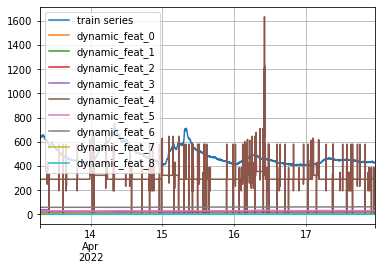

In [14]:
train_series = to_pandas(train_entry)
train_series.plot()
for i in range(len(train_entry['feat_dynamic_real'])):
    train_dynamic_series = to_pandas_extend(train_entry, 'feat_dynamic_real', i)
    train_dynamic_series.plot()
plt.grid(which="both")
plt.legend(["train series"]+['dynamic_feat_'+str(i) for i in range(len(train_entry['feat_dynamic_real']))], loc="upper left")
plt.show()

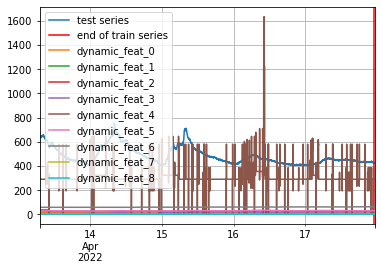

In [15]:
test_series = to_pandas(test_entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
for i in range(len(test_entry['feat_dynamic_real'])):
    test_dynamic_series = to_pandas_extend(test_entry, 'feat_dynamic_real', i)
    test_dynamic_series.plot()
plt.grid(which="both")
plt.legend(["test series", "end of train series"]+['dynamic_feat_'+str(i) for i in range(len(test_entry['feat_dynamic_real']))], loc="upper left")
plt.show()

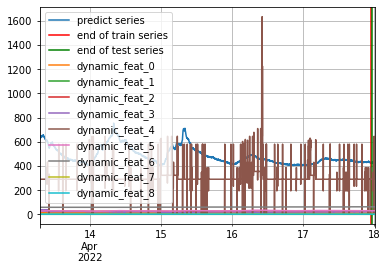

In [16]:
predict_series = to_pandas(predict_entry)
predict_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.axvline(test_series.index[-1], color='g') # end of test dataset
for i in range(len(predict_entry['feat_dynamic_real'])):
    predict_dynamic_series = to_pandas_extend(predict_entry, 'feat_dynamic_real', i)
    predict_dynamic_series.plot()
plt.grid(which="both")
plt.legend(["predict series", "end of train series", "end of test series"]+['dynamic_feat_'+str(i) for i in range(len(predict_entry['feat_dynamic_real']))], loc="upper left")
plt.show()

In [17]:
def to_pandas_extend_sum(ds: ListDataset, feat_name: str = 'target', feat_index: int = 0, freq: str = None) -> pd.Series:
    result = None
    for predict_entry in iter(ds):
        predict_series = to_pandas_extend(predict_entry, feat_name, feat_index, freq)
        if result is None:
            result = predict_series
        else:
            result = result+predict_series
    if feat_name != 'target':
        result = result/num_timeseries
    return result

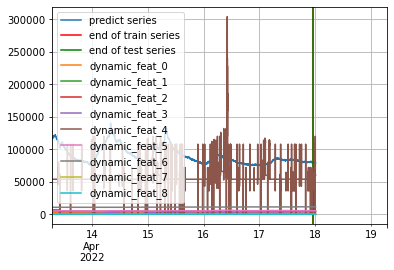

In [18]:
predict_series = to_pandas_extend_sum(predict_ds, 'target')
predict_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.axvline(test_series.index[-1], color='g') # end of test dataset
for i in range(len(predict_entry['feat_dynamic_real'])):
    predict_dynamic_series = to_pandas_extend_sum(predict_ds, 'feat_dynamic_real', i)
    predict_dynamic_series.plot()
plt.grid(which="both")
plt.legend(["predict series", "end of train series", "end of test series"]+['dynamic_feat_'+str(i) for i in range(len(predict_entry['feat_dynamic_real']))], loc="upper left")
plt.show()

In [13]:
estimators = {}
predictors = {}

## Estimator Model

In [14]:
from gluonts.model.canonical import CanonicalRNNEstimator
from gluonts.model.deep_factor import DeepFactorEstimator
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.deepstate import DeepStateEstimator
from gluonts.model.deepvar import DeepVAREstimator
from gluonts.model.gp_forecaster import GaussianProcessEstimator
from gluonts.model.gpvar import GPVAREstimator
from gluonts.model.lstnet import LSTNetEstimator
from gluonts.model.n_beats import NBEATSEstimator
from gluonts.model.renewal import DeepRenewalProcessEstimator
from gluonts.model.rotbaum import TreeEstimator, TreePredictor
from gluonts.model.san import SelfAttentionEstimator
from gluonts.model.seq2seq import MQCNNEstimator, MQRNNEstimator, RNN2QRForecaster, Seq2SeqEstimator
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.model.tft import TemporalFusionTransformerEstimator
from gluonts.model.tpp import DeepTPPEstimator
from gluonts.model.transformer import TransformerEstimator
from gluonts.model.wavenet import WaveNetEstimator

from gluonts.mx.block.quantile_output import QuantileOutput
from gluonts.mx.trainer import Trainer
from gluonts.mx.block.encoder import Seq2SeqEncoder

In [ ]:
# estimator = CanonicalRNNEstimator(
#     freq=freq,
#     prediction_length=prediction_length,
#     context_length=context_length,
#     trainer=Trainer(ctx="cpu",
#                     epochs=200,
#                     learning_rate=1e-3,
#                     batch_size=32,
#                     num_batches_per_epoch=100
#                    ),
# )
# estimators['CanonicalRNN'] = estimator

In [ ]:
# estimator = DeepFactorEstimator(
#     freq=freq,
#     prediction_length=prediction_length,
#     context_length=context_length,
#     trainer=Trainer(ctx="cpu",
#                     epochs=200,
#                     learning_rate=1e-3,
#                     batch_size=32,
#                     num_batches_per_epoch=100
#                    ),
# )
# estimators['DeepFactor'] = estimator

In [15]:
estimator = DeepAREstimator(
    freq=freq,
    prediction_length=prediction_length,
    context_length=context_length,
    trainer=Trainer(ctx="cpu",
                    epochs=8,
                    learning_rate=1e-3,
                    batch_size=32,
                    num_batches_per_epoch=100
                   ),
    use_feat_dynamic_real=True,  # True or False
    use_feat_static_cat=False,  # True or False
#     cardinality=[17]
)
estimators['DeepAR'] = estimator

In [ ]:
# estimator = DeepStateEstimator(
#     freq=freq,
#     prediction_length=prediction_length,
#     trainer=Trainer(ctx="cpu",
#                     epochs=200,
#                     learning_rate=1e-3,
#                     batch_size=32,
#                     num_batches_per_epoch=100
#                    ),
#     use_feat_dynamic_real=True,  # True
#     use_feat_static_cat=True,  # True
#     cardinality=[17]
# )
# estimators['DeepState'] = estimator

In [ ]:
# estimator = DeepVAREstimator(  # use multi
#     freq=freq,
#     prediction_length=prediction_length,
#     context_length=context_length,
#     trainer=Trainer(ctx="cpu",
#                     epochs=200,
#                     learning_rate=1e-3,
#                     batch_size=32,
#                     num_batches_per_epoch=100
#                    ),
#     target_dim=96
# )
# estimators['DeepVAR'] = estimator

In [ ]:
# estimator = GaussianProcessEstimator(
#     freq=freq,
#     prediction_length=prediction_length,
#     context_length=context_length,
#     trainer=Trainer(ctx="cpu",
#                     epochs=200,
#                     learning_rate=1e-3,
#                     batch_size=32,
#                     num_batches_per_epoch=100
#                    ),
#     cardinality=17
# )
# estimators['GaussianProcess'] = estimator

In [ ]:
# estimator = GPVAREstimator(  # use multi
#     freq=freq,
#     prediction_length=prediction_length,
#     context_length=context_length,
#     trainer=Trainer(ctx="cpu",
#                     epochs=200,
#                     learning_rate=1e-3,
#                     batch_size=32,
#                     num_batches_per_epoch=100
#                    ),
#     target_dim=96
# )
# estimators['GPVAR'] = estimator

In [ ]:
# estimator = LSTNetEstimator(  # use multi
#     freq=freq,
#     prediction_length=prediction_length,
#     context_length=context_length,
#     num_series=96,
#     skip_size=4,
#     ar_window=4,
#     channels=72,
#     trainer=Trainer(ctx="cpu",
#                     epochs=200,
#                     learning_rate=1e-3,
#                     batch_size=32,
#                     num_batches_per_epoch=100
#                    ),
# )
# estimators['LSTNet'] = estimator

In [ ]:
# estimator = NBEATSEstimator(
#     freq=freq,
#     prediction_length=prediction_length,
#     context_length=context_length,
#     trainer=Trainer(ctx="cpu",
#                     epochs=200,
#                     learning_rate=1e-3,
#                     batch_size=32,
#                     num_batches_per_epoch=100
#                    ),
# )
# estimators['NBEATS'] = estimator

In [ ]:
# estimator = MQCNNEstimator(
#     freq=freq,
#     prediction_length=prediction_length,
#     context_length=context_length,
#     trainer=Trainer(ctx="cpu",
#                     epochs=200,
#                     learning_rate=1e-3,
#                     batch_size=32,
#                     num_batches_per_epoch=100
#                    ),
# )
# estimators['MQCNN'] = estimator

In [ ]:
# estimator = MQRNNEstimator(
#     freq=freq,
#     prediction_length=prediction_length,
#     context_length=context_length,
#     trainer=Trainer(ctx="cpu",
#                     epochs=200,
#                     learning_rate=1e-3,
#                     batch_size=32,
#                     num_batches_per_epoch=100
#                    ),
# )
# estimators['MQRNN'] = estimator

In [ ]:
# # TODO
# estimator = RNN2QRForecaster(
#     freq=freq,
#     prediction_length=prediction_length,
#     context_length=context_length,
#     trainer=Trainer(ctx="cpu",
#                     epochs=200,
#                     learning_rate=1e-3,
#                     batch_size=32,
#                     num_batches_per_epoch=100
#                    ),
# #     cardinality=[61]
#     cardinality=[17],
#     embedding_dimension=4,
#     encoder_rnn_layer=4,
#     encoder_rnn_num_hidden=4,
#     decoder_mlp_layer=[4],
#     decoder_mlp_static_dim=4
# )
# estimators['RNN2QR'] = estimator

In [ ]:
# # TODO
# estimator = Seq2SeqEstimator(
#     freq=freq,
#     prediction_length=prediction_length,
#     context_length=context_length,
#     trainer=Trainer(ctx="cpu",
#                     epochs=200,
#                     learning_rate=1e-3,
#                     batch_size=32,
#                     num_batches_per_epoch=100
#                    ),
# #     cardinality=[61]
#     cardinality=[17],
#     embedding_dimension=4,
#     encoder=Seq2SeqEncoder(),
#     decoder_mlp_layer=[4],
#     decoder_mlp_static_dim=4
# )
# estimators['Seq2Seq'] = estimator

In [ ]:
# estimator = SimpleFeedForwardEstimator(
#     num_hidden_dimensions=[40, 40],
#     prediction_length=prediction_length,
#     context_length=context_length,
#     freq=freq,
#     trainer=Trainer(ctx="cpu",
#                     epochs=200,
#                     learning_rate=1e-3,
#                     batch_size=32,
#                     num_batches_per_epoch=100
#                    )
# )
# estimators['SimpleFeedForward'] = estimator

In [ ]:
# estimator = TransformerEstimator(
#     freq=freq,
#     prediction_length=prediction_length,
#     trainer=Trainer(ctx="cpu",
#                     epochs=200,
#                     learning_rate=1e-3,
#                     batch_size=32,
#                     num_batches_per_epoch=100
#                    ),
# #     cardinality=[61]
#     cardinality=[17]
# )
# estimators['Transformer'] = estimator

In [ ]:
# estimator = WaveNetEstimator(
#     freq=freq,
#     prediction_length=prediction_length,
#     trainer=Trainer(ctx="cpu",
#                     epochs=200,
#                     learning_rate=1e-3,
#                     batch_size=32,
#                     num_batches_per_epoch=100
#                    ),
# #     cardinality=[61]
#     cardinality=[17]
# )
# estimators['WaveNet'] = estimator

In [ ]:
%%time

for name, estimator in estimators.items():
    start = time.time()
    try:
        predictor1 = estimator.train(train_ds)
    except:
        predictor1 = estimator.train(train_ds_multi)
    predictors[name] = predictor1
    end = time.time()
    print(name, end-start)

  0%|          | 0/100 [00:00<?, ?it/s]

[2022-05-11 02:25:19.297 ip-172-16-121-10:1561 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-05-11 02:25:19.388 ip-172-16-121-10:1561 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


100%|██████████| 100/100 [03:22<00:00,  2.03s/it, epoch=8/8, avg_epoch_loss=4.49]


DeepAR 1994.02365899086
CPU times: user 1h 59min 47s, sys: 42.4 s, total: 2h 29s
Wall time: 33min 14s


In [23]:
from pathlib import Path

In [24]:
!mkdir -p gluonts_model/deepar/

# save the trained model in tmp/
predictor1.serialize(Path("gluonts_model/deepar/"))

In [25]:
# loads it back
from gluonts.model.predictor import Predictor
predictor1 = Predictor.deserialize(Path("gluonts_model/deepar/"))

## Predictor Model

In [18]:
from gluonts.model.naive_2 import Naive2Predictor
from gluonts.model.npts import NPTSPredictor
from gluonts.model.prophet import ProphetPredictor
from gluonts.model.r_forecast import RForecastPredictor
from gluonts.model.seasonal_naive import SeasonalNaivePredictor

In [ ]:
# %%time
# # TODO Multiplicative seasonality is not appropriate for zero and negative values
# predictor2 = Naive2Predictor(freq=freq, prediction_length=prediction_length, season_length=context_length)
# predictors['Naive2'] = predictor2

In [19]:
%%time

predictor2 = NPTSPredictor(freq=freq, prediction_length=prediction_length, context_length=context_length)
predictors['NPTS'] = predictor2

CPU times: user 292 µs, sys: 0 ns, total: 292 µs
Wall time: 298 µs


In [27]:
# %%time

# # def configure_model(model):
# #     model.add_seasonality(
# #         name='weekly', period=7, fourier_order=3, prior_scale=0.1
# #     )
# #     return model

# predictor2 = ProphetPredictor(freq=freq, prediction_length=prediction_length)  # , init_model=configure_model
# predictors['Prophet'] = predictor2

CPU times: user 123 µs, sys: 0 ns, total: 123 µs
Wall time: 127 µs


In [ ]:
# %%time
# # TODO
# predictor2 = RForecastPredictor(freq=freq,
#                               prediction_length=prediction_length,
#                               method_name='arima',  # The method from rforecast to be used one of “ets”, “arima”, “tbats” (bug), “croston” (bug), “mlp” (bug).
#                               period=context_length,
#                               trunc_length=len(train[0]['target']))
# predictors['ARIMA'] = predictor2

In [21]:
# %%time

# predictor2 = SeasonalNaivePredictor(freq=freq, prediction_length=prediction_length)
# predictors['SeasonalNaive'] = predictor2

CPU times: user 534 µs, sys: 0 ns, total: 534 µs
Wall time: 541 µs


## Select a predictor

In [59]:
# predictor = predictor1
# predictor = predictor2
predictor = predictors['DeepAR']  # NPTS, DeepAR

## Evaluation

In [60]:
%%time

from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=predict_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)
print(len(forecasts), len(tss))

186 186
CPU times: user 1min 19s, sys: 1.88 s, total: 1min 21s
Wall time: 18.8 s


## Evaluate All

In [61]:
%%time

from gluonts.evaluation import Evaluator

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(predict_ds))

print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 186/186 [00:00<00:00, 873.62it/s]


{
    "MSE": 12203.988643523186,
    "abs_error": 179510.8738708496,
    "abs_target_sum": 1183522.3647460938,
    "abs_target_mean": 636.3023466376848,
    "seasonal_error": 62.60263942370429,
    "MASE": 1.6700892468135375,
    "MAPE": 0.1509390065106012,
    "sMAPE": 0.1665308609444608,
    "MSIS": 39.25478224575916,
    "QuantileLoss[0.1]": 46830.95689697266,
    "Coverage[0.1]": 0.008602150537634409,
    "QuantileLoss[0.5]": 179510.87356567383,
    "Coverage[0.5]": 0.014516129032258063,
    "QuantileLoss[0.9]": 234183.99231567385,
    "Coverage[0.9]": 0.028494623655913983,
    "RMSE": 110.47166443719034,
    "NRMSE": 0.1736150511167197,
    "ND": 0.1516751007146036,
    "wQuantileLoss[0.1]": 0.039569135566795574,
    "wQuantileLoss[0.5]": 0.15167510045674978,
    "wQuantileLoss[0.9]": 0.19787035656560184,
    "mean_absolute_QuantileLoss": 153508.60759277345,
    "mean_wQuantileLoss": 0.12970486419638239,
    "MAE_Coverage": 0.48279569892473123,
    "OWA": NaN
}
CPU times: user 37.

In [62]:
item_metrics.head()

item_id         MSE   abs_error  abs_target_sum  abs_target_mean  \
0  AWSNXUORPM  705.325000  254.211823     4228.500000        422.85000   
1  AWSNXUORPM  571.781348  237.607544     4229.833496        422.98335   
2  AWSNXUORPM  668.027393  250.833252     4241.899902        424.18999   
3  AWSNXUORPM  790.249365  278.036163     4267.500000        426.75000   
4  AWSNXUORPM  903.820703  282.755920     4295.500000        429.55000   

   seasonal_error      MASE      MAPE     sMAPE      MSIS  QuantileLoss[0.1]  \
0       38.536300  0.659668  0.060128  0.062215  3.478653          83.912170   
1       38.490061  0.617322  0.056173  0.057824  1.916577          79.136047   
2       38.449936  0.652363  0.059089  0.060973  4.039526          83.241125   
3       38.409666  0.723870  0.065127  0.067399  5.119940          83.552191   
4       38.372102  0.736879  0.065833  0.068255  5.337327          94.167700   

   Coverage[0.1]  QuantileLoss[0.5]  Coverage[0.5]  QuantileLoss[0.9]  \
0            0.0         254.211823            0.0         186.439984   
1            0.0         237.607544            0.0         153.816064   
2            0.0         250.833252            0.0         169.084534   
3            0.0         278.036163            0.0         217.378564   
4            0.0         282.755920            0.0         233.407593   

   Coverage[0.9]  
0            0.1  
1            0.0  
2            0.0  
3            0.0  
4            0.1

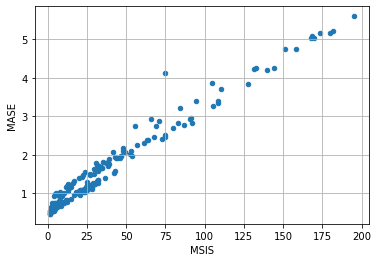

In [63]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

<AxesSubplot:>

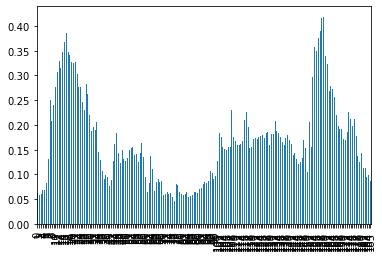

In [64]:
item_metrics['sMAPE'].plot(kind='bar')

<AxesSubplot:xlabel='sMAPE'>

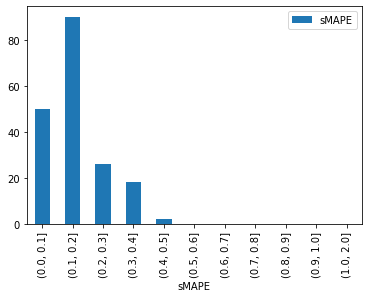

In [65]:
quartiles = pd.cut(item_metrics.sMAPE, [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1, 2])
#print(quartiles)
def get_stats(group):
    return {'sMAPE': group.count()}
grouped = item_metrics.sMAPE.groupby(quartiles)
price_bucket_amount = grouped.apply(get_stats).unstack()
#price_bucket_amount
price_bucket_amount.plot(kind='bar')

In [66]:
item_metrics['sMAPE'].idxmin(), item_metrics['sMAPE'].min(), item_metrics['sMAPE'].idxmax(), item_metrics['sMAPE'].max()

(76, 0.04680370092391968, 159, 0.41901216506958006)

### Visualize a Result

In [67]:
def plot_prob_forecasts(ts_entry, forecast_entry):
#     print('ts_entry:', ts_entry)
#     print('forecast_entry:', forecast_entry)
    plot_length = context_length+prediction_length
    prediction_intervals = (50.0, 90.0)
#     prediction_intervals = [80.0]
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    pd.plotting.register_matplotlib_converters()  # https://stackoverflow.com/questions/43206554/typeerror-float-argument-must-be-a-string-or-a-number-not-period
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='orange')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

In [68]:
def show_metrics(customer_id=0, target_quantile=0.5, plot_graph=True):

    # first entry of the time series list
    ts_entry = tss[customer_id]

    # first 5 values of the time series (convert from pandas to numpy)
    # print(np.array(ts_entry[:5]).reshape(-1,))

    # first entry of dataset.test
    dataset_test_entry = next(iter(predict_ds))

    # first 5 values
    # print(dataset_test_entry['target'][:5])

    # first entry of the forecast list
    forecast_entry = forecasts[customer_id]

    if plot_graph:
        print(f"Number of sample paths: {forecast_entry.num_samples}")
        print(f"Dimension of samples: {forecast_entry.samples.shape}")
        print(f"Start date of the forecast window: {forecast_entry.start_date}")
        print(f"Frequency of the time series: {forecast_entry.freq}")

        print(f"Mean of the future window:\n {forecast_entry.mean}")
        print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")
        print(f"target_value:\n {ts_entry[-prediction_length:].values.reshape((1, -1))}")

        plot_prob_forecasts(ts_entry, forecast_entry)
    
    y_label = list(ts_entry[-prediction_length:].values.reshape((1, -1))[0])
#     y_pred = list(forecast_entry.mean)
    y_pred = list(forecast_entry.quantile(target_quantile))
    return y_label, y_pred

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 00:00:00
Frequency of the time series: 1Min
Mean of the future window:
 [404.10394 402.5596  418.01886 391.5935  391.85175 391.04214 394.3375
 397.19458 391.6381  392.73492]
0.5-quantile (median) of the future window:
 [404.7343  402.83347 419.93204 391.23993 392.16162 391.00552 393.73422
 395.18295 391.2186  392.2455 ]
target_value:
 [[422.  423.5 424.  423.5 423.5 421.  422.  422.  423.  424. ]]


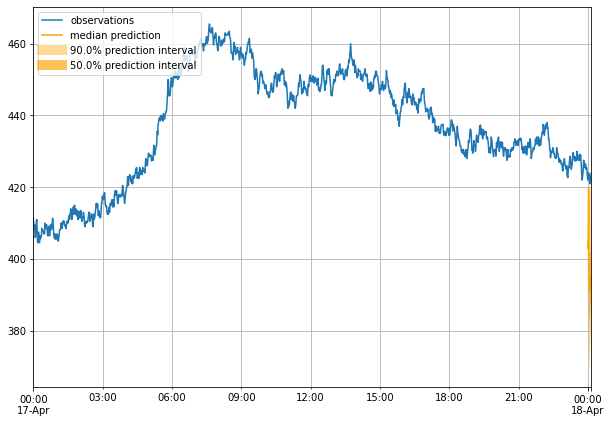

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 00:10:00
Frequency of the time series: 1Min
Mean of the future window:
 [402.81897 401.87378 400.96246 400.08847 401.492   398.2624  397.14844
 398.38855 395.06204 395.85144]
0.5-quantile (median) of the future window:
 [403.639   402.6328  400.3274  399.97803 402.74976 399.2055  397.0939
 396.54382 395.7372  394.31836]
target_value:
 [[423.33334 423.      423.      423.5     422.5     422.5     424.
  424.5     422.5     421.     ]]


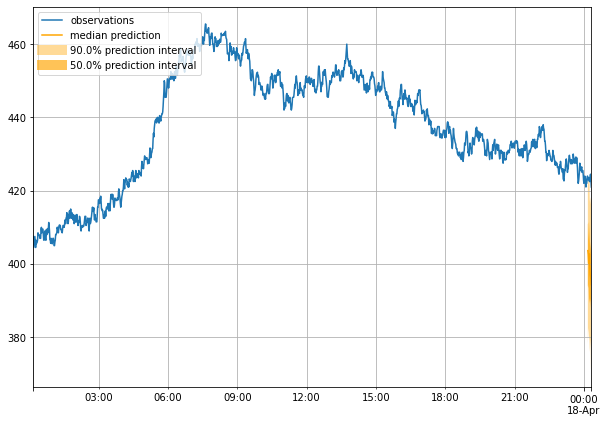

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 00:20:00
Frequency of the time series: 1Min
Mean of the future window:
 [403.1915  402.18607 403.09903 402.5107  400.3466  399.85046 393.1169
 396.97665 394.32098 393.38824]
0.5-quantile (median) of the future window:
 [402.74112 403.05392 403.9624  402.34164 400.25354 400.69525 395.01254
 395.18073 394.382   393.44363]
target_value:
 [[422.5     422.33334 422.5     422.5     424.6     424.6     425.5
  425.2     425.5     426.66666]]


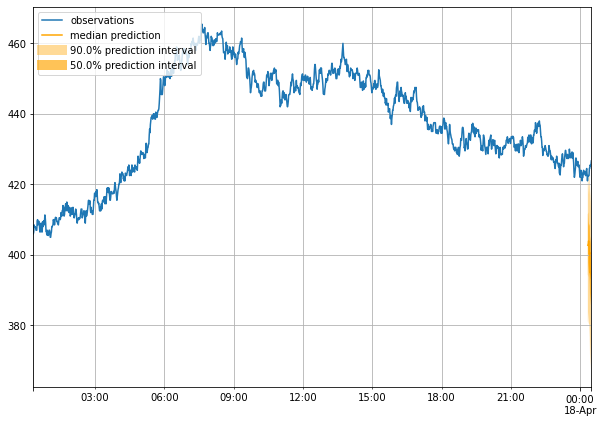

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 00:30:00
Frequency of the time series: 1Min
Mean of the future window:
 [406.03778 401.7234  406.0354  400.2585  400.58505 398.4316  397.9182
 394.1611  394.545   391.9304 ]
0.5-quantile (median) of the future window:
 [404.71628 401.417   407.1352  398.6284  399.2776  398.98666 396.86072
 396.06317 394.1692  392.20966]
target_value:
 [[425.5 425.  425.5 427.  426.5 427.5 427.5 428.  427.5 427.5]]


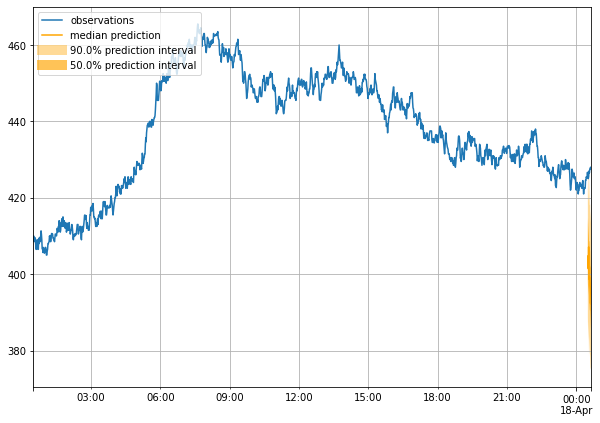

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 00:40:00
Frequency of the time series: 1Min
Mean of the future window:
 [403.3266  403.74103 400.34216 399.135   407.27625 419.90805 395.0963
 393.83453 389.28714 393.70093]
0.5-quantile (median) of the future window:
 [404.1889  404.7843  401.86075 400.51718 407.84515 419.6076  395.1507
 393.6533  391.4709  393.6653 ]
target_value:
 [[427.  428.5 430.  430.  430.  431.5 431.5 430.  428.5 428.5]]


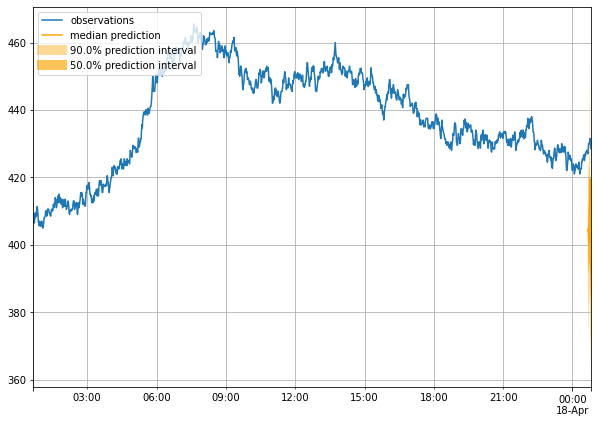

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 00:50:00
Frequency of the time series: 1Min
Mean of the future window:
 [403.6875  404.03848 400.23758 401.88614 399.3073  397.13235 398.11633
 393.36737 394.35132 392.43024]
0.5-quantile (median) of the future window:
 [404.13242 403.9532  400.62744 402.16864 398.71536 397.83075 397.2266
 392.77762 394.20242 392.30106]
target_value:
 [[429.      431.      430.      432.      431.33334 433.      433.5
  434.5     434.      435.66666]]


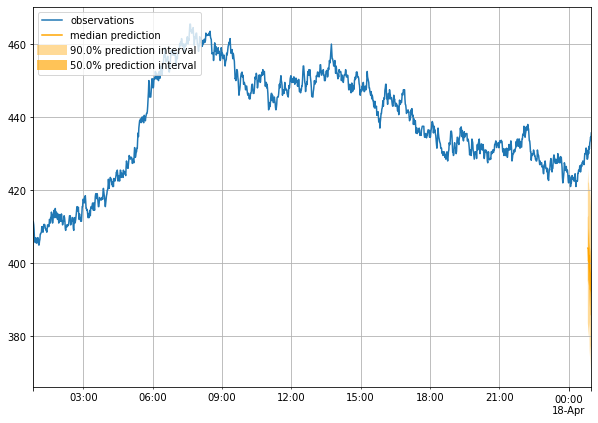

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 01:00:00
Frequency of the time series: 1Min
Mean of the future window:
 [404.03693 403.37708 402.22586 401.90216 411.96902 417.68362 417.2119
 382.10913 376.2337  378.9882 ]
0.5-quantile (median) of the future window:
 [403.97885 403.1848  402.16675 402.31137 412.42252 419.826   419.66632
 384.39786 374.34402 378.65707]
target_value:
 [[437.33334 438.5     439.      441.      442.      446.2857  460.18182
  475.18182 487.27274 497.     ]]


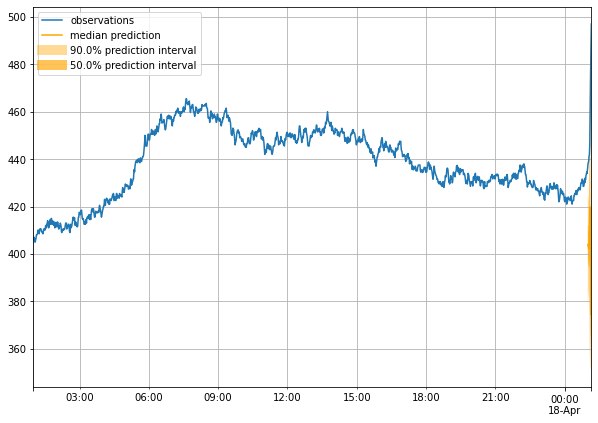

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 01:10:00
Frequency of the time series: 1Min
Mean of the future window:
 [394.86926 397.44968 400.48657 398.50766 395.24707 391.3774  391.35147
 384.72266 380.67316 379.8922 ]
0.5-quantile (median) of the future window:
 [392.82428 397.2627  401.53906 398.333   395.27988 392.753   390.73804
 384.78778 381.0444  380.861  ]
target_value:
 [[502.5     505.5     507.      509.      509.      505.83334 502.5
  501.      497.5     494.     ]]


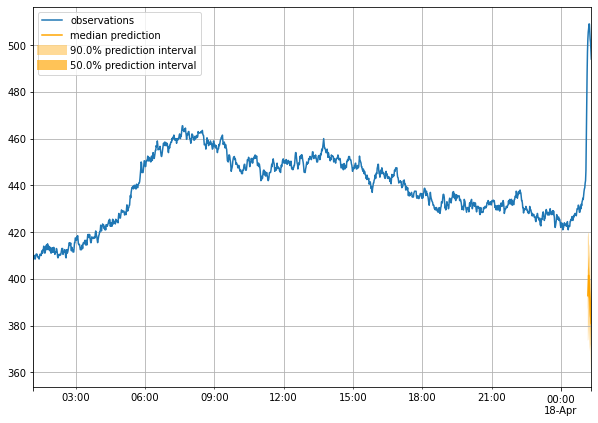

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 01:20:00
Frequency of the time series: 1Min
Mean of the future window:
 [418.9503  417.92184 415.16876 408.0481  402.18387 400.10977 394.86816
 386.53442 384.74332 382.63605]
0.5-quantile (median) of the future window:
 [418.48694 419.0443  415.6856  407.91608 403.57355 401.3492  394.0796
 387.37897 385.1787  382.33325]
target_value:
 [[492.5     494.      493.5     494.5     495.5     496.5     494.66666
  493.5     494.5     496.     ]]


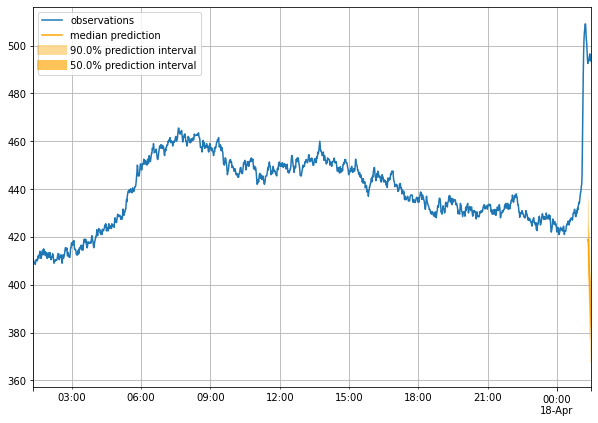

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 01:30:00
Frequency of the time series: 1Min
Mean of the future window:
 [411.86304 412.4439  409.17435 405.4206  398.4953  396.67108 392.32947
 384.34622 382.97144 382.54117]
0.5-quantile (median) of the future window:
 [410.5997  412.4223  408.56815 405.47156 399.80963 397.70395 392.53558
 384.96432 382.5178  383.81366]
target_value:
 [[497.33334 498.      501.      504.      507.      509.5     511.5
  511.5     511.5     513.5    ]]


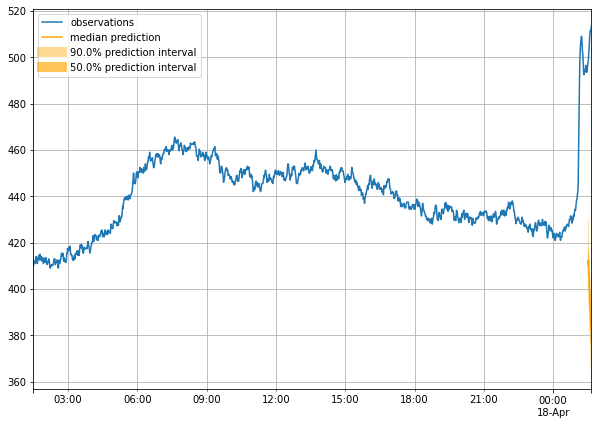

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 01:40:00
Frequency of the time series: 1Min
Mean of the future window:
 [420.44727 417.15823 414.48743 410.0145  405.19165 402.85934 397.04523
 391.23886 385.67105 381.34195]
0.5-quantile (median) of the future window:
 [420.06693 415.45602 415.8236  409.16553 403.53564 401.91895 395.55164
 390.94153 386.2886  382.33426]
target_value:
 [[517.     521.5    525.5    528.5    531.     533.     535.     537.
  541.1667 544.    ]]


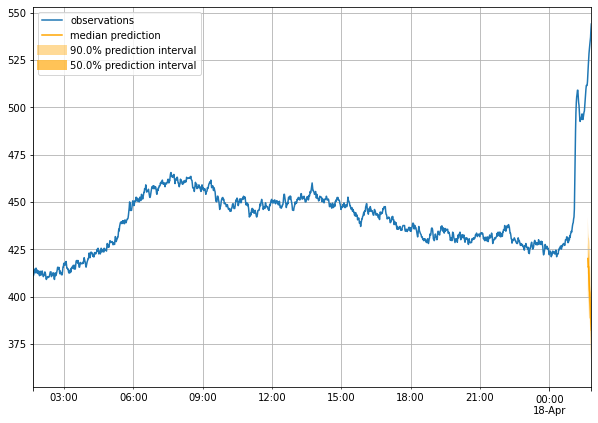

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 01:50:00
Frequency of the time series: 1Min
Mean of the future window:
 [428.55344 427.37784 422.6214  421.0838  410.79944 406.5093  404.11914
 395.97403 392.40643 386.73746]
0.5-quantile (median) of the future window:
 [429.16925 427.05582 422.7171  420.6581  410.85123 405.21014 405.01083
 395.89267 391.80487 388.53217]
target_value:
 [[546.     548.5    552.     555.3333 557.     560.     561.6667 563.
  566.     570.    ]]


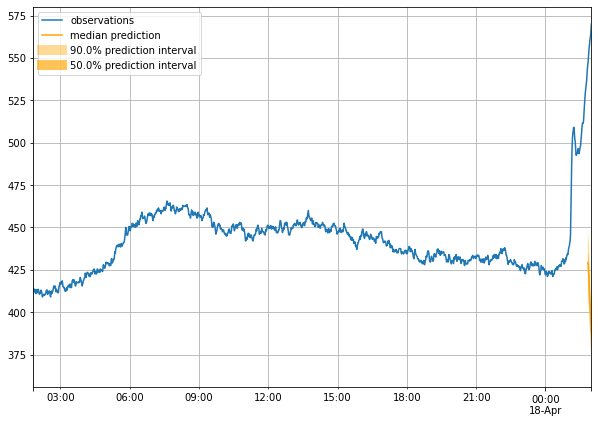

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 02:00:00
Frequency of the time series: 1Min
Mean of the future window:
 [436.4721  436.5705  431.84122 430.99362 422.34097 414.78665 413.21844
 403.39542 400.86145 397.90176]
0.5-quantile (median) of the future window:
 [437.38837 436.88644 431.82913 430.62125 422.41135 416.02893 413.70587
 403.67407 401.85153 397.74466]
target_value:
 [[572.5    575.     578.     580.3333 581.5    585.     589.5    593.
  595.     594.6667]]


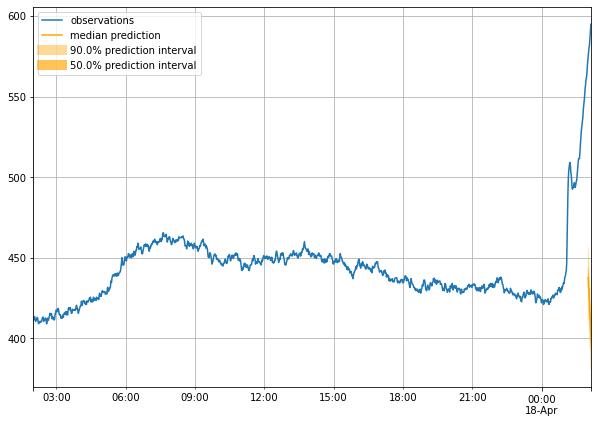

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 02:10:00
Frequency of the time series: 1Min
Mean of the future window:
 [460.70206 458.46887 454.4301  449.4175  443.22046 438.05206 433.15527
 422.07462 415.44684 414.4248 ]
0.5-quantile (median) of the future window:
 [460.99078 459.48138 456.00803 449.2842  442.4534  438.02383 433.20438
 422.9223  415.62857 414.92883]
target_value:
 [[594.6667 596.5    598.5    598.8    602.     605.     607.     609.
  611.     612.    ]]


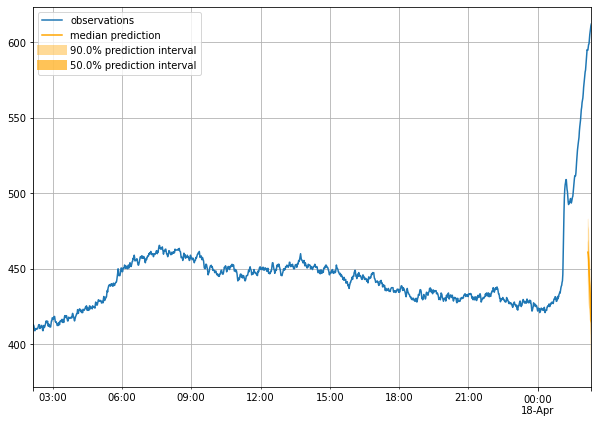

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 02:20:00
Frequency of the time series: 1Min
Mean of the future window:
 [468.37473 469.01437 464.7348  456.42413 451.67847 444.38467 436.37305
 428.08026 421.58115 418.8705 ]
0.5-quantile (median) of the future window:
 [470.06134 470.48746 462.31992 457.07013 450.4308  445.29092 437.4785
 426.61975 421.838   420.1947 ]
target_value:
 [[615.5 620.  625.  630.  634.2 637.5 641.  644.  645.  648. ]]


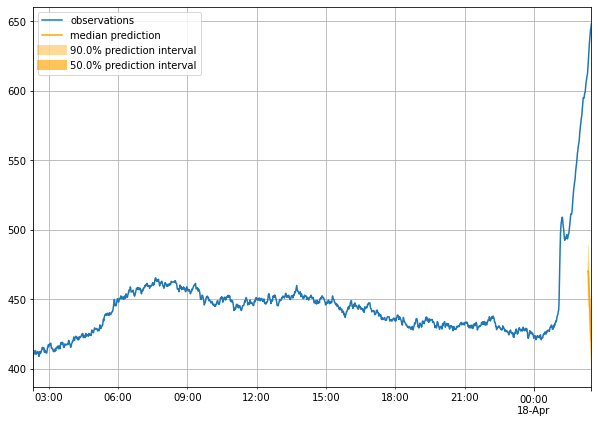

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 02:30:00
Frequency of the time series: 1Min
Mean of the future window:
 [482.41025 486.1602  481.63684 470.766   464.90524 456.30145 448.60672
 440.14276 435.09457 427.54602]
0.5-quantile (median) of the future window:
 [482.61905 485.33722 481.13528 473.01938 465.88556 455.26016 448.41718
 439.68768 434.1285  427.8392 ]
target_value:
 [[651.5 654.  655.  658.5 665.  669.5 673.  677.  680.  682. ]]


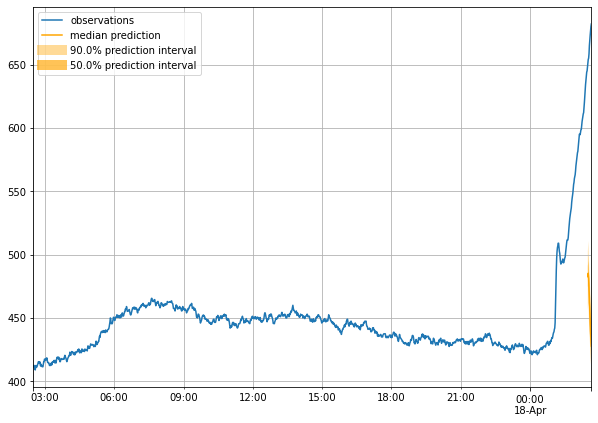

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 02:40:00
Frequency of the time series: 1Min
Mean of the future window:
 [502.18796 501.89374 494.75275 476.6673  462.32227 466.4418  459.31015
 453.5025  445.23083 440.57635]
0.5-quantile (median) of the future window:
 [502.85196 501.2293  494.05743 477.5927  461.81223 467.59158 459.9271
 454.16278 445.19846 440.6472 ]
target_value:
 [[683.     685.5    688.2    691.     694.     697.5    701.5    704.
  704.     706.3333]]


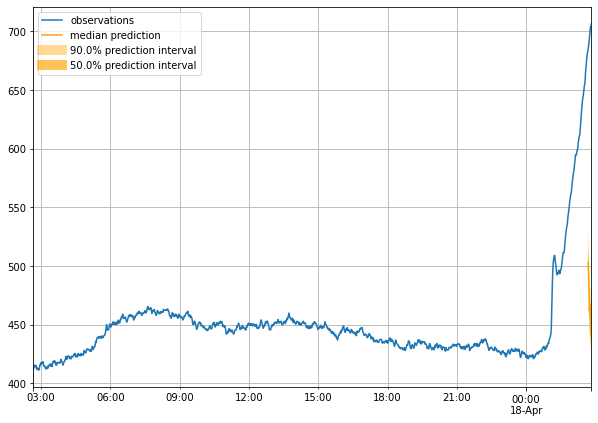

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 02:50:00
Frequency of the time series: 1Min
Mean of the future window:
 [525.68823 523.6889  516.799   518.12646 504.6946  499.58548 491.19946
 479.37305 474.9655  470.683  ]
0.5-quantile (median) of the future window:
 [526.20557 523.2251  516.9923  519.28467 505.40775 498.6061  491.62823
 478.68658 473.8169  470.3304 ]
target_value:
 [[704.6667 706.5    706.     708.     710.     711.     712.     712.6667
  713.     715.5   ]]


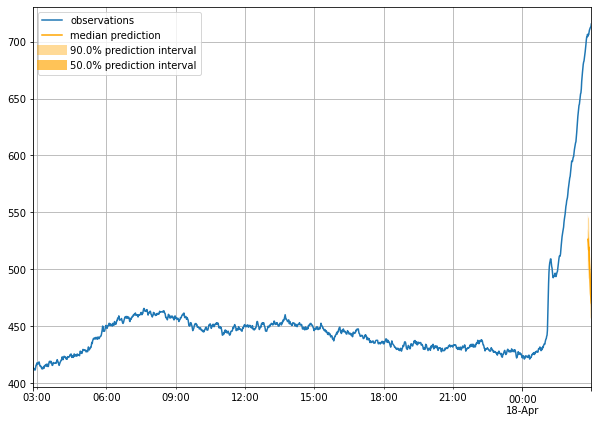

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 03:00:00
Frequency of the time series: 1Min
Mean of the future window:
 [540.70746 539.8858  536.2216  529.6233  522.1485  515.1691  508.4907
 496.42477 492.62036 491.6336 ]
0.5-quantile (median) of the future window:
 [539.5968  540.9921  537.7485  529.354   520.5835  514.0926  508.40424
 496.5931  491.92792 491.13223]
target_value:
 [[719.     722.1667 721.5    722.5    724.5    729.     733.5    737.2
  740.     741.6667]]


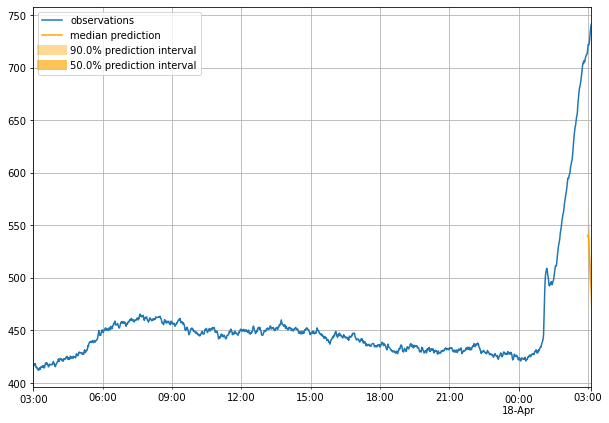

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 03:10:00
Frequency of the time series: 1Min
Mean of the future window:
 [560.2086  558.2379  554.01624 549.63495 540.1293  533.57056 524.8636
 514.74854 510.35956 504.13794]
0.5-quantile (median) of the future window:
 [560.57983 558.88    553.61676 549.7403  538.9225  532.3607  524.7296
 514.71594 510.88385 502.91663]
target_value:
 [[744.     743.5    742.     740.6667 741.     744.     745.     745.8333
  745.8333 749.    ]]


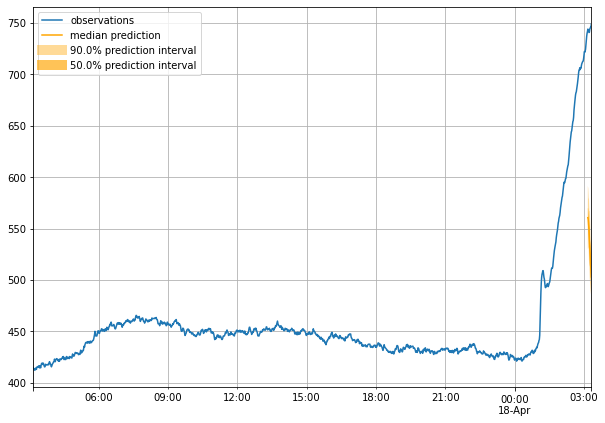

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 03:20:00
Frequency of the time series: 1Min
Mean of the future window:
 [575.9219  570.89453 563.2881  564.2926  552.8684  545.25226 536.17596
 526.08685 516.39667 513.26794]
0.5-quantile (median) of the future window:
 [576.63007 573.27893 566.8055  562.8634  552.4212  544.5944  537.5671
 524.5724  517.4172  515.097  ]
target_value:
 [[751.     753.     755.5    758.5    758.3333 760.     761.5    762.5
  762.4    763.5   ]]


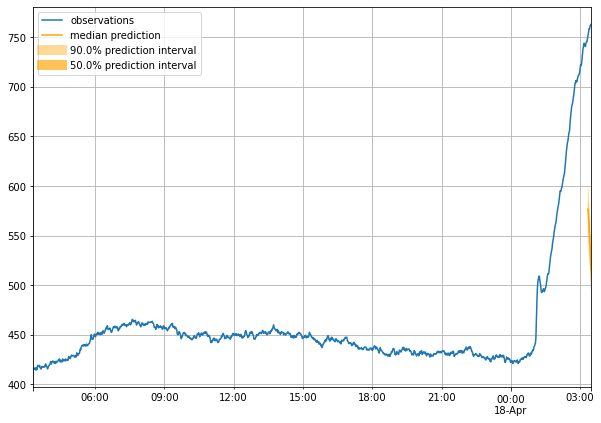

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 03:30:00
Frequency of the time series: 1Min
Mean of the future window:
 [583.18164 578.89246 574.346   570.1868  562.8911  554.781   549.3331
 537.735   530.5554  524.33167]
0.5-quantile (median) of the future window:
 [582.77704 578.8068  577.7529  570.3343  565.841   550.77386 547.92096
 540.9333  531.09143 524.4394 ]
target_value:
 [[765.5    767.     767.5    769.5    771.8    776.     778.5    780.6667
  782.8    781.    ]]


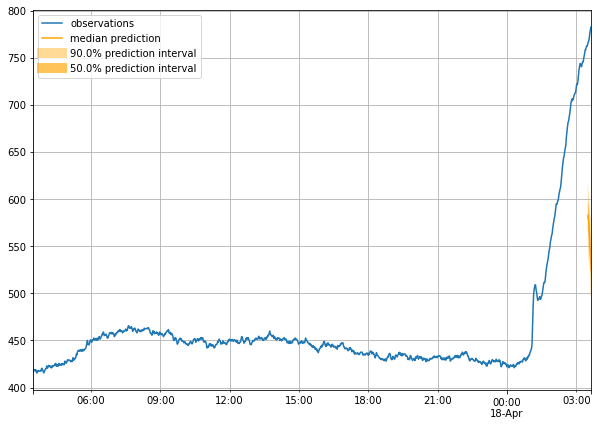

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 03:40:00
Frequency of the time series: 1Min
Mean of the future window:
 [601.1292  600.78436 591.837   589.967   578.4125  571.2241  563.76483
 552.5088  546.86957 543.1793 ]
0.5-quantile (median) of the future window:
 [598.70105 602.6008  592.6677  585.04553 577.70215 571.15564 565.33014
 553.7543  545.92377 542.31616]
target_value:
 [[783.  782.5 784.5 783.  780.5 778.  776.  773.5 771.  769.5]]


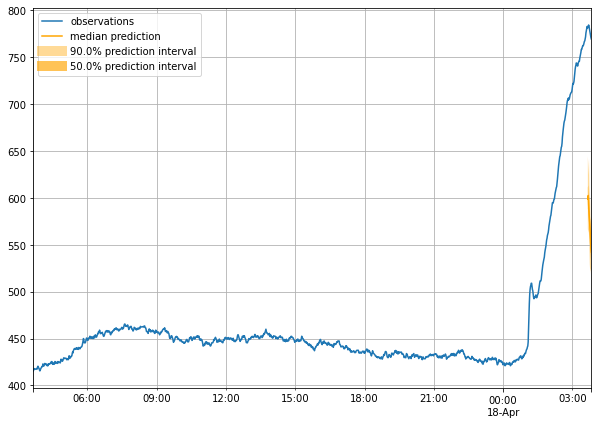

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 03:50:00
Frequency of the time series: 1Min
Mean of the future window:
 [606.57495 606.183   596.4498  593.97705 585.2394  578.4028  570.0786
 558.52527 557.8922  551.2304 ]
0.5-quantile (median) of the future window:
 [605.9858  604.75757 595.76416 593.8325  587.15314 575.18774 570.7677
 561.0284  557.13446 550.8965 ]
target_value:
 [[768.5    767.     765.     765.5    766.     764.     765.5    766.
  768.8333 771.3333]]


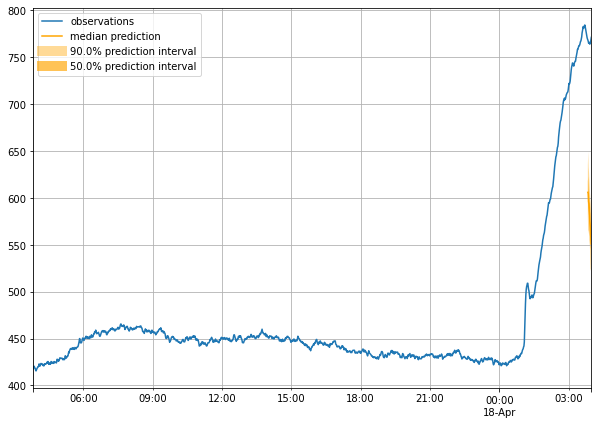

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 04:00:00
Frequency of the time series: 1Min
Mean of the future window:
 [610.23706 605.3345  602.89386 595.0757  588.6603  579.28735 579.0623
 573.3843  569.90283 560.658  ]
0.5-quantile (median) of the future window:
 [608.46405 601.81525 604.4647  593.413   589.4759  583.4753  578.6117
 573.49347 571.3239  559.61786]
target_value:
 [[772.8    774.     776.     776.5    776.     776.3333 775.     773.5
  771.     768.2   ]]


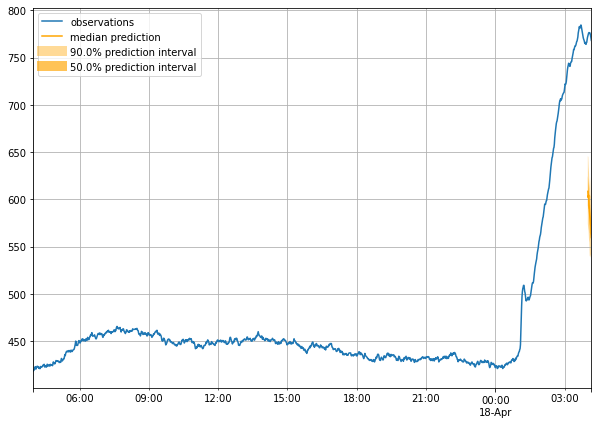

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 04:10:00
Frequency of the time series: 1Min
Mean of the future window:
 [623.3616  619.4797  614.2792  605.4631  600.3094  590.1322  588.03125
 575.366   558.78925 542.4386 ]
0.5-quantile (median) of the future window:
 [623.98004 617.5802  615.9292  605.28723 604.17694 589.9003  586.18365
 576.52356 561.991   544.0834 ]
target_value:
 [[767.     764.5    765.     763.     760.5    757.5    756.5    755.
  752.     749.3333]]


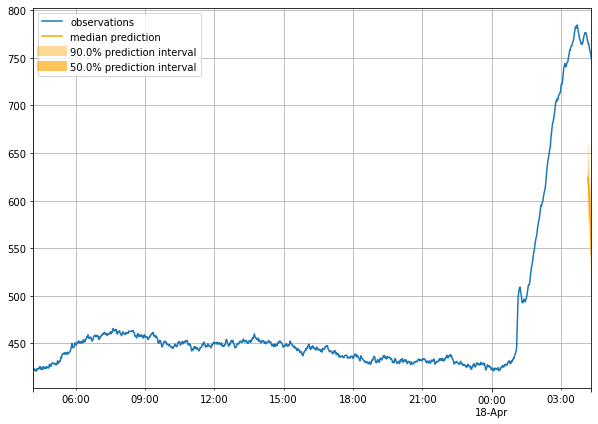

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 04:20:00
Frequency of the time series: 1Min
Mean of the future window:
 [599.978   600.5229  597.5216  598.1172  595.8706  589.22144 588.62067
 580.53204 573.7726  579.55804]
0.5-quantile (median) of the future window:
 [603.097   599.37427 598.3911  598.08136 596.9786  590.6133  588.0494
 579.7039  573.2242  580.57684]
target_value:
 [[749.  747.5 746.  744.  742.  740.5 742.  744.5 745.5 747. ]]


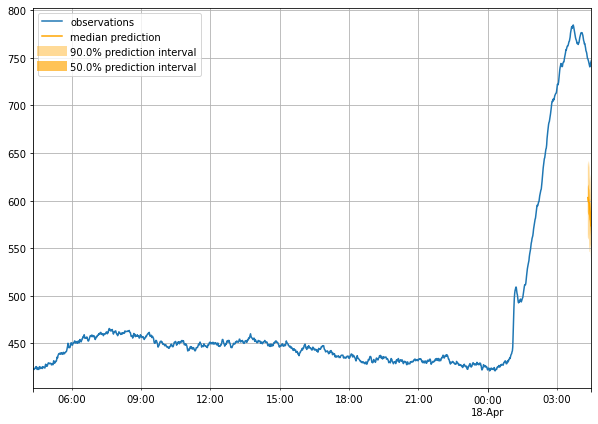

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 04:30:00
Frequency of the time series: 1Min
Mean of the future window:
 [626.4929  598.21216 582.93756 603.63873 599.6375  566.207   571.75134
 552.67163 527.92773 531.08716]
0.5-quantile (median) of the future window:
 [622.8831  597.5398  579.541   608.2807  603.9054  566.59015 565.17755
 552.40436 525.3207  533.7748 ]
target_value:
 [[750.5    754.     757.8333 760.     761.5    764.5    769.     774.5
  778.3333 778.5   ]]


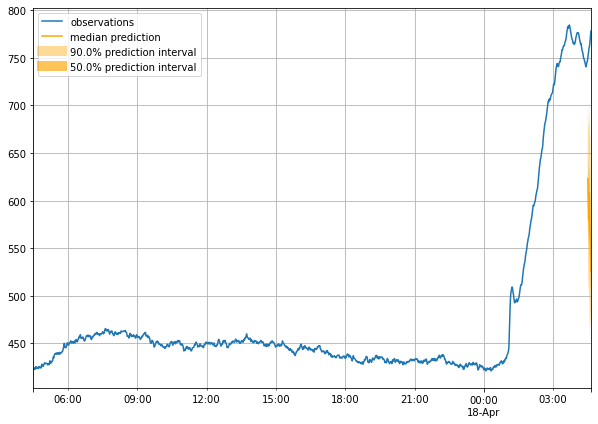

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 04:40:00
Frequency of the time series: 1Min
Mean of the future window:
 [594.8747  602.13513 611.9659  613.32947 603.0941  605.90607 583.36835
 599.23596 568.0712  545.54865]
0.5-quantile (median) of the future window:
 [597.71576 604.76227 610.4969  613.80237 606.6608  604.6861  585.2436
 598.5296  570.4421  548.49084]
target_value:
 [[779.5 780.  780.5 777.5 775.5 773.  770.5 769.  767.  763.5]]


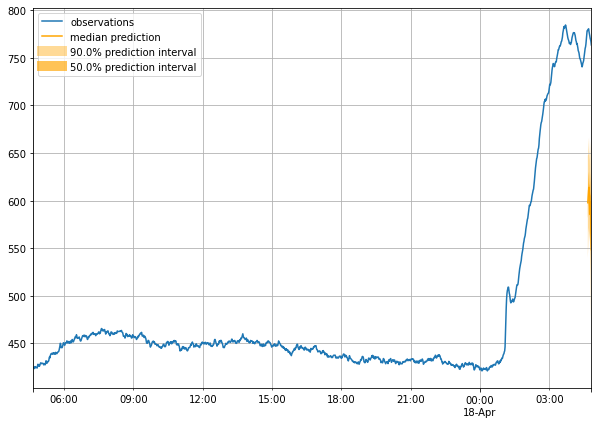

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 04:50:00
Frequency of the time series: 1Min
Mean of the future window:
 [613.75476 618.7703  617.3897  618.4981  612.54333 608.0686  609.08484
 601.17993 600.5175  597.80963]
0.5-quantile (median) of the future window:
 [614.1361  619.00775 618.9693  616.6879  615.4139  609.9814  607.4474
 601.49603 600.4445  596.3706 ]
target_value:
 [[762.     761.5    760.5    760.     758.5    758.4    760.6667 762.5
  760.5    760.3333]]


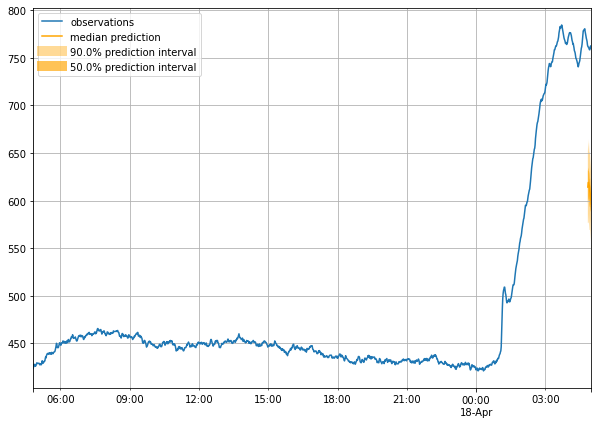

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 05:00:00
Frequency of the time series: 1Min
Mean of the future window:
 [646.9918  647.8119  643.8954  645.8286  635.07776 631.25867 630.6966
 622.2599  620.8425  616.7151 ]
0.5-quantile (median) of the future window:
 [646.6482  649.05664 645.40857 649.3065  634.4479  628.5672  627.9492
 618.3769  623.30347 616.75366]
target_value:
 [[758.6667 761.     762.5    763.     765.1667 766.     766.     767.
  768.5    768.    ]]


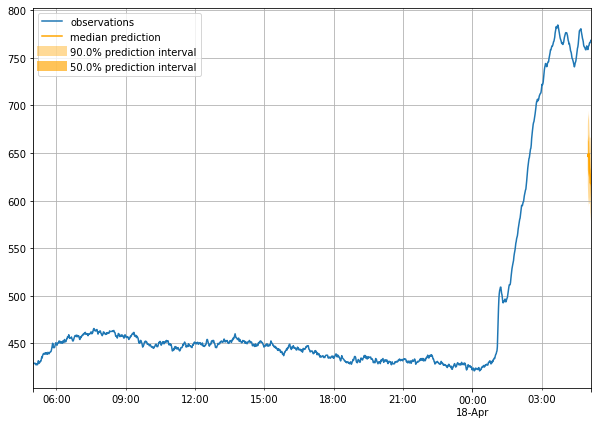

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 05:10:00
Frequency of the time series: 1Min
Mean of the future window:
 [660.33417 658.48737 647.18427 647.0124  644.666   638.1379  616.2134
 608.04956 609.39417 605.3893 ]
0.5-quantile (median) of the future window:
 [656.62463 657.34344 651.8322  650.16156 646.0475  637.7519  613.6171
 609.7802  610.68726 604.8768 ]
target_value:
 [[770.     767.1667 767.     769.5    772.2    774.     772.6667 773.5
  774.5    775.5   ]]


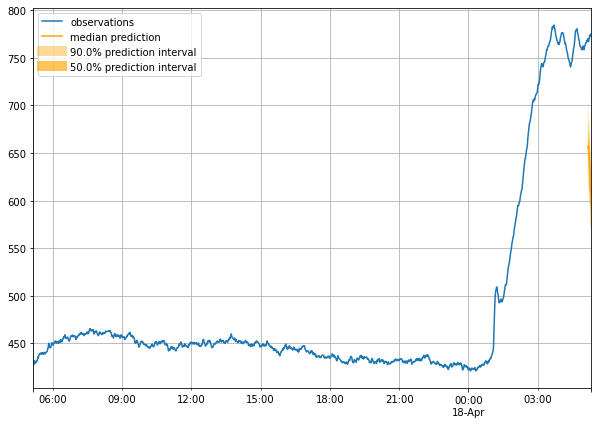

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 05:20:00
Frequency of the time series: 1Min
Mean of the future window:
 [654.98486 652.22656 651.0051  649.0143  646.19824 643.6982  642.372
 607.0496  619.1347  598.2948 ]
0.5-quantile (median) of the future window:
 [656.0552  653.9523  651.0522  647.8309  647.6635  641.54254 642.9919
 606.5542  620.0168  605.94507]
target_value:
 [[775.     773.     771.     770.5    769.6667 770.     770.     769.
  766.8    767.    ]]


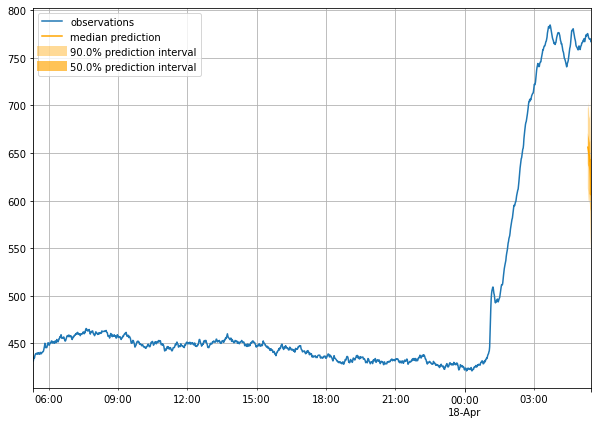

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 05:30:00
Frequency of the time series: 1Min
Mean of the future window:
 [641.5543  645.0994  606.96674 614.6721  627.0209  619.6885  622.1284
 619.6292  623.7317  621.24475]
0.5-quantile (median) of the future window:
 [639.80475 653.5755  604.9048  614.6607  623.9121  618.50476 619.3931
 622.5984  624.03925 624.252  ]
target_value:
 [[767.3333 766.     769.     769.5    769.5    771.5    770.5    768.
  766.     766.6667]]


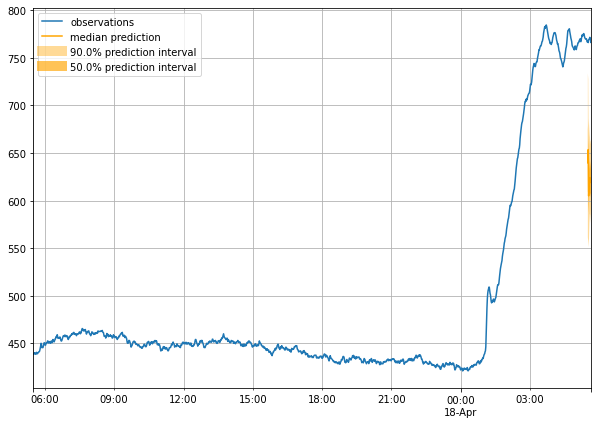

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 05:40:00
Frequency of the time series: 1Min
Mean of the future window:
 [663.6418  668.6738  669.1047  665.8028  655.5762  656.79376 654.7098
 651.5221  647.47516 645.2777 ]
0.5-quantile (median) of the future window:
 [666.7233  668.71246 668.9493  668.62335 656.57025 656.11426 656.883
 651.8122  646.5831  644.2184 ]
target_value:
 [[767.  767.  766.  765.  764.5 761.  759.5 755.5 754.  754. ]]


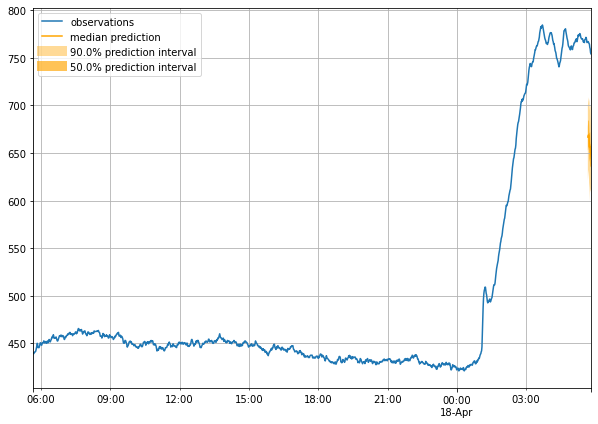

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 05:50:00
Frequency of the time series: 1Min
Mean of the future window:
 [672.17267 666.25104 667.8538  662.10077 658.37646 655.1379  651.4765
 650.4457  643.1396  643.1289 ]
0.5-quantile (median) of the future window:
 [669.8208  666.4772  669.57794 662.973   658.8888  652.2408  649.3911
 649.91284 647.60846 642.4393 ]
target_value:
 [[753.3333 751.5    749.5    747.5    747.5    748.     746.     743.5
  741.5    740.    ]]


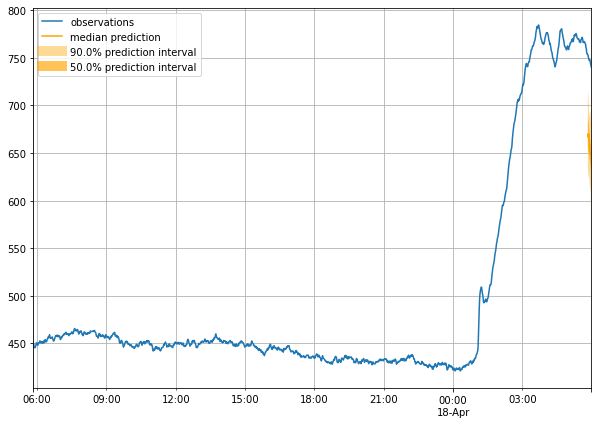

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 06:00:00
Frequency of the time series: 1Min
Mean of the future window:
 [665.0387  668.7403  660.59033 664.82874 659.5261  656.5832  654.5421
 650.6543  646.45056 644.6855 ]
0.5-quantile (median) of the future window:
 [667.2558  667.47253 662.96906 662.2369  662.0621  655.44275 653.4076
 649.40063 647.8386  645.8746 ]
target_value:
 [[738.3333 736.     736.5    734.5    732.     731.3333 729.5    726.1667
  724.6    726.    ]]


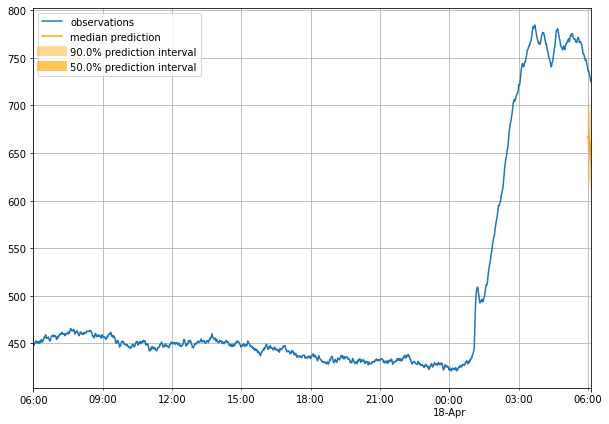

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 06:10:00
Frequency of the time series: 1Min
Mean of the future window:
 [668.6877  665.03546 663.62976 663.3406  658.59296 652.0813  650.3017
 652.75287 651.1752  645.90314]
0.5-quantile (median) of the future window:
 [667.86884 664.61993 665.0798  661.2603  660.93634 651.76886 651.67737
 652.77454 648.4334  644.53625]
target_value:
 [[724.     721.5    719.5    718.3333 717.     715.6667 716.5    717.5
  717.8    720.5   ]]


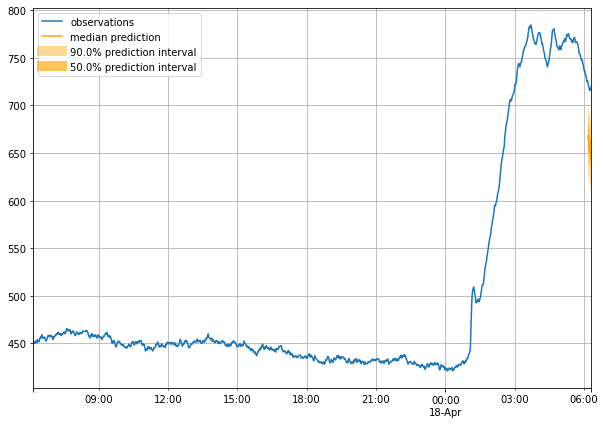

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 06:20:00
Frequency of the time series: 1Min
Mean of the future window:
 [663.61584 661.2921  664.6266  662.82874 655.765   655.09125 651.6843
 648.8939  647.5481  642.7315 ]
0.5-quantile (median) of the future window:
 [663.3468  663.5638  661.85645 658.4843  656.5483  656.9826  650.5575
 652.3816  649.0573  641.85205]
target_value:
 [[722.5    721.5    721.5    721.6667 721.5    723.5    724.6    725.5
  726.5    724.4   ]]


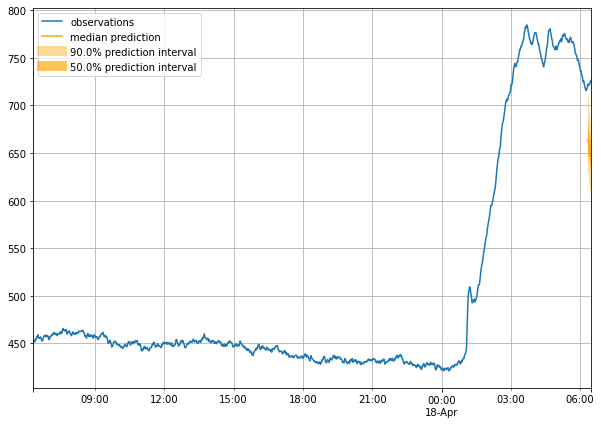

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 06:30:00
Frequency of the time series: 1Min
Mean of the future window:
 [663.42    662.009   664.0628  662.1657  660.6838  658.35834 655.7446
 654.8678  651.8427  648.13226]
0.5-quantile (median) of the future window:
 [662.1837  661.0337  663.82227 661.0445  662.733   656.8043  654.3347
 653.95984 655.19305 651.932  ]
target_value:
 [[724.     723.     724.4    726.     725.     725.     724.6667 723.6667
  722.     720.3333]]


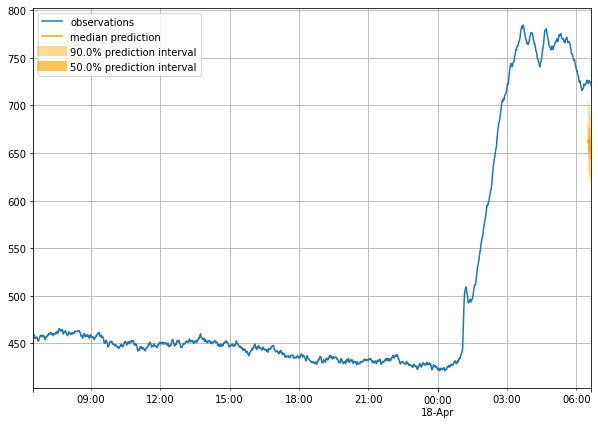

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 06:40:00
Frequency of the time series: 1Min
Mean of the future window:
 [671.9183  664.0009  667.1371  668.45135 667.5364  660.42413 664.44586
 657.9572  648.402   653.0563 ]
0.5-quantile (median) of the future window:
 [669.84644 668.7595  665.3882  667.82306 666.64716 658.15894 662.9419
 658.1671  648.0711  653.9899 ]
target_value:
 [[717.5 714.  711.5 713.  713.5 715.  714.  713.2 713.  712.4]]


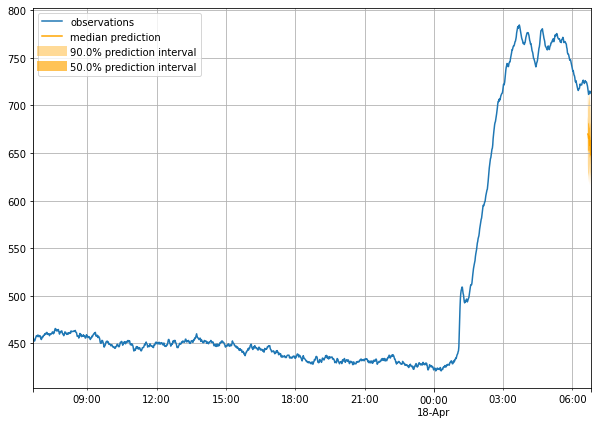

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 06:50:00
Frequency of the time series: 1Min
Mean of the future window:
 [664.02966 665.97107 664.0895  661.21533 659.9289  654.90515 654.25446
 648.6311  648.7088  647.275  ]
0.5-quantile (median) of the future window:
 [666.162   665.5273  664.012   657.92834 658.39526 657.6675  656.4193
 648.65845 649.9721  648.2124 ]
target_value:
 [[714.     714.5    713.     716.     718.3333 718.5    719.     719.
  721.5    724.5   ]]


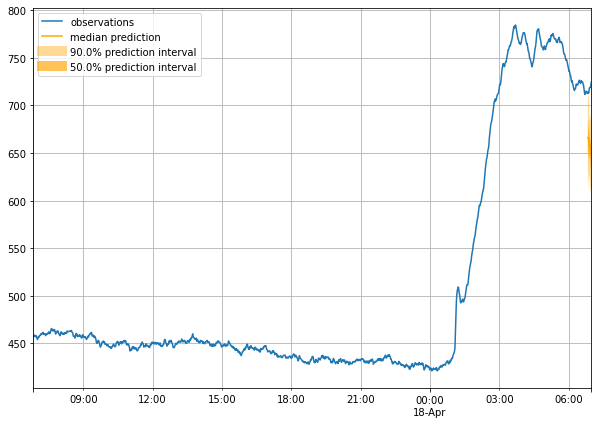

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 07:00:00
Frequency of the time series: 1Min
Mean of the future window:
 [665.24695 668.9331  664.20984 662.3398  654.80396 653.8857  650.8279
 651.6294  647.92944 646.2678 ]
0.5-quantile (median) of the future window:
 [666.42224 669.95526 663.32794 662.5017  655.4675  657.89105 650.73425
 651.6281  647.45483 647.04663]
target_value:
 [[727.  729.5 732.5 738.  746.  750.5 753.5 757.  760.2 763. ]]


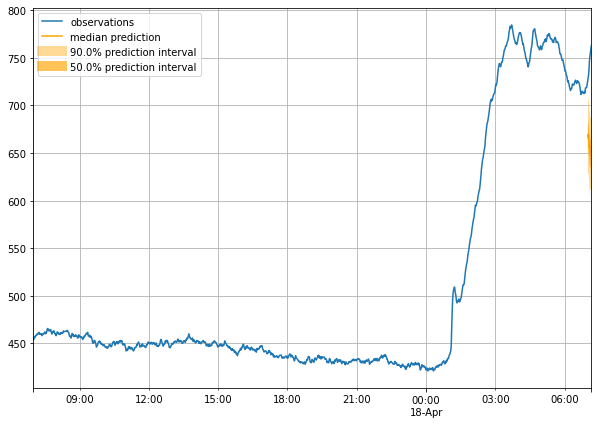

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 07:10:00
Frequency of the time series: 1Min
Mean of the future window:
 [671.9617  671.55695 667.95404 665.7709  668.0867  657.8321  654.9503
 635.0836  657.76086 623.86615]
0.5-quantile (median) of the future window:
 [671.10706 671.85114 666.54126 666.68726 669.51855 657.6843  655.20917
 637.0249  655.8103  627.7234 ]
target_value:
 [[765.5 766.5 767.4 770.  770.5 771.8 775.5 779.5 781.  783.5]]


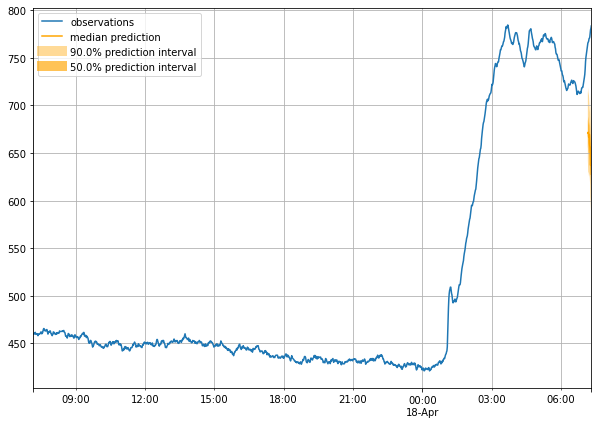

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 07:20:00
Frequency of the time series: 1Min
Mean of the future window:
 [657.0592  663.0554  662.62006 661.9111  658.1653  655.8275  651.1484
 650.52295 645.2599  650.0854 ]
0.5-quantile (median) of the future window:
 [659.9265  665.8492  661.86487 660.4567  659.01666 655.007   648.4011
 651.297   646.3051  653.8918 ]
target_value:
 [[785.     787.     789.     788.5    790.5    790.3333 790.     790.3333
  789.     786.5   ]]


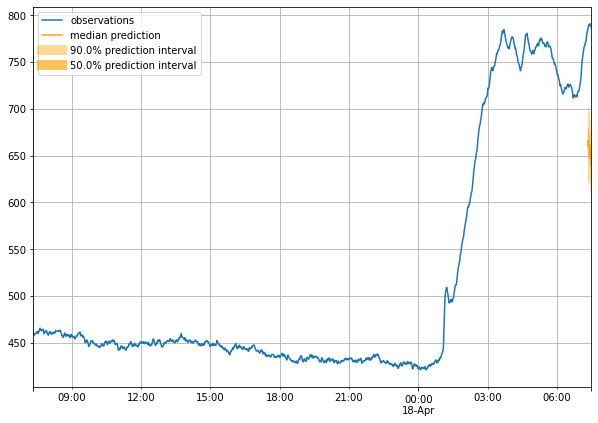

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 07:30:00
Frequency of the time series: 1Min
Mean of the future window:
 [687.83545 681.3133  687.90924 675.7322  676.8389  677.21594 671.92084
 667.36163 665.24963 660.9977 ]
0.5-quantile (median) of the future window:
 [688.7859  686.65    683.64404 678.79706 675.7456  673.6939  674.4413
 668.30994 670.1708  662.9638 ]
target_value:
 [[788.5    788.     786.5    784.     782.     779.     776.     774.
  772.     769.1667]]


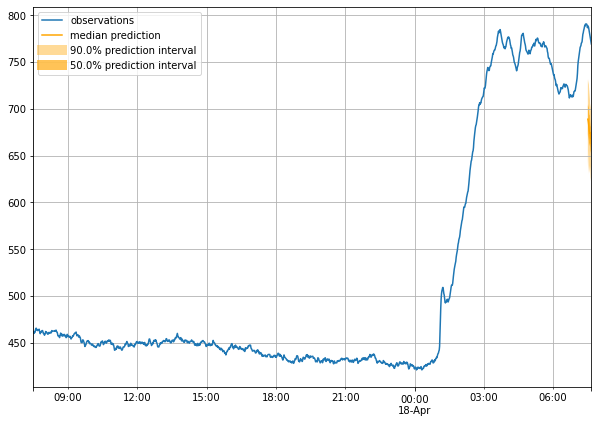

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 07:40:00
Frequency of the time series: 1Min
Mean of the future window:
 [689.70544 688.0051  685.72656 679.9144  674.8011  671.8592  668.7255
 666.0876  658.9461  656.2086 ]
0.5-quantile (median) of the future window:
 [690.51685 687.0162  683.9912  679.48474 674.8126  673.8948  668.2186
 667.0688  658.6816  658.3659 ]
target_value:
 [[768.     765.     763.     763.6667 762.5    761.5    759.     761.3333
  760.5    760.5   ]]


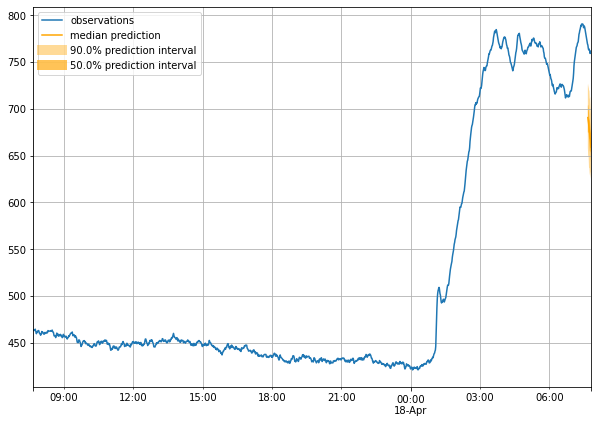

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 07:50:00
Frequency of the time series: 1Min
Mean of the future window:
 [683.6064  685.18304 661.80743 678.99634 644.8422  640.2424  635.05743
 636.2404  636.94214 632.313  ]
0.5-quantile (median) of the future window:
 [684.4025  686.5096  663.4358  678.2794  645.8515  639.06036 633.031
 636.4952  638.4368  630.8616 ]
target_value:
 [[758.4 759.  759.  761.  762.  760.5 756.4 755.  753.5 754. ]]


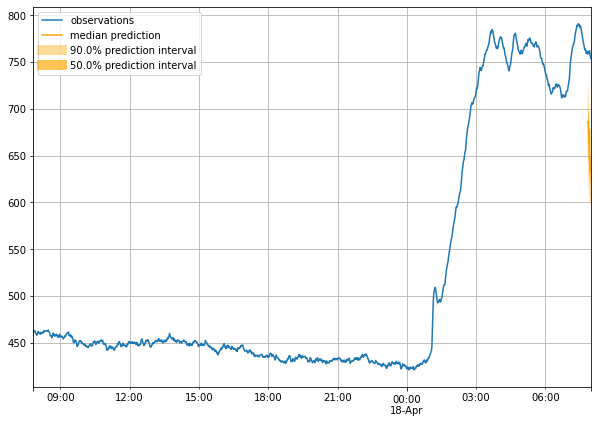

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 08:00:00
Frequency of the time series: 1Min
Mean of the future window:
 [670.36414 669.47534 668.55225 659.96326 665.32    662.835   659.60065
 654.46783 651.1936  651.41974]
0.5-quantile (median) of the future window:
 [667.2521  673.1314  670.2595  661.8266  667.4231  665.62494 661.0886
 651.7936  652.181   652.2957 ]
target_value:
 [[754.  754.5 754.4 752.5 752.5 751.5 754.  756.  758.5 758.5]]


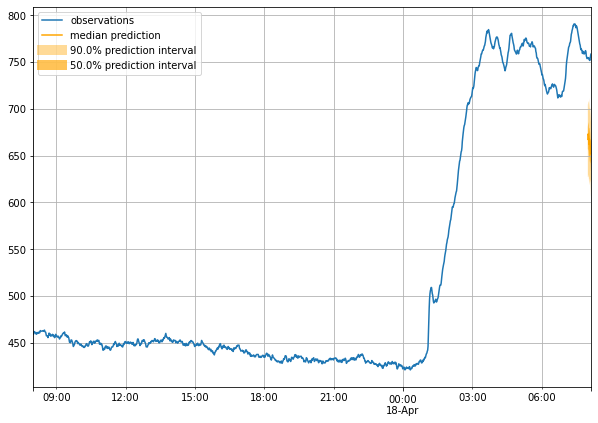

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 08:10:00
Frequency of the time series: 1Min
Mean of the future window:
 [677.9919  675.06274 676.0776  675.02795 673.00854 664.80096 667.8398
 657.76086 661.971   659.30133]
0.5-quantile (median) of the future window:
 [677.99927 677.8776  675.8726  674.8029  672.3659  664.93463 666.72284
 658.7395  660.4965  659.7457 ]
target_value:
 [[759.3333 757.6667 757.3333 758.3333 759.     761.     760.     760.3333
  762.5    766.    ]]


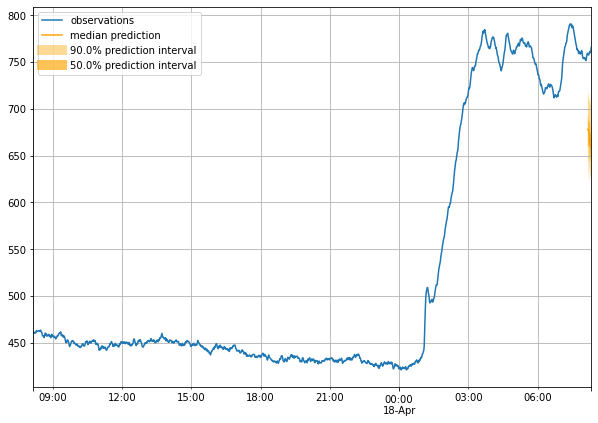

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 08:20:00
Frequency of the time series: 1Min
Mean of the future window:
 [685.4811  690.4668  682.2154  678.62244 683.8244  676.3876  666.36475
 686.7718  667.9631  662.057  ]
0.5-quantile (median) of the future window:
 [684.48975 686.4551  681.52985 679.018   686.0816  677.1081  664.3332
 685.93713 669.5599  660.6744 ]
target_value:
 [[766.5    767.     769.     771.     773.     773.6667 776.5    779.8
  783.     787.    ]]


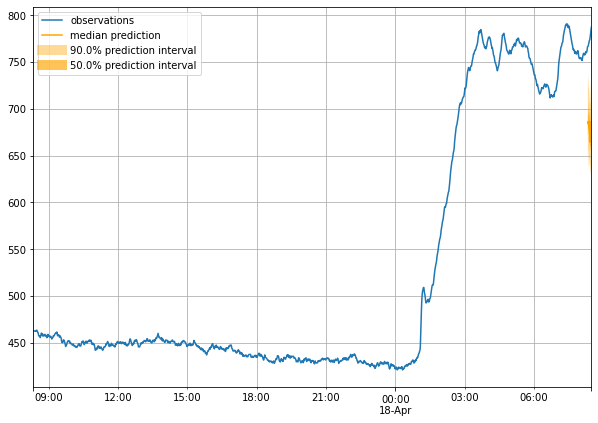

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 08:30:00
Frequency of the time series: 1Min
Mean of the future window:
 [689.9416  691.6979  694.74976 683.1526  683.80084 679.35425 678.3543
 676.77057 667.19763 669.7154 ]
0.5-quantile (median) of the future window:
 [691.5417  695.1189  695.1551  683.46576 684.8249  680.97375 678.81335
 679.24817 666.3497  671.4082 ]
target_value:
 [[790.  791.5 794.  792.4 792.  791.  793.  792.5 792.  791. ]]


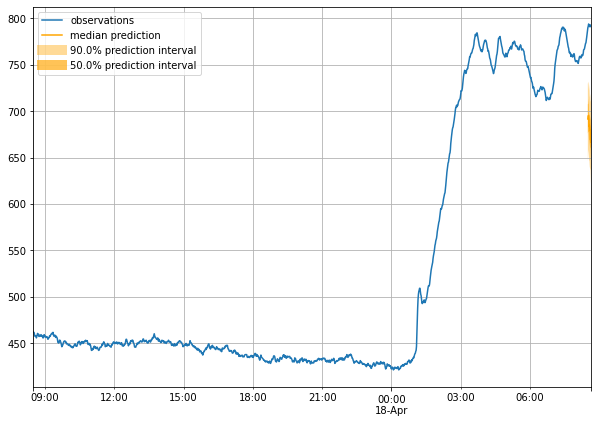

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 08:40:00
Frequency of the time series: 1Min
Mean of the future window:
 [700.54694 695.0119  695.67126 687.2773  683.48206 677.9143  670.28204
 672.87286 664.1697  660.37524]
0.5-quantile (median) of the future window:
 [701.2217  696.87354 693.416   689.3218  685.8259  679.65924 673.5151
 671.3234  662.8051  661.39386]
target_value:
 [[791.     792.5    791.6667 793.3333 793.3333 794.5    797.5    798.
  795.5    796.5   ]]


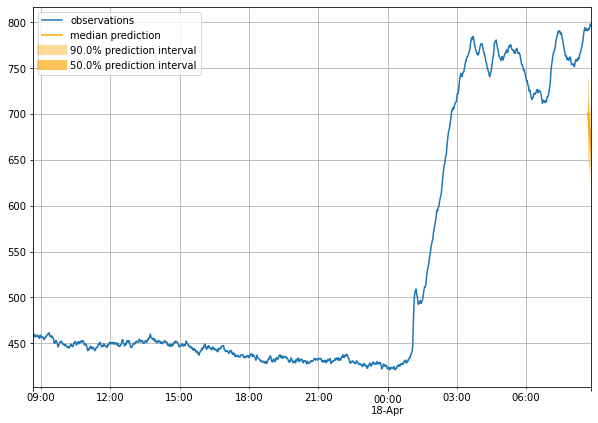

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 08:50:00
Frequency of the time series: 1Min
Mean of the future window:
 [694.01337 691.50085 688.7674  688.14374 678.229   681.8917  674.04266
 672.5037  662.79865 664.76227]
0.5-quantile (median) of the future window:
 [693.28253 694.3851  689.9249  688.18445 679.5356  683.3584  673.2074
 672.71564 663.29205 665.65247]
target_value:
 [[797.1667 797.5    796.8    795.3333 796.3333 793.5    791.5    791.5
  791.     788.5   ]]


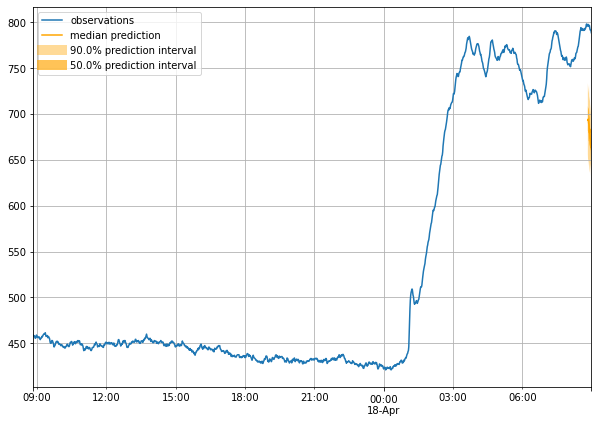

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 09:00:00
Frequency of the time series: 1Min
Mean of the future window:
 [696.0348  697.02466 692.8457  688.3652  685.9615  679.2278  679.9309
 674.793   670.0745  666.0834 ]
0.5-quantile (median) of the future window:
 [694.5528  698.9611  696.5802  688.6423  688.4323  681.86743 680.6417
 675.6553  674.7424  669.02795]
target_value:
 [[785.     784.     786.5    787.6667 786.5    787.     786.5    786.5
  788.5    790.3333]]


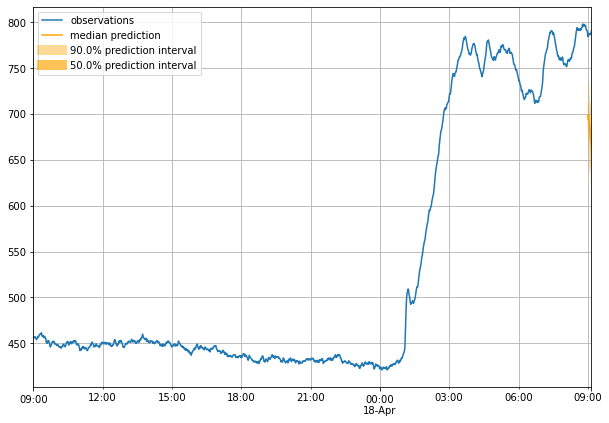

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 09:10:00
Frequency of the time series: 1Min
Mean of the future window:
 [704.0098  703.33234 695.55743 697.5051  684.3549  686.3519  683.5966
 684.1353  679.6647  673.25635]
0.5-quantile (median) of the future window:
 [705.11554 702.19995 699.91907 698.46063 688.1743  687.16144 680.6328
 685.2908  680.5053  673.6639 ]
target_value:
 [[790.  791.  793.  795.  795.5 796.5 799.  800.  797.  794.5]]


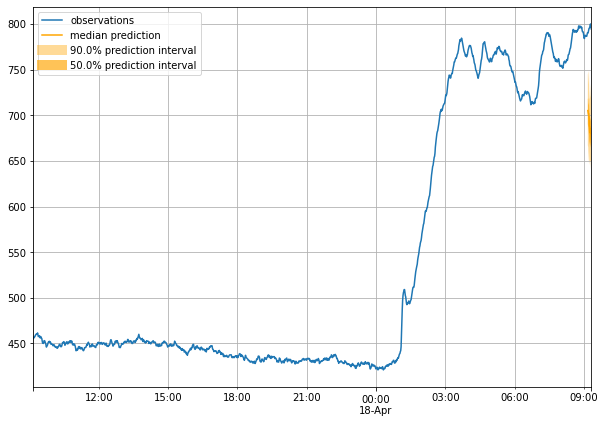

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 09:20:00
Frequency of the time series: 1Min
Mean of the future window:
 [703.2541  705.0608  705.9869  698.63367 701.5607  697.2018  694.68475
 690.58966 682.69055 682.24884]
0.5-quantile (median) of the future window:
 [706.9195  708.50275 705.84344 701.71564 700.72644 697.8278  692.7346
 693.66504 685.5152  685.44476]
target_value:
 [[792.6667 792.     793.3333 793.5    792.     791.     791.6667 790.
  789.6667 789.    ]]


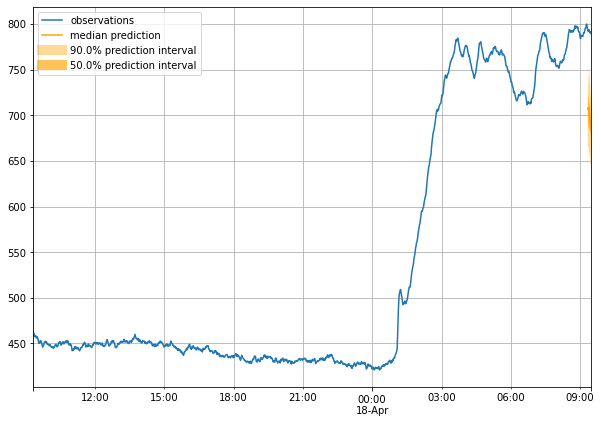

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 09:30:00
Frequency of the time series: 1Min
Mean of the future window:
 [712.71075 711.21686 713.7859  706.5411  705.82166 700.89185 698.4973
 690.47015 688.47144 685.48456]
0.5-quantile (median) of the future window:
 [713.55524 711.93005 713.2648  707.5154  705.36017 700.4913  699.0821
 691.20935 686.7559  685.43134]
target_value:
 [[791.5    795.5    799.     802.5    805.5    810.     815.5    819.8333
  823.2    825.5   ]]


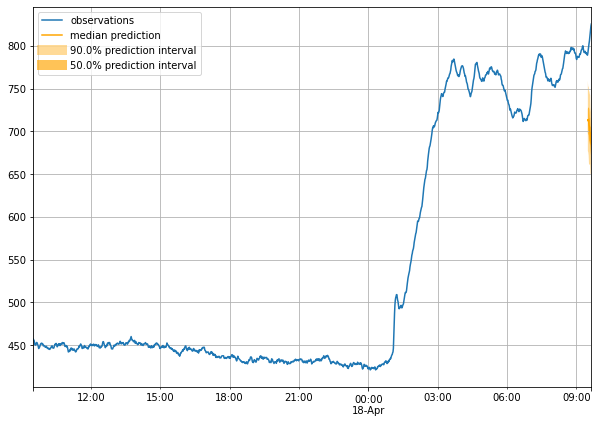

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 09:40:00
Frequency of the time series: 1Min
Mean of the future window:
 [717.6328  716.8359  713.6025  711.2596  706.7793  706.7035  701.5886
 694.23413 690.45197 688.7703 ]
0.5-quantile (median) of the future window:
 [716.15906 715.1026  711.1771  712.14197 704.5795  703.6048  700.9219
 693.74304 690.0557  689.8078 ]
target_value:
 [[827.5    829.     831.     830.1667 830.     830.3333 828.5    826.6667
  825.5    823.5   ]]


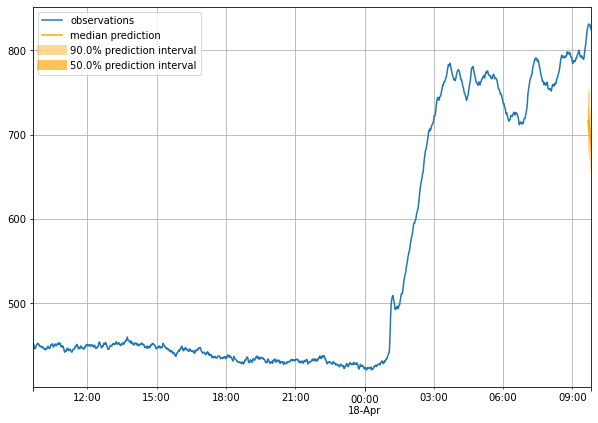

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 09:50:00
Frequency of the time series: 1Min
Mean of the future window:
 [723.30634 726.4675  720.69806 716.7584  716.32153 706.7349  702.4986
 695.7251  695.1411  685.0814 ]
0.5-quantile (median) of the future window:
 [723.098   726.6539  719.24097 717.641   716.9799  706.1615  702.02136
 696.65955 693.47626 686.36127]
target_value:
 [[824.  821.5 818.5 816.5 812.5 809.  806.2 803.5 801.  798. ]]


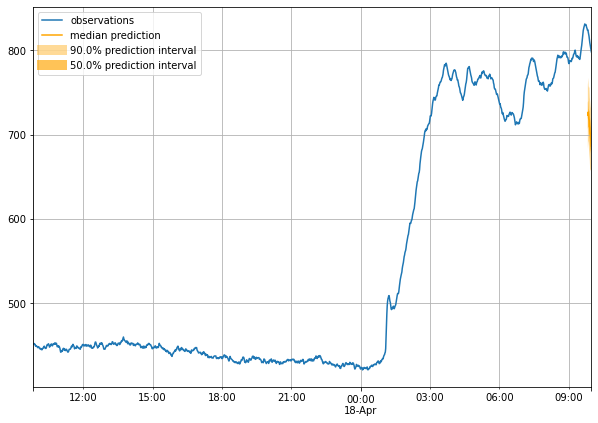

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 10:00:00
Frequency of the time series: 1Min
Mean of the future window:
 [720.16693 715.1294  714.8821  708.7911  706.09393 704.01874 695.849
 688.3075  688.8664  690.0877 ]
0.5-quantile (median) of the future window:
 [716.15283 716.233   716.5885  711.6853  708.0466  703.13544 696.0123
 688.92267 692.28766 688.0949 ]
target_value:
 [[794.5  790.   785.5  782.2  777.5  772.5  768.   762.75 757.   751.5 ]]


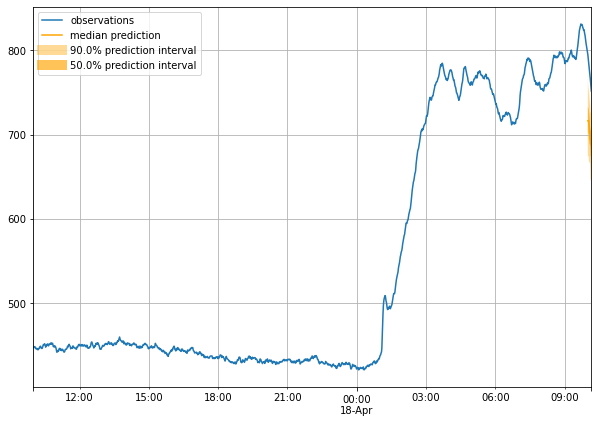

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 10:10:00
Frequency of the time series: 1Min
Mean of the future window:
 [709.30804 707.33826 702.4255  699.2315  696.16156 695.7941  693.1382
 690.41345 689.5887  687.6892 ]
0.5-quantile (median) of the future window:
 [710.1901  707.94714 701.5127  700.81335 697.76904 697.0239  692.9549
 691.74304 690.69476 686.047  ]
target_value:
 [[747.5    745.     745.5    743.6667 742.     741.5    742.     744.
  744.5    747.    ]]


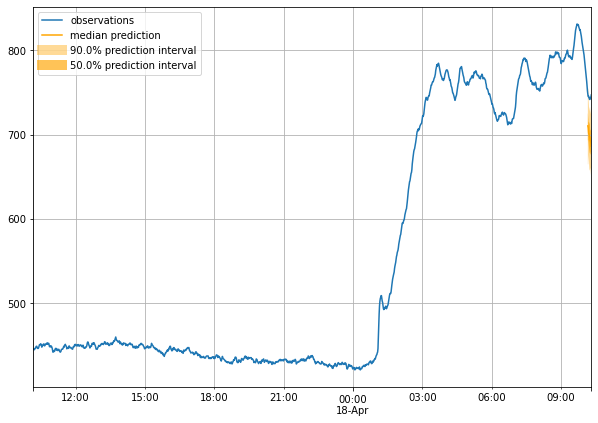

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 10:20:00
Frequency of the time series: 1Min
Mean of the future window:
 [696.65283 697.0268  696.7078  694.8237  691.76447 689.53595 685.1525
 683.56366 680.0134  680.66   ]
0.5-quantile (median) of the future window:
 [696.5922  695.93164 696.3037  693.77216 691.9365  690.93506 685.88885
 687.2967  680.54034 680.11993]
target_value:
 [[747.3333 747.3333 747.5    749.5    750.     750.     750.     748.
  749.8333 753.    ]]


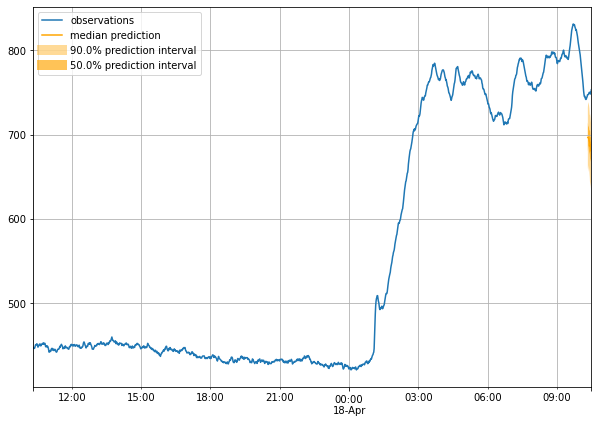

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 10:30:00
Frequency of the time series: 1Min
Mean of the future window:
 [686.81165 667.9643  680.5256  704.3308  700.2382  662.116   623.1957
 638.87    638.25006 642.614  ]
0.5-quantile (median) of the future window:
 [686.7746  668.51685 676.37604 701.15283 702.1122  658.1147  624.2502
 637.19916 639.5027  644.854  ]
target_value:
 [[755.     758.1667 757.     758.5    761.     763.     763.     764.5
  764.5    767.    ]]


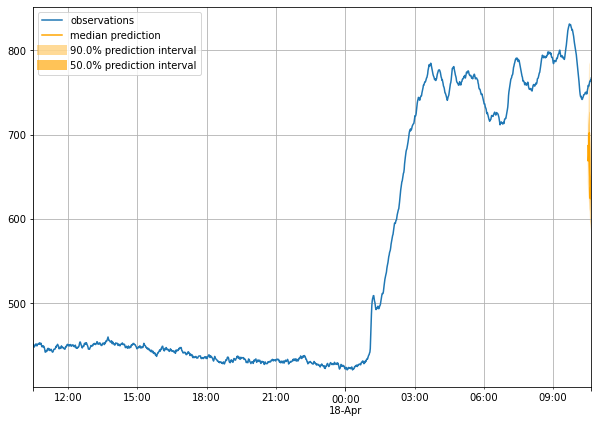

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 10:40:00
Frequency of the time series: 1Min
Mean of the future window:
 [681.64874 680.06213 688.6886  688.4411  684.6398  684.7177  681.964
 682.3011  678.057   680.613  ]
0.5-quantile (median) of the future window:
 [679.24805 678.2256  688.3302  687.55005 689.0999  686.2486  683.85504
 683.4143  677.4891  681.9561 ]
target_value:
 [[770.     770.3333 768.     766.5    766.5    764.     761.     758.6667
  758.     757.5   ]]


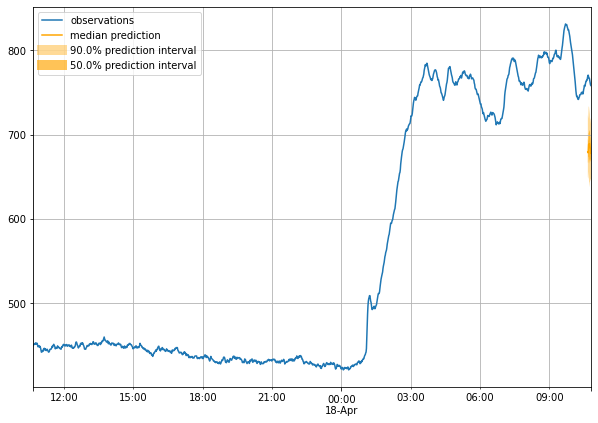

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 10:50:00
Frequency of the time series: 1Min
Mean of the future window:
 [716.4869  710.72    700.9221  702.46545 701.683   699.30505 696.5739
 693.9882  689.4643  685.55853]
0.5-quantile (median) of the future window:
 [716.1516  713.8626  704.5409  704.33777 703.95966 701.7753  694.2055
 693.34393 689.5097  685.353  ]
target_value:
 [[756.  752.5 749.  747.5 747.  746.5 745.5 746.5 746.5 748.5]]


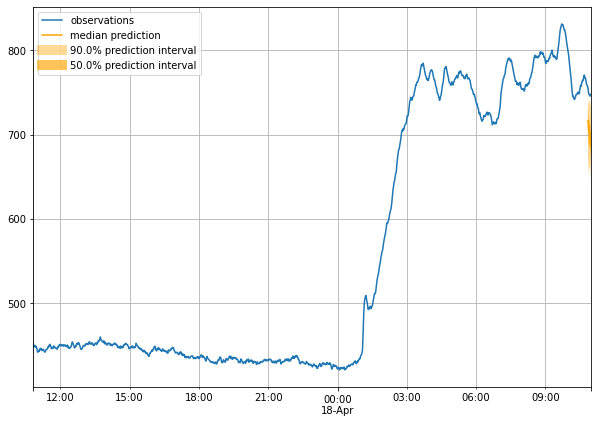

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 11:00:00
Frequency of the time series: 1Min
Mean of the future window:
 [699.1886  694.7045  695.00024 697.5051  690.31836 689.10486 680.7266
 683.6929  681.21985 672.2636 ]
0.5-quantile (median) of the future window:
 [697.3151  695.5145  698.1753  695.70264 691.29834 686.2156  682.6024
 681.81396 680.3008  669.56476]
target_value:
 [[749.6667 749.3333 748.5    749.5    747.5    746.5    745.6667 746.
  746.5    748.    ]]


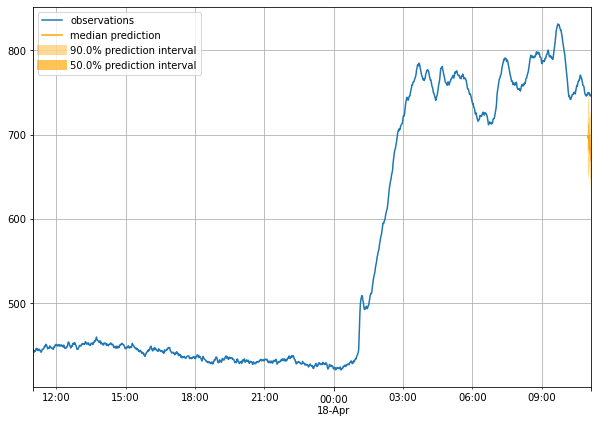

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 11:10:00
Frequency of the time series: 1Min
Mean of the future window:
 [693.8222  694.80023 693.49054 689.65906 682.6808  682.5056  683.67456
 677.6692  676.96857 671.269  ]
0.5-quantile (median) of the future window:
 [696.0397  693.6435  691.8185  687.4117  682.8545  682.59674 680.3697
 676.59204 674.39264 672.51074]
target_value:
 [[749.5    751.     751.     750.     751.     749.1667 747.     747.5
  747.5    744.6667]]


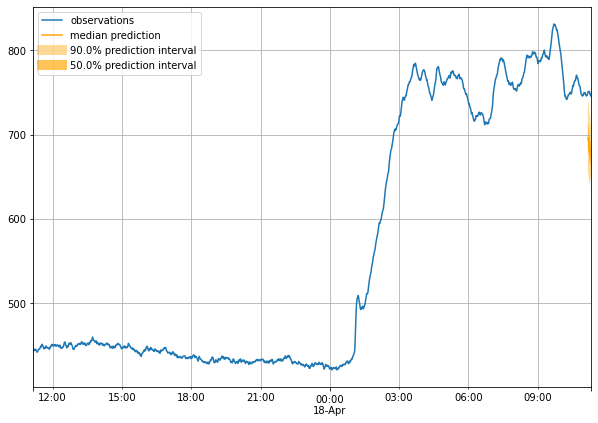

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 11:20:00
Frequency of the time series: 1Min
Mean of the future window:
 [691.1252  695.5987  693.0545  693.22034 661.843   717.9828  719.05994
 629.14575 664.2506  664.5887 ]
0.5-quantile (median) of the future window:
 [689.8636  694.8277  690.107   695.45245 663.32074 719.57935 722.2525
 630.2586  660.9059  662.4825 ]
target_value:
 [[746.     745.     743.     742.3333 740.5    739.     739.5    741.
  741.5    741.6   ]]


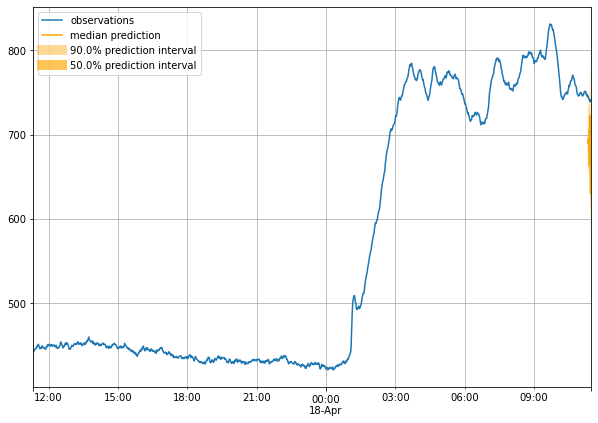

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 11:30:00
Frequency of the time series: 1Min
Mean of the future window:
 [682.3606  683.10803 682.50415 684.35767 677.7606  681.70557 676.7882
 679.08655 679.2458  668.9372 ]
0.5-quantile (median) of the future window:
 [681.16516 683.7945  682.2778  686.53534 676.5915  685.0069  673.6922
 676.76483 679.61005 671.6061 ]
target_value:
 [[740.5 741.5 743.5 745.5 744.  743.5 741.5 738.4 738.5 738.5]]


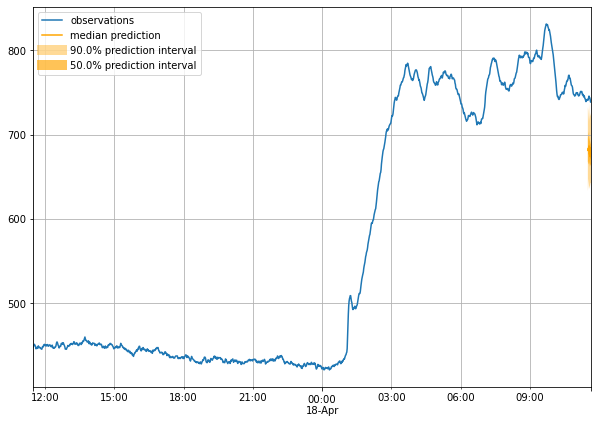

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 11:40:00
Frequency of the time series: 1Min
Mean of the future window:
 [694.9157  695.7771  693.94147 694.4934  694.4685  683.892   686.02875
 680.81256 677.8361  676.31024]
0.5-quantile (median) of the future window:
 [694.873   697.46735 697.71027 692.8098  692.41077 683.8343  684.4456
 681.6816  678.4876  677.5365 ]
target_value:
 [[737.5    735.5    731.5    729.     728.     727.3333 726.5    726.
  724.5    725.    ]]


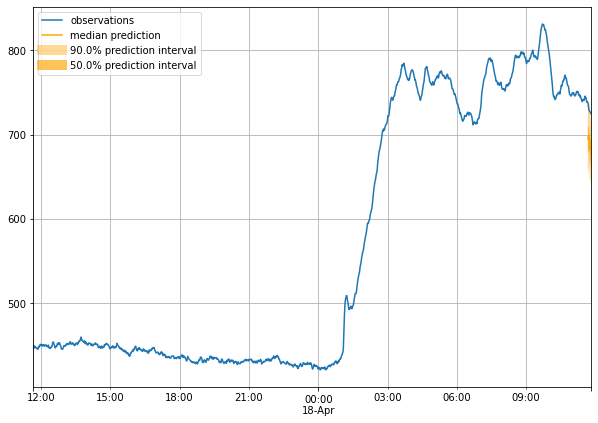

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 11:50:00
Frequency of the time series: 1Min
Mean of the future window:
 [695.3831  689.39233 689.6287  683.24475 682.2414  681.42456 679.895
 672.4375  671.7107  668.6764 ]
0.5-quantile (median) of the future window:
 [694.16626 688.3041  688.1758  682.8801  680.9464  681.7094  680.61865
 671.4747  673.436   668.7154 ]
target_value:
 [[725.  725.5 726.  723.  721.5 723.  725.  723.5 721.5 721.5]]


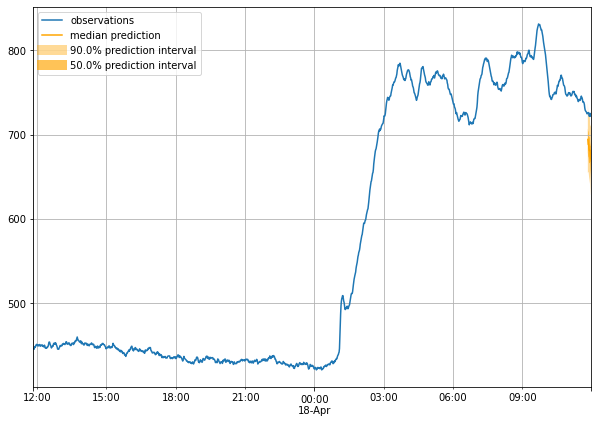

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 12:00:00
Frequency of the time series: 1Min
Mean of the future window:
 [683.49335 679.32654 680.1946  673.2763  673.1666  673.17993 666.8106
 657.1746  660.75916 656.72833]
0.5-quantile (median) of the future window:
 [681.6127  681.94366 680.7659  678.24384 674.00256 670.86304 667.04456
 658.79767 661.5422  657.87946]
target_value:
 [[721.5    720.3333 719.     718.5    717.     716.     713.5    711.5
  709.2    705.    ]]


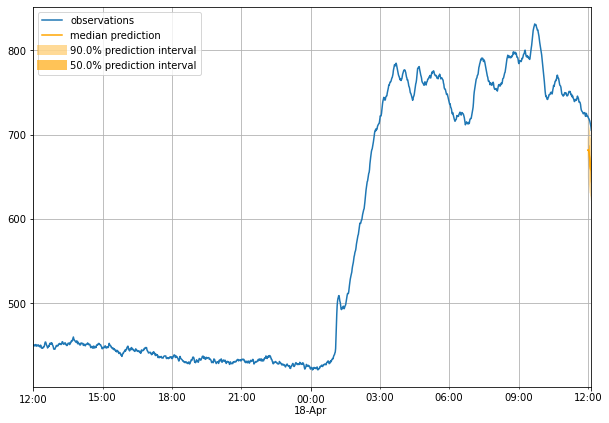

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 12:10:00
Frequency of the time series: 1Min
Mean of the future window:
 [673.6814  668.8024  664.8158  668.2571  664.88696 658.66327 657.0132
 656.0076  651.1367  647.35065]
0.5-quantile (median) of the future window:
 [673.24774 671.62256 667.1933  669.7397  665.67346 659.6637  657.15125
 653.97296 649.06995 648.98517]
target_value:
 [[704.3333 704.5    702.5    703.     704.     703.     703.     702.5
  701.     698.5   ]]


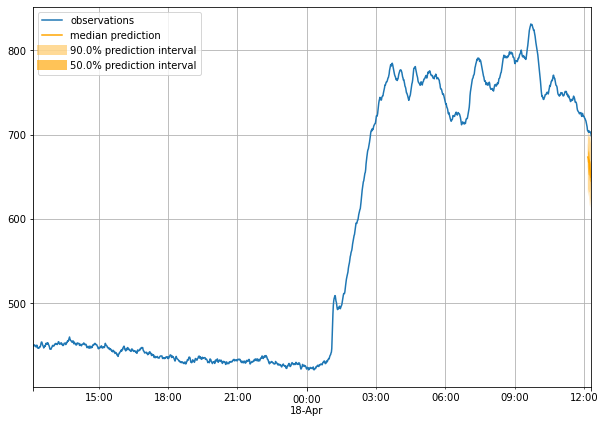

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 12:20:00
Frequency of the time series: 1Min
Mean of the future window:
 [662.0419  664.24615 659.31885 656.3632  657.68134 648.95984 649.864
 644.92163 644.33124 643.33826]
0.5-quantile (median) of the future window:
 [662.3989  660.5697  657.9855  656.67365 656.9655  649.999   653.95557
 645.1431  643.85315 644.77264]
target_value:
 [[697.5 696.  697.  696.5 695.5 693.  693.  692.5 695.  693.5]]


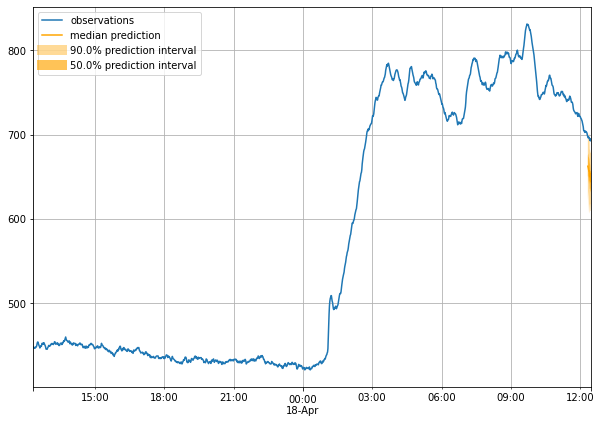

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 12:30:00
Frequency of the time series: 1Min
Mean of the future window:
 [657.0257  659.4606  657.8933  656.0977  653.83344 650.60815 653.5707
 647.1958  647.11084 646.13367]
0.5-quantile (median) of the future window:
 [657.9627  656.73944 659.2587  655.9633  656.01587 649.2541  651.2731
 646.2311  647.6955  645.566  ]
target_value:
 [[693.     691.5    690.5    690.5    689.3333 689.     687.5    686.5
  684.5    682.5   ]]


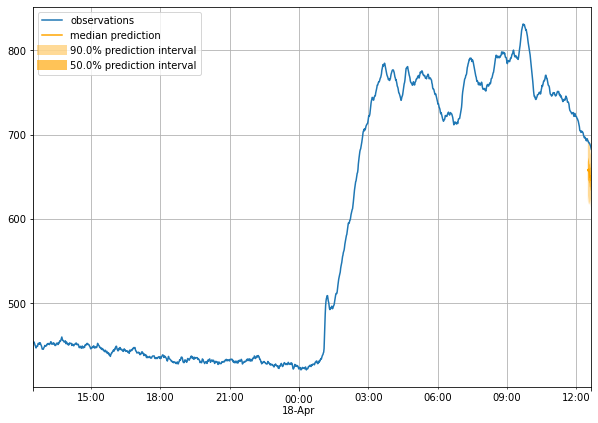

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 12:40:00
Frequency of the time series: 1Min
Mean of the future window:
 [655.0998  654.73517 653.92737 650.34283 648.84424 645.0046  641.95654
 640.53735 640.2234  642.5894 ]
0.5-quantile (median) of the future window:
 [654.72754 652.04065 653.8354  652.6214  651.1633  643.28564 641.0953
 640.0845  641.37274 642.4262 ]
target_value:
 [[680.6667 679.6667 681.8    680.3333 679.     677.     677.5    677.
  676.     673.6667]]


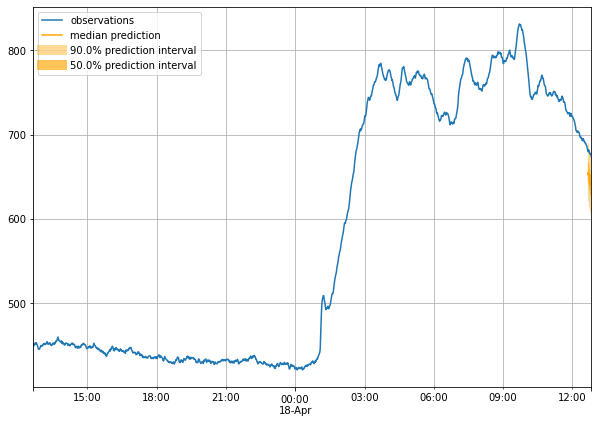

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 12:50:00
Frequency of the time series: 1Min
Mean of the future window:
 [654.3773  646.7052  645.30237 623.12286 602.4533  620.3374  608.1565
 604.4883  601.7608  604.0774 ]
0.5-quantile (median) of the future window:
 [654.0498  647.79333 644.7952  624.02966 601.85956 622.52515 609.04645
 603.3689  602.50525 604.61865]
target_value:
 [[674.     673.5    674.5    674.     674.5    674.     672.5    670.6667
  670.     670.    ]]


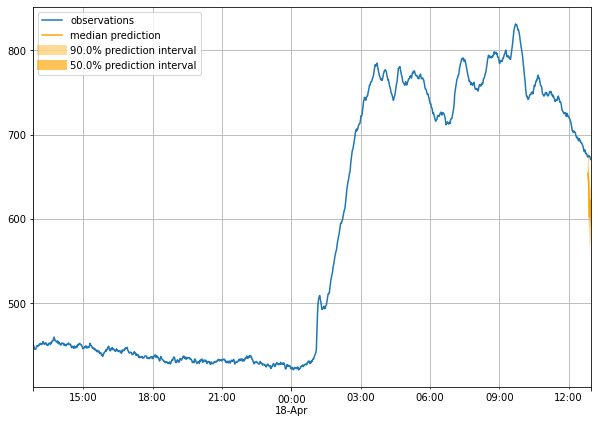

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 13:00:00
Frequency of the time series: 1Min
Mean of the future window:
 [619.95605 622.4816  624.225   619.5327  620.7222  623.9941  611.8298
 610.3589  607.0837  613.558  ]
0.5-quantile (median) of the future window:
 [618.67065 622.5493  621.1724  619.97955 621.44775 625.9395  612.76636
 610.18854 607.8844  612.15436]
target_value:
 [[669.6667 669.8    671.     668.     666.     666.     666.     666.5
  665.6    662.5   ]]


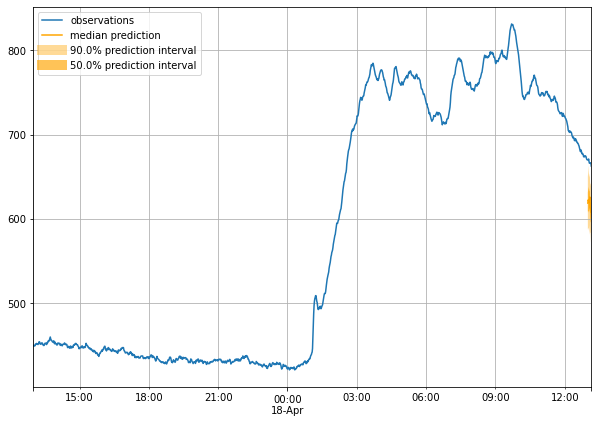

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 13:10:00
Frequency of the time series: 1Min
Mean of the future window:
 [626.7193  625.1157  625.14435 625.3687  622.2789  619.90546 615.3387
 612.1802  611.46295 610.67596]
0.5-quantile (median) of the future window:
 [626.2982  626.1367  626.64154 625.46484 625.4993  621.0165  614.10144
 613.4595  612.5504  609.8079 ]
target_value:
 [[662.5    663.5    663.5    663.3333 662.3333 660.5    659.     659.
  657.3333 657.    ]]


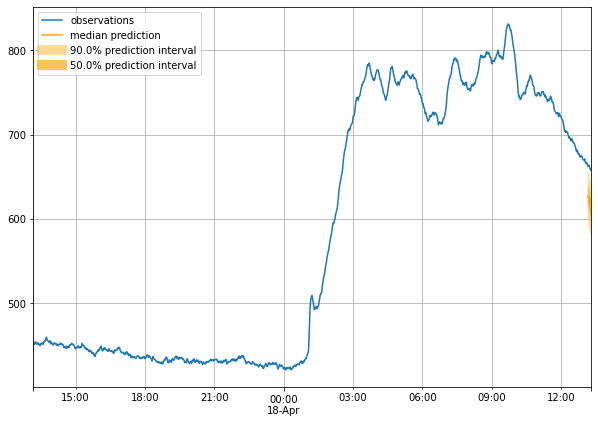

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 13:20:00
Frequency of the time series: 1Min
Mean of the future window:
 [625.5506  617.9161  620.88306 621.98334 616.77374 615.69116 616.7102
 608.2401  598.6308  594.4729 ]
0.5-quantile (median) of the future window:
 [626.15405 617.6292  620.7536  622.3042  619.0052  616.1319  620.13654
 607.9919  598.14246 595.71454]
target_value:
 [[655.3333 656.5    656.     655.5    654.     652.     650.     649.5
  649.6667 647.5   ]]


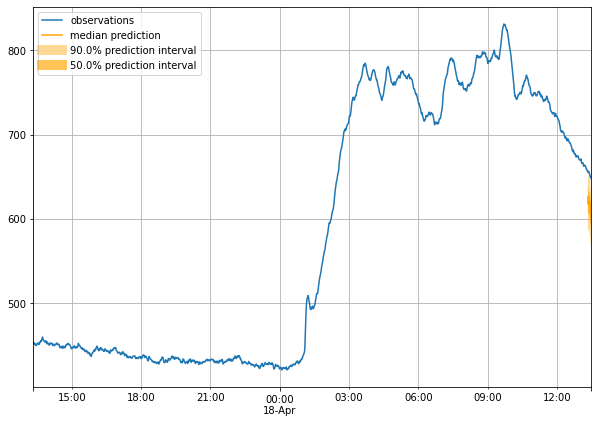

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 13:30:00
Frequency of the time series: 1Min
Mean of the future window:
 [606.5579  610.665   610.6027  613.507   606.6258  608.4129  605.40137
 602.8322  603.3183  600.0098 ]
0.5-quantile (median) of the future window:
 [609.9587  611.652   612.39307 612.41986 607.70496 607.33484 603.91327
 600.9355  602.8701  600.5149 ]
target_value:
 [[647.5    645.3333 645.2    644.5    645.     644.5    643.     640.5
  641.5    640.5   ]]


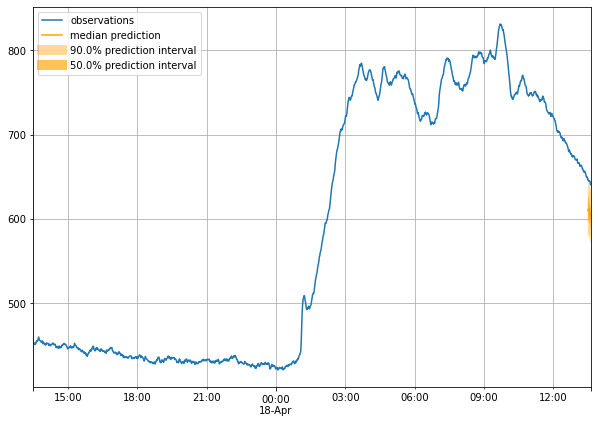

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 13:40:00
Frequency of the time series: 1Min
Mean of the future window:
 [611.57294 610.4803  608.1065  607.3477  603.5505  601.4479  602.0595
 598.07684 596.79346 573.5584 ]
0.5-quantile (median) of the future window:
 [611.5387  609.5863  610.2847  606.1187  604.5387  601.0579  602.4981
 599.88525 593.9878  573.6892 ]
target_value:
 [[639.5    640.     639.     638.5    638.6667 637.5    637.6    636.5
  635.4    637.5   ]]


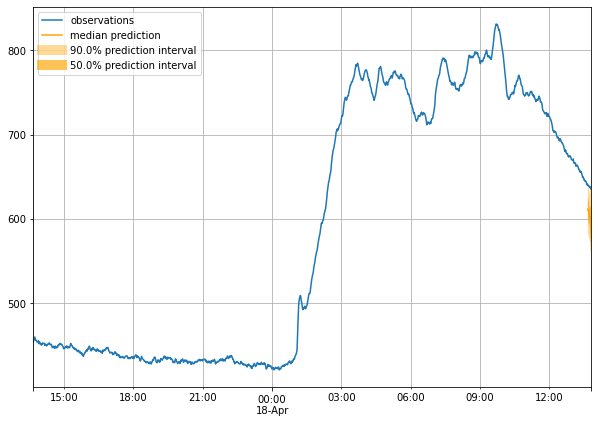

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 13:50:00
Frequency of the time series: 1Min
Mean of the future window:
 [625.214   613.94995 602.62604 598.16876 586.6227  588.21716 585.24805
 590.1486  586.6139  585.6768 ]
0.5-quantile (median) of the future window:
 [624.5752  616.446   603.41254 598.45013 585.7172  587.73303 586.04517
 589.29724 583.19354 586.2717 ]
target_value:
 [[636.3333 637.5    638.5    638.6    638.5    637.6    635.     633.5
  631.     632.    ]]


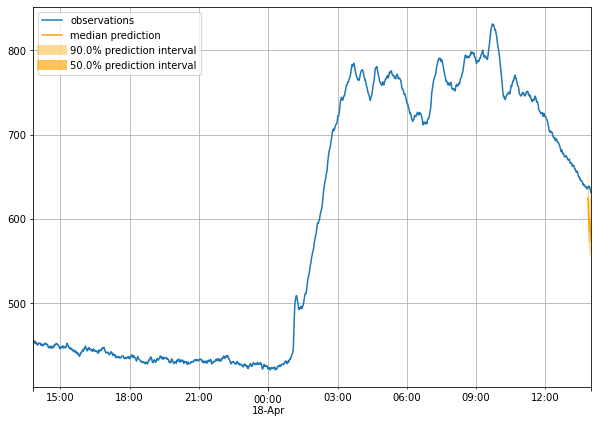

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 14:00:00
Frequency of the time series: 1Min
Mean of the future window:
 [602.49097 600.9309  597.21655 597.3014  597.15674 591.67377 590.0581
 589.6736  583.00256 583.045  ]
0.5-quantile (median) of the future window:
 [602.78345 596.7119  597.2436  596.30115 596.8234  592.25275 590.07666
 590.58264 583.0686  580.1106 ]
target_value:
 [[629.5    627.6667 627.     624.     623.3333 623.     624.     625.3333
  623.6    623.5   ]]


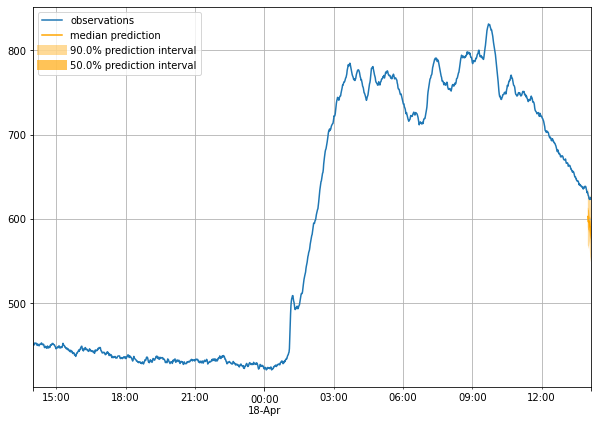

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 14:10:00
Frequency of the time series: 1Min
Mean of the future window:
 [594.58435 595.05444 590.8027  589.3069  585.3839  582.4446  584.0835
 581.70557 578.1033  576.3707 ]
0.5-quantile (median) of the future window:
 [592.8965  595.3878  591.2822  589.3448  585.229   586.65485 583.315
 583.111   575.84033 576.04816]
target_value:
 [[624.6667 623.5    623.     620.5    618.6667 617.5    618.     618.
  616.     616.    ]]


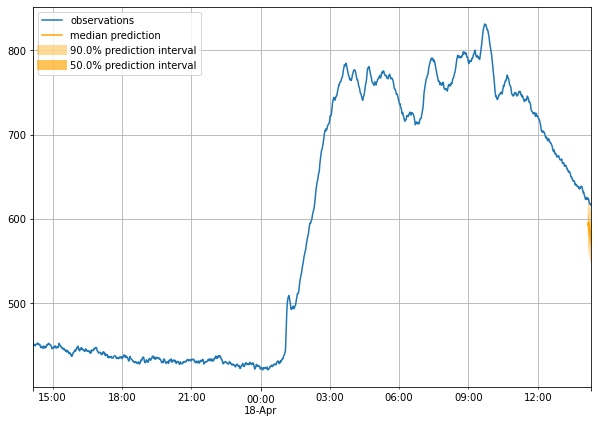

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 14:20:00
Frequency of the time series: 1Min
Mean of the future window:
 [588.457   584.80133 585.25146 580.23083 580.12775 576.00916 579.22424
 572.3445  571.0518  572.5768 ]
0.5-quantile (median) of the future window:
 [591.1494  585.24567 585.2343  578.35645 579.6186  573.6687  579.18744
 572.1109  569.04865 572.42084]
target_value:
 [[614.3333 614.5    612.     611.6667 612.     613.     613.     612.
  613.5    610.5   ]]


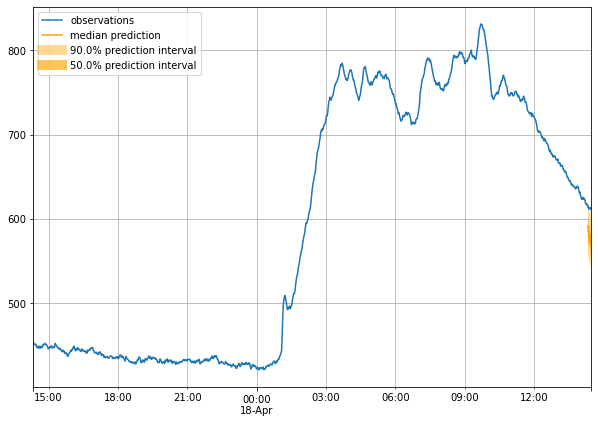

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 14:30:00
Frequency of the time series: 1Min
Mean of the future window:
 [582.1443  579.52783 575.46985 574.7543  573.20197 569.83026 565.89374
 564.9433  561.1118  560.40546]
0.5-quantile (median) of the future window:
 [581.4068  580.4408  574.7758  577.3452  572.8068  567.5841  565.9394
 564.48895 559.34595 559.5195 ]
target_value:
 [[610.     609.5    609.3333 609.     607.     607.     608.5    607.5
  607.5    607.5   ]]


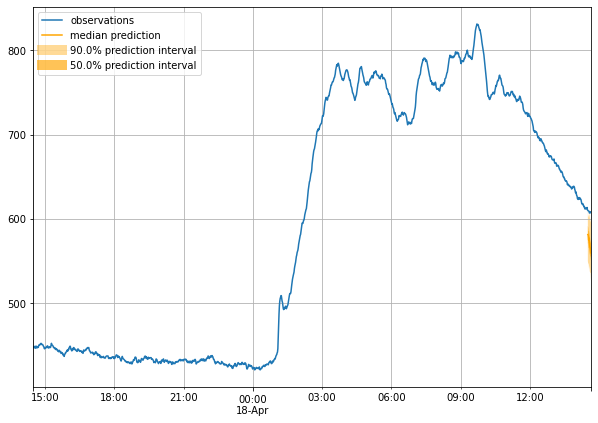

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 14:40:00
Frequency of the time series: 1Min
Mean of the future window:
 [576.1852  573.43146 572.5044  568.26733 566.05524 558.52295 561.06805
 556.1882  558.9836  556.8271 ]
0.5-quantile (median) of the future window:
 [576.8033  575.80524 573.26483 567.9651  567.36615 561.92084 562.1469
 556.8698  559.0901  558.0632 ]
target_value:
 [[608.     606.6667 605.5    605.6667 604.     601.6667 602.     600.5
  600.5    602.3333]]


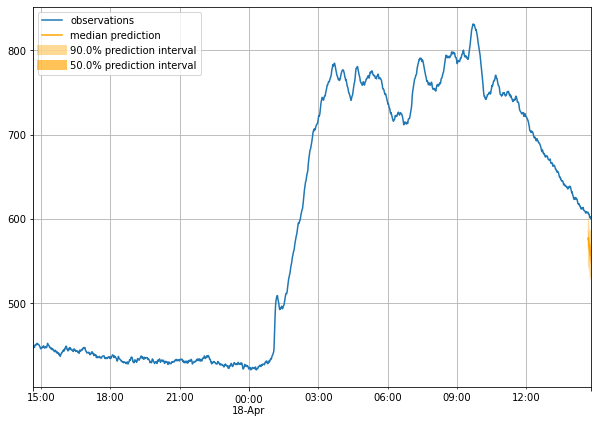

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 14:50:00
Frequency of the time series: 1Min
Mean of the future window:
 [566.62897 565.3111  567.6448  563.7961  562.2752  557.3364  557.1636
 552.55066 549.10846 550.9077 ]
0.5-quantile (median) of the future window:
 [567.39    567.88574 567.26196 563.20056 561.61505 557.74286 559.6365
 553.5203  550.58496 549.7036 ]
target_value:
 [[600.6    597.3333 597.3333 596.     594.5    594.2    594.     592.3333
  592.6667 593.    ]]


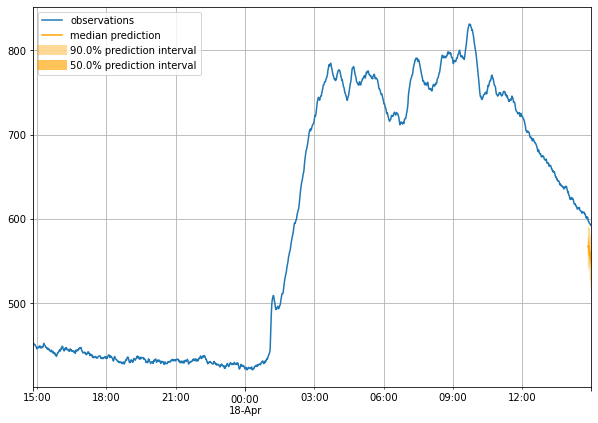

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 15:00:00
Frequency of the time series: 1Min
Mean of the future window:
 [560.0182  559.0832  556.8993  554.2992  552.0068  549.1873  546.5166
 543.6786  541.7286  540.62787]
0.5-quantile (median) of the future window:
 [559.908   559.26794 555.3764  554.71796 550.8977  548.46204 546.6202
 545.43066 542.4181  540.306  ]
target_value:
 [[591.5    591.8    590.5    591.2    591.3333 589.     589.     588.5
  588.6667 589.    ]]


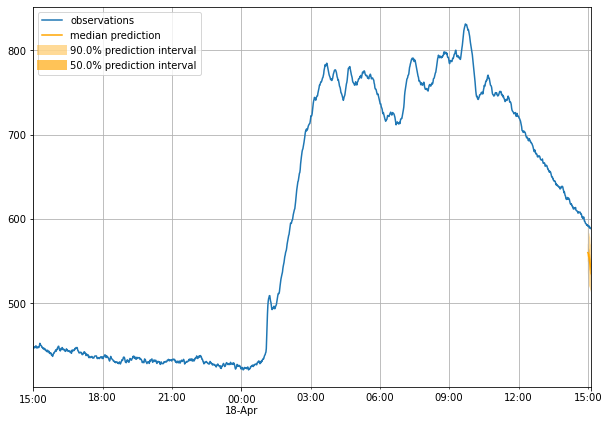

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 15:10:00
Frequency of the time series: 1Min
Mean of the future window:
 [555.90326 551.1972  552.18744 549.48047 546.4698  545.65155 540.0468
 539.4715  534.85    535.4014 ]
0.5-quantile (median) of the future window:
 [551.76404 550.2821  553.1212  549.82355 548.4513  544.87665 538.7869
 539.17365 535.08295 536.01825]
target_value:
 [[588.5    588.     585.8    587.     586.5    585.5    584.     582.
  583.     583.3333]]


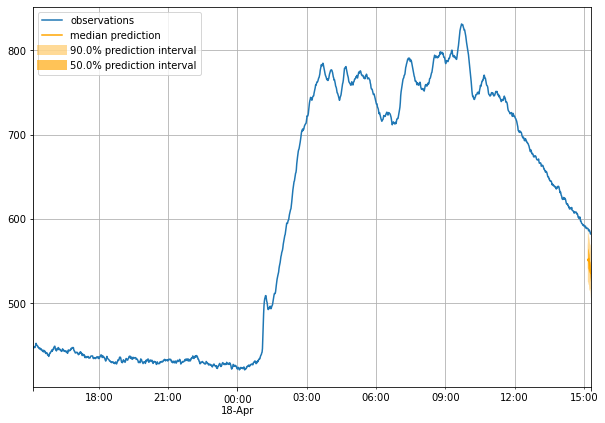

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 15:20:00
Frequency of the time series: 1Min
Mean of the future window:
 [548.48517 547.6369  544.5857  541.7886  538.65924 535.8512  537.4208
 532.9212  529.5951  529.0973 ]
0.5-quantile (median) of the future window:
 [547.5093  550.2612  543.1767  544.2959  538.1861  535.25275 537.5976
 532.09015 530.08057 529.5483 ]
target_value:
 [[583.6667 583.5    584.6667 585.     584.5    583.     583.     584.
  583.     584.1429]]


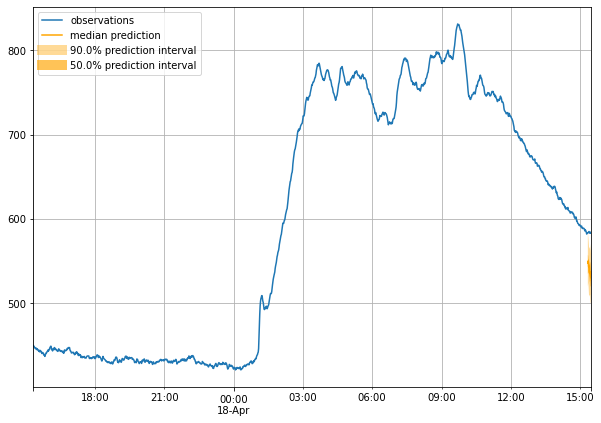

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 15:30:00
Frequency of the time series: 1Min
Mean of the future window:
 [543.2945  543.1827  541.3641  538.1701  535.9255  535.1439  531.10443
 527.3552  524.9822  525.4525 ]
0.5-quantile (median) of the future window:
 [543.27234 543.48553 542.6643  537.41754 535.3448  534.49194 531.65924
 527.5536  523.5429  523.90497]
target_value:
 [[584.6667 584.3333 584.5    582.5    583.3333 582.     578.75   576.5
  575.5    576.    ]]


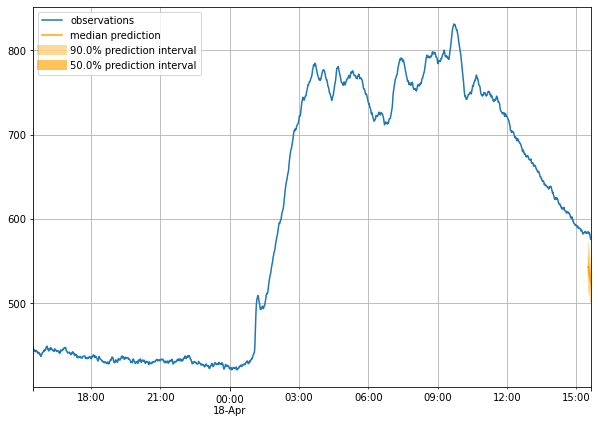

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 15:40:00
Frequency of the time series: 1Min
Mean of the future window:
 [539.0175  536.7965  537.7307  536.69165 526.7387  530.3867  528.634
 503.85114 527.82025 524.664  ]
0.5-quantile (median) of the future window:
 [537.9228  537.0553  537.47546 535.67816 527.99146 531.29974 526.8769
 504.52628 526.1597  522.7787 ]
target_value:
 [[576.     575.5    574.5    575.5    573.5    573.5    574.3333 573.
  574.5    573.5   ]]


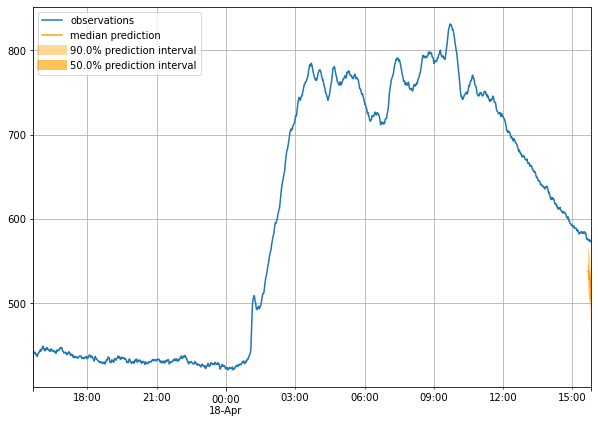

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 15:50:00
Frequency of the time series: 1Min
Mean of the future window:
 [534.78107 534.2625  535.83673 532.7784  526.97614 524.7019  522.20544
 521.40814 518.26086 511.5053 ]
0.5-quantile (median) of the future window:
 [532.8971  536.39856 532.6466  532.18994 527.0499  522.92554 522.60034
 523.5437  517.4752  514.1952 ]
target_value:
 [[572.5 573.  573.  573.  574.  572.5 572.5 574.  575.5 575. ]]


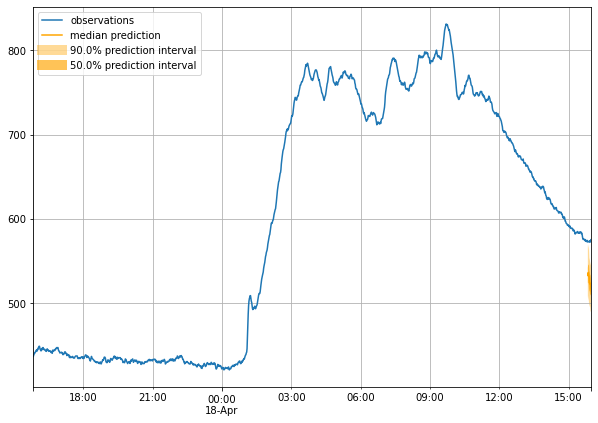

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 16:00:00
Frequency of the time series: 1Min
Mean of the future window:
 [522.4969  522.3862  525.45276 518.71265 514.4504  515.5439  510.64526
 510.35767 504.44043 506.75354]
0.5-quantile (median) of the future window:
 [522.3379  523.6818  524.0679  519.8357  515.5897  513.2696  510.1936
 509.23914 504.52292 506.60095]
target_value:
 [[576.4  574.   574.   573.   571.2  571.   572.   572.   570.75 568.5 ]]


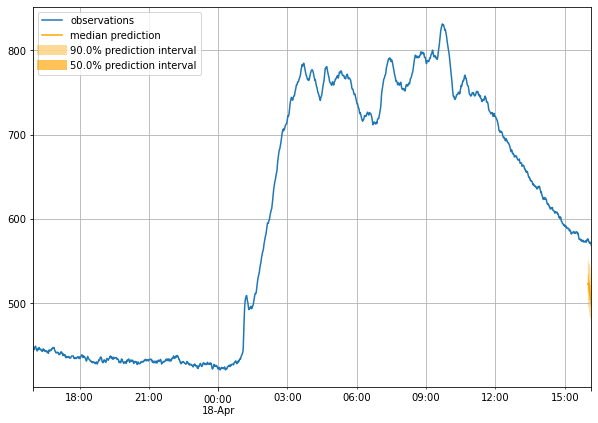

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 16:10:00
Frequency of the time series: 1Min
Mean of the future window:
 [522.23926 522.26337 519.4381  517.0002  512.3156  512.9246  506.74387
 503.31223 488.0084  581.2214 ]
0.5-quantile (median) of the future window:
 [522.48987 523.42505 519.62103 517.0931  511.64572 511.24643 507.6996
 506.49524 487.53494 577.83636]
target_value:
 [[570.     572.     573.3333 572.     570.5    571.5    573.5    575.
  575.5    574.    ]]


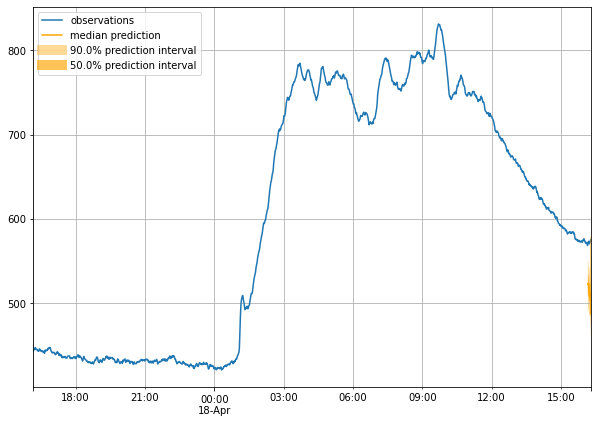

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 16:20:00
Frequency of the time series: 1Min
Mean of the future window:
 [616.7803  529.0682  527.9163  525.9282  527.5874  524.46484 521.8263
 520.72284 513.6034  512.9486 ]
0.5-quantile (median) of the future window:
 [612.88226 530.3245  527.57446 523.2796  528.44867 526.5612  521.7498
 520.9725  514.66    513.5652 ]
target_value:
 [[573.     574.3333 572.5    574.2    575.5    576.5    574.5    574.
  574.5    575.    ]]


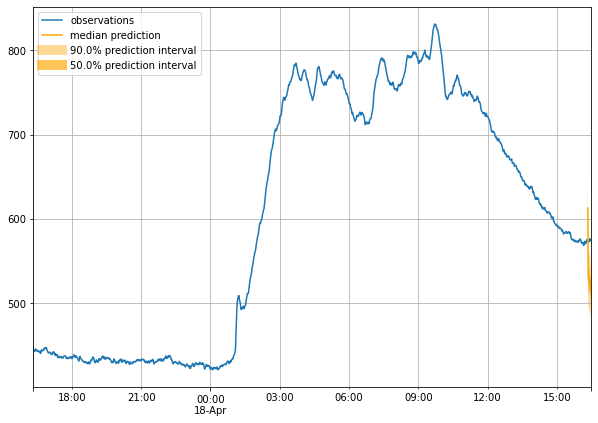

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 16:30:00
Frequency of the time series: 1Min
Mean of the future window:
 [527.36707 526.128   526.2335  524.2209  518.6108  513.333   512.1459
 509.9989  504.69727 498.45926]
0.5-quantile (median) of the future window:
 [528.1939  527.6955  526.2064  524.5871  518.8966  513.5464  511.14114
 509.9495  502.1987  499.34207]
target_value:
 [[573.5    572.     571.6667 570.     569.     567.5    565.6667 564.5
  564.5    565.5   ]]


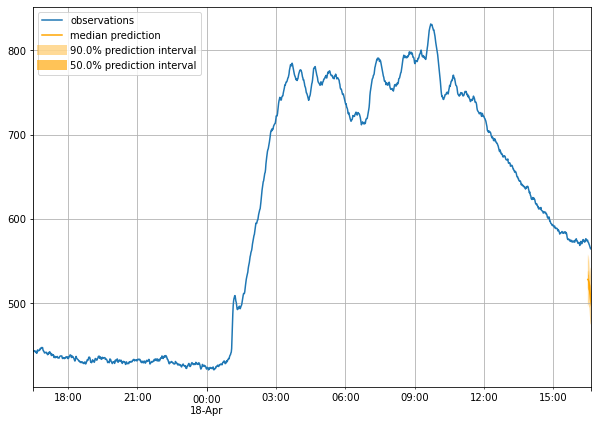

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 16:40:00
Frequency of the time series: 1Min
Mean of the future window:
 [517.4175  514.2619  513.21545 509.34235 457.00418 523.71674 569.6506
 473.8505  471.421   470.19836]
0.5-quantile (median) of the future window:
 [517.3229  515.7512  512.9678  511.06265 459.8995  524.8249  569.43744
 476.40222 468.7702  473.08636]
target_value:
 [[568.     568.5    570.     570.5    571.     570.     569.5    569.5
  570.     567.6667]]


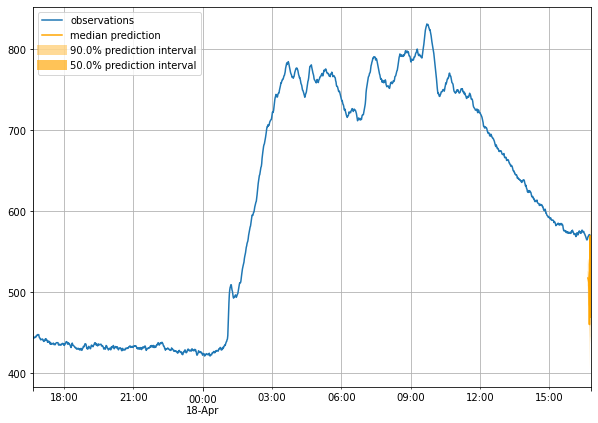

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 16:50:00
Frequency of the time series: 1Min
Mean of the future window:
 [496.63657 496.5531  499.65466 497.18292 490.70276 438.26407 429.2112
 445.88654 444.7394  444.48843]
0.5-quantile (median) of the future window:
 [499.52963 499.9448  497.62476 495.6151  489.84164 441.56006 430.9699
 443.02975 446.6424  443.01108]
target_value:
 [[568.5    566.     566.     565.     565.6667 563.5    560.5    558.
  557.2    557.5   ]]


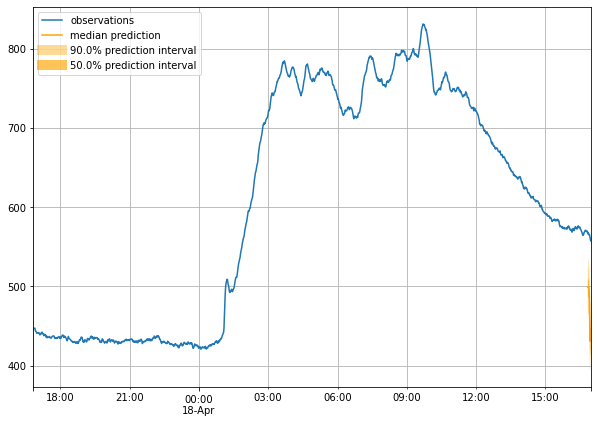

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 17:00:00
Frequency of the time series: 1Min
Mean of the future window:
 [478.5102  477.2826  478.15512 471.13004 467.68964 469.57825 464.47183
 457.30594 456.17874 454.12518]
0.5-quantile (median) of the future window:
 [478.14084 474.81476 476.80533 471.64005 468.47833 468.1262  462.4771
 457.94427 454.12006 454.91324]
target_value:
 [[557.5    557.     555.5    555.5    556.3333 555.     556.     557.5
  557.5    556.5   ]]


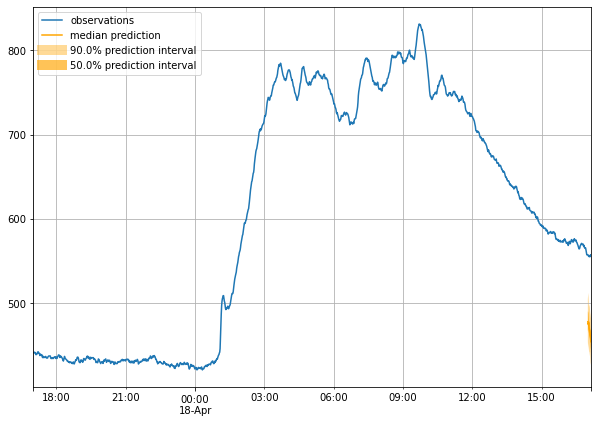

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 17:10:00
Frequency of the time series: 1Min
Mean of the future window:
 [490.2445  484.34915 486.25443 481.0463  478.347   475.25113 471.55185
 462.81683 462.5813  463.1253 ]
0.5-quantile (median) of the future window:
 [491.01016 485.01294 485.58768 483.25662 479.4165  474.5665  470.78333
 464.4416  464.62222 463.3665 ]
target_value:
 [[557.5 557.5 557.  557.  557.  555.  555.  555.5 554.  554. ]]


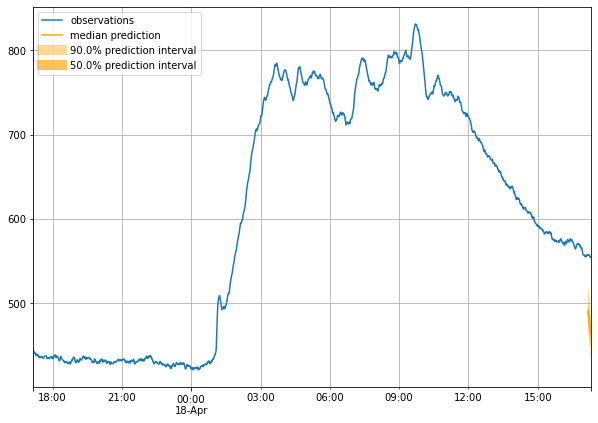

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 17:20:00
Frequency of the time series: 1Min
Mean of the future window:
 [488.9882  488.52527 485.68698 483.78168 477.81836 476.34372 471.318
 468.36438 467.8302  464.6178 ]
0.5-quantile (median) of the future window:
 [487.84747 487.83224 484.72797 484.4588  477.11978 477.209   472.24115
 469.45563 467.5209  464.43344]
target_value:
 [[553.     555.     552.6    553.5    554.5    556.     557.3333 557.3333
  556.     554.5   ]]


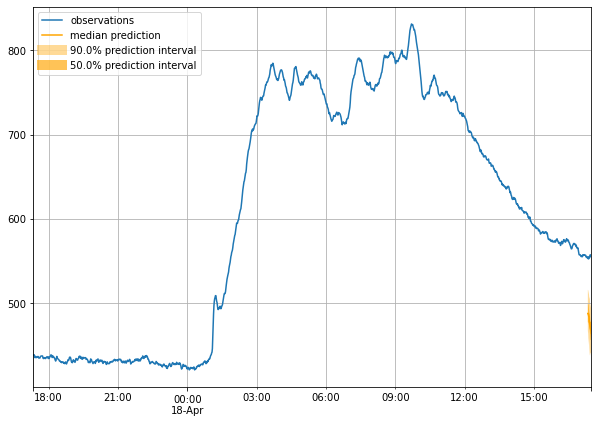

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 17:30:00
Frequency of the time series: 1Min
Mean of the future window:
 [491.9793  485.71793 486.3366  482.00043 476.6534  477.24347 475.16504
 468.64798 464.54163 456.20065]
0.5-quantile (median) of the future window:
 [492.98135 486.3542  486.37784 481.38638 476.7371  477.23566 473.0897
 468.5186  463.52805 456.50412]
target_value:
 [[553.5 553.  552.5 551.5 553.  554.5 554.  552.5 553.5 552.5]]


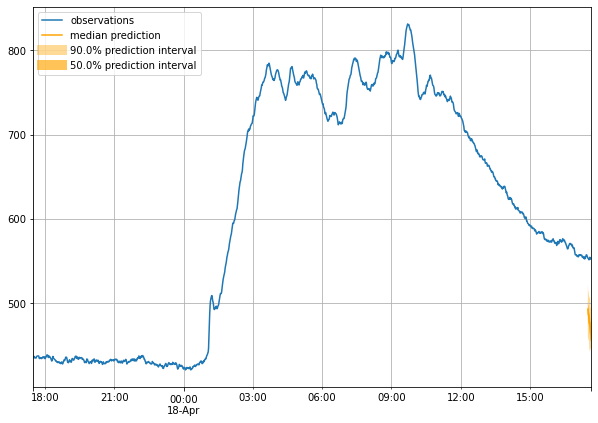

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 17:40:00
Frequency of the time series: 1Min
Mean of the future window:
 [482.42743 484.68988 483.90738 481.46103 474.41736 471.67667 466.36926
 462.28546 459.9366  457.56375]
0.5-quantile (median) of the future window:
 [483.35852 486.55487 485.32367 478.6373  476.2186  471.74554 466.47522
 463.26938 459.40344 458.00082]
target_value:
 [[552.5    553.5    552.5    554.     552.6667 552.3333 551.3333 551.6667
  552.6667 552.5   ]]


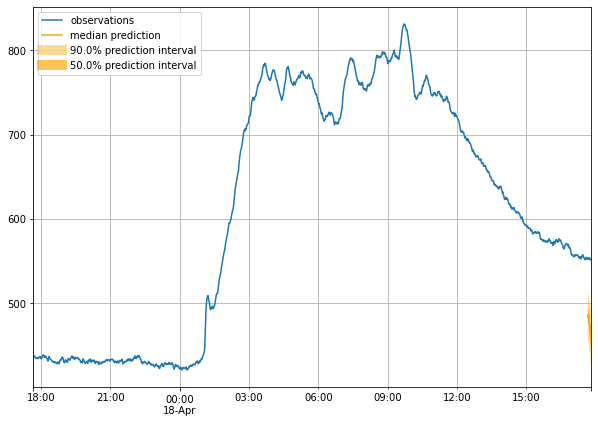

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 17:50:00
Frequency of the time series: 1Min
Mean of the future window:
 [486.58435 484.43027 481.65726 477.52188 474.2236  470.09143 466.54578
 461.69687 457.37155 455.7296 ]
0.5-quantile (median) of the future window:
 [487.4024  483.18515 481.14313 475.84555 474.14655 468.577   467.24637
 461.4574  455.61255 457.9104 ]
target_value:
 [[553.5    554.     553.4    551.5    551.5    549.5    548.     547.5
  547.5    547.3333]]


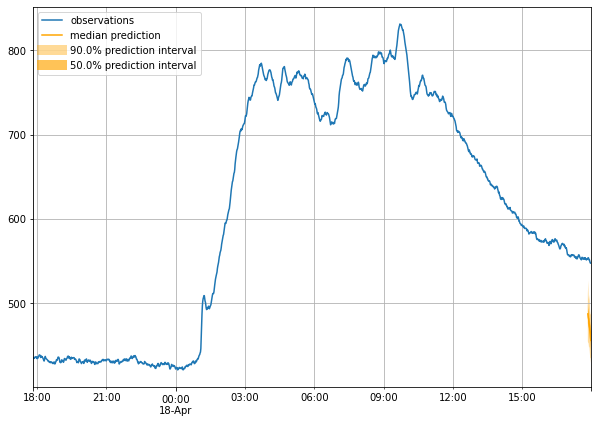

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 18:00:00
Frequency of the time series: 1Min
Mean of the future window:
 [434.10074 424.25507 440.95126 438.62634 437.4965  435.35226 431.6291
 431.74298 427.85675 427.17978]
0.5-quantile (median) of the future window:
 [434.71875 423.40714 441.85602 437.29254 437.92917 433.13098 430.73914
 433.09332 426.62564 426.16003]
target_value:
 [[547.     546.     546.     545.5    546.     544.6667 545.5    544.3333
  542.6667 544.3333]]


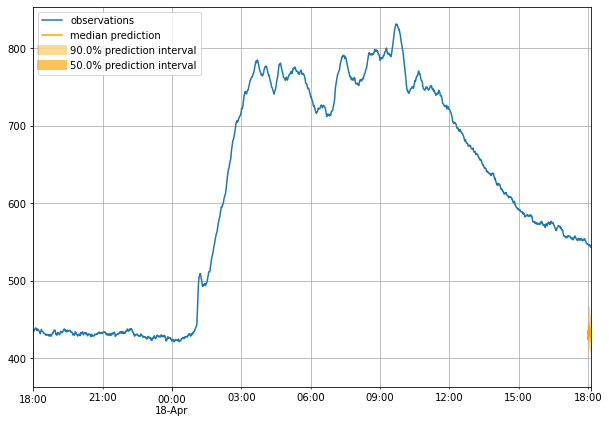

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 18:10:00
Frequency of the time series: 1Min
Mean of the future window:
 [466.15732 467.50183 464.03702 462.37402 459.19473 455.8237  454.28653
 448.45746 443.54944 440.7137 ]
0.5-quantile (median) of the future window:
 [464.0172  466.20297 465.64807 462.65305 458.73712 455.92044 455.33737
 445.93155 443.16434 441.36877]
target_value:
 [[544.     543.5    543.5    544.5    545.5    544.4    544.4    543.3333
  542.3333 541.5   ]]


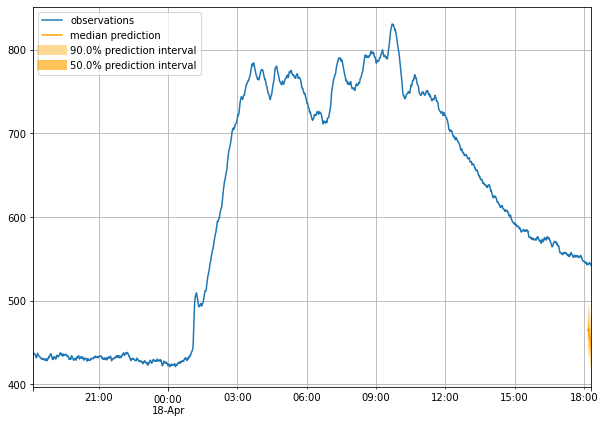

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 18:20:00
Frequency of the time series: 1Min
Mean of the future window:
 [472.99286 469.6809  469.95938 466.58374 462.46335 458.0964  456.57208
 451.7197  448.80527 448.32367]
0.5-quantile (median) of the future window:
 [472.42978 471.39185 469.4135  467.52368 462.45456 457.95157 457.757
 450.28317 447.09238 448.46597]
target_value:
 [[543.5 543.5 543.  544.  544.5 543.5 543.8 544.5 545.  545.5]]


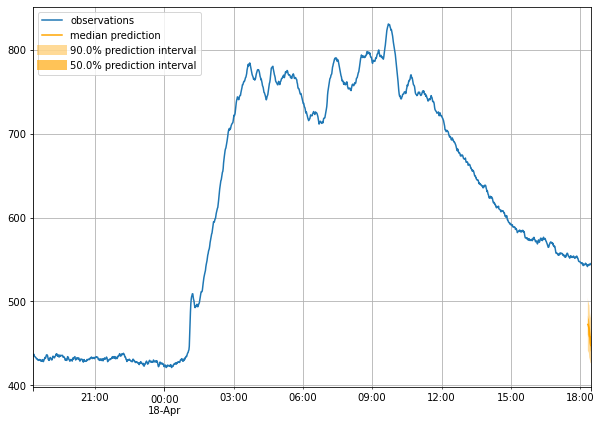

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 18:30:00
Frequency of the time series: 1Min
Mean of the future window:
 [475.9513  473.31488 471.07675 465.8708  464.16208 461.86035 455.46796
 452.30872 447.7991  444.15244]
0.5-quantile (median) of the future window:
 [476.97775 473.91168 469.8969  462.76093 462.06204 462.6369  455.83017
 452.65176 446.91998 443.48065]
target_value:
 [[544.5    542.6    544.     542.     540.3333 541.3333 539.5    538.
  536.6667 537.5   ]]


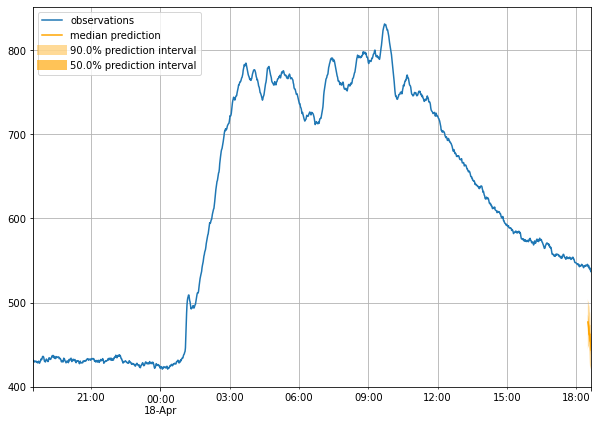

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 18:40:00
Frequency of the time series: 1Min
Mean of the future window:
 [473.98386 469.31854 467.1221  464.57504 461.02176 458.55875 454.25433
 448.10608 443.98694 448.25693]
0.5-quantile (median) of the future window:
 [474.3205  469.4243  468.1725  464.63196 461.20877 457.13705 454.0067
 448.6387  443.65033 450.54846]
target_value:
 [[535.6667 537.     538.     537.5    537.     538.5    540.5    540.5
  540.5    540.    ]]


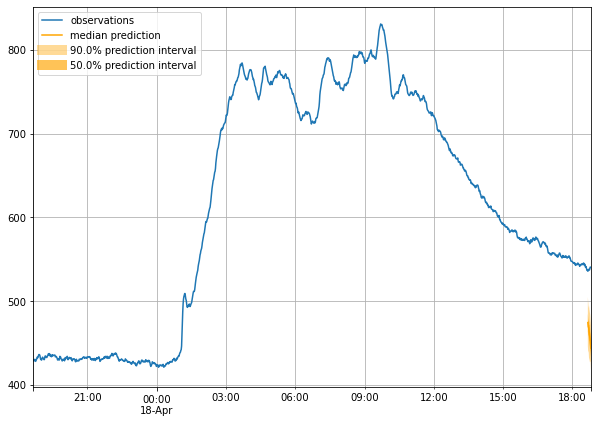

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 18:50:00
Frequency of the time series: 1Min
Mean of the future window:
 [468.73343 470.9884  470.53763 462.73242 463.3002  453.1259  451.92755
 444.44754 443.01447 439.51154]
0.5-quantile (median) of the future window:
 [470.07687 471.72025 469.3949  464.61752 462.79352 455.69104 452.44763
 445.9563  444.6747  442.52338]
target_value:
 [[539.     537.6667 537.     538.     537.     537.     537.6667 539.
  540.     538.6667]]


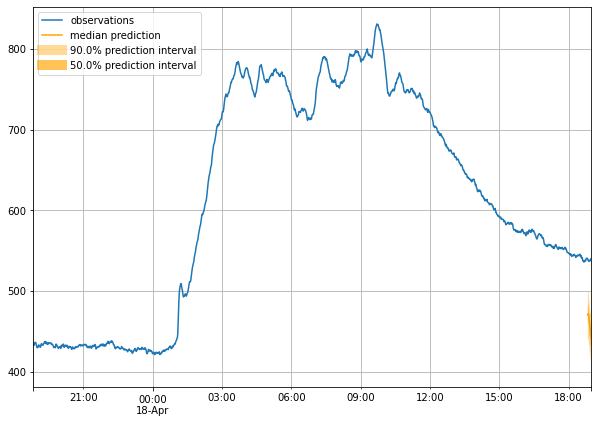

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 19:00:00
Frequency of the time series: 1Min
Mean of the future window:
 [466.52194 463.46155 460.72922 457.7614  454.268   453.70386 444.24655
 442.8982  441.11298 437.6664 ]
0.5-quantile (median) of the future window:
 [464.2267  464.4646  463.4734  458.8377  455.6502  457.0781  444.28656
 443.4343  441.02124 436.41327]
target_value:
 [[539.5    537.     537.     536.5    535.     535.5    535.6667 535.
  534.5    534.    ]]


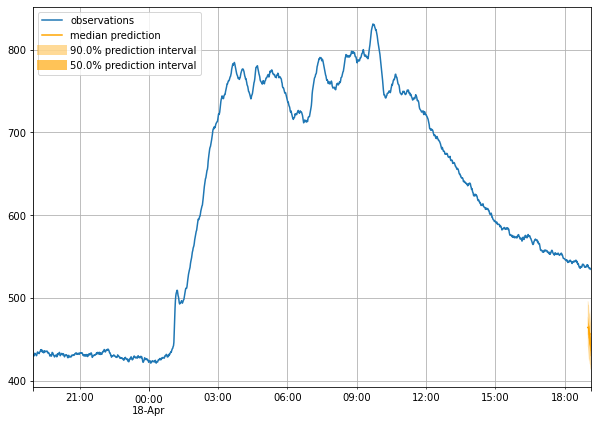

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 19:10:00
Frequency of the time series: 1Min
Mean of the future window:
 [465.25848 462.1029  461.0325  451.92798 451.46466 447.8765  451.3449
 376.0854  374.1597  394.7298 ]
0.5-quantile (median) of the future window:
 [464.3218  463.12424 460.95746 450.22537 452.01385 448.64224 452.4462
 379.04224 374.93314 394.32956]
target_value:
 [[534.     533.     534.3333 535.     534.3333 535.     536.     535.
  533.6667 533.4   ]]


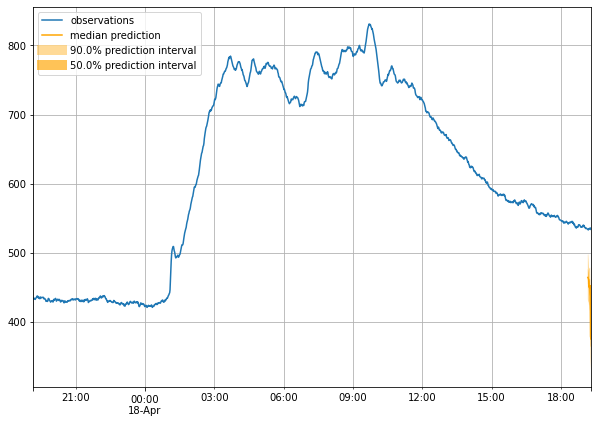

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 19:20:00
Frequency of the time series: 1Min
Mean of the future window:
 [432.1115  434.56808 429.2415  430.7451  431.1445  428.39297 425.44547
 418.7708  420.18835 418.65002]
0.5-quantile (median) of the future window:
 [432.35568 433.5219  433.3572  429.75244 429.44916 429.7585  424.5843
 419.77438 424.11636 419.8851 ]
target_value:
 [[534.     535.     535.5    536.     535.3333 536.5    538.5    538.5
  537.5    536.    ]]


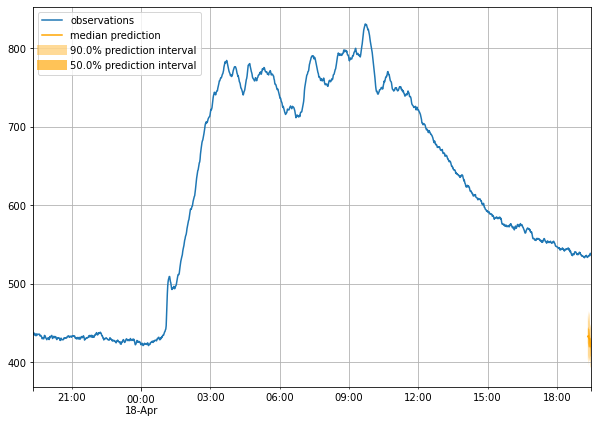

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 19:30:00
Frequency of the time series: 1Min
Mean of the future window:
 [455.96417 453.33942 449.2072  449.05606 442.04315 442.73734 439.19354
 436.67163 430.2861  426.76526]
0.5-quantile (median) of the future window:
 [455.01218 454.16846 450.10507 446.6656  440.1302  441.9029  436.8729
 436.05142 432.4231  428.15564]
target_value:
 [[537.     538.5    538.5    538.5    538.6667 539.     539.     538.5
  537.5    535.    ]]


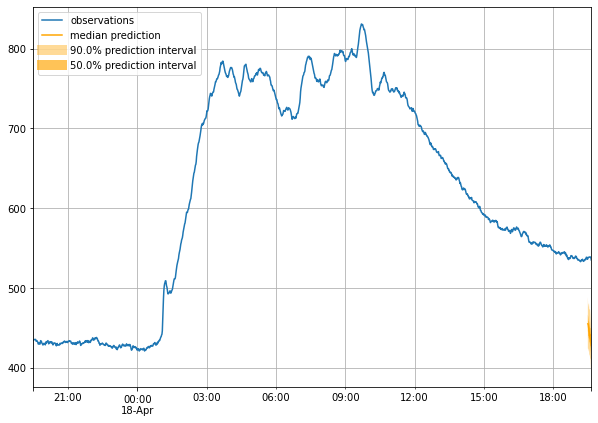

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 19:40:00
Frequency of the time series: 1Min
Mean of the future window:
 [457.81757 455.7069  454.4633  448.78516 448.942   443.57077 438.65836
 433.21524 539.6724  449.98566]
0.5-quantile (median) of the future window:
 [459.1441  456.27036 455.9351  450.3637  448.2738  443.91602 438.04626
 433.9146  540.00165 448.3547 ]
target_value:
 [[532.     529.     529.5    530.5    531.5    530.5    530.     530.
  527.6667 526.5   ]]


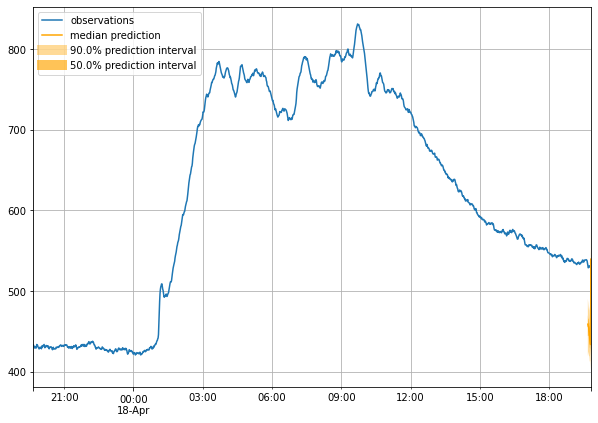

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 19:50:00
Frequency of the time series: 1Min
Mean of the future window:
 [464.2595  462.58063 456.76843 457.26038 452.97638 449.16528 446.3354
 446.07687 441.82397 433.54956]
0.5-quantile (median) of the future window:
 [465.4359  465.0223  459.7864  457.17117 452.10028 449.4403  447.76196
 447.39307 443.1336  434.64722]
target_value:
 [[527.5 528.5 528.5 527.5 529.  529.5 527.  527.5 527.5 527. ]]


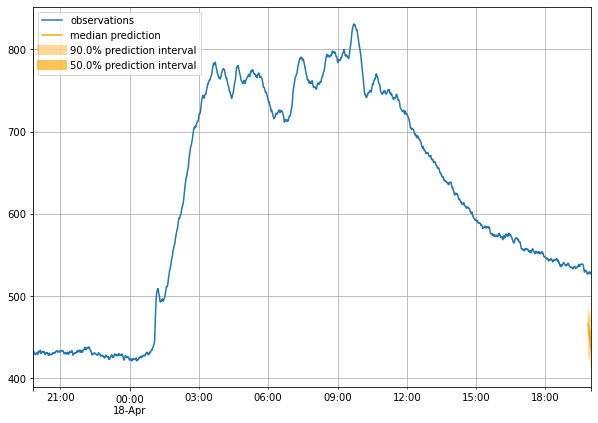

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 20:00:00
Frequency of the time series: 1Min
Mean of the future window:
 [456.39807 459.19138 451.9788  449.26395 446.27325 442.58136 440.2386
 434.50742 430.13113 426.18607]
0.5-quantile (median) of the future window:
 [457.73343 459.6292  454.55505 451.5594  444.59335 445.36258 439.02365
 433.5403  429.51758 427.39395]
target_value:
 [[526.  525.5 527.  527.5 527.6 529.  527.5 527.  528.5 527.5]]


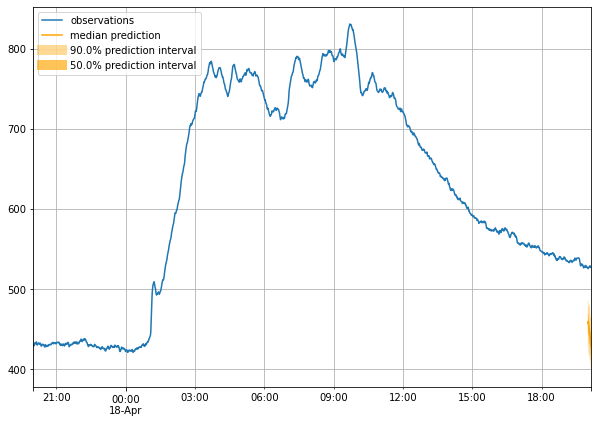

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 20:10:00
Frequency of the time series: 1Min
Mean of the future window:
 [457.70212 451.7105  451.89914 446.3581  437.17596 437.8679  437.66467
 432.2003  427.5374  427.98395]
0.5-quantile (median) of the future window:
 [457.69934 449.6242  451.90448 445.3091  437.1699  440.81656 438.7489
 432.73828 428.26062 426.50586]
target_value:
 [[527.5    526.5    524.5    524.     523.5    523.5    523.5    523.6667
  525.     523.5   ]]


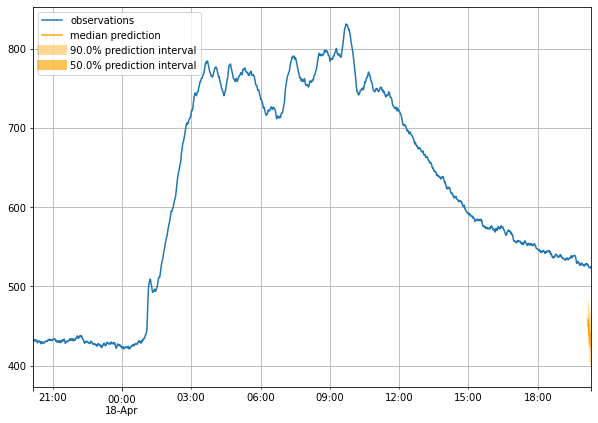

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 20:20:00
Frequency of the time series: 1Min
Mean of the future window:
 [448.7041  447.8602  446.7684  444.3837  441.62625 433.29047 432.3744
 427.15244 427.90317 425.06348]
0.5-quantile (median) of the future window:
 [450.07245 449.70755 449.1655  445.28067 441.32462 434.8055  432.53757
 428.98236 428.04056 427.68555]
target_value:
 [[523.  522.  520.  519.  517.5 518.5 520.  523.  525.4 525.5]]


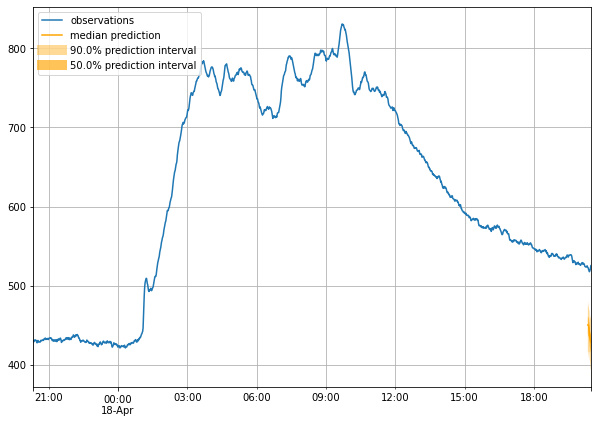

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 20:30:00
Frequency of the time series: 1Min
Mean of the future window:
 [452.2888  450.816   446.5844  442.1795  437.62738 436.45966 432.89764
 430.01492 427.6969  422.01495]
0.5-quantile (median) of the future window:
 [451.93845 450.44815 446.47516 442.93    442.9148  436.38757 433.42398
 428.61942 428.76242 423.24564]
target_value:
 [[526.     525.     524.5    524.5    523.5    522.     520.5    521.3333
  520.     521.3333]]


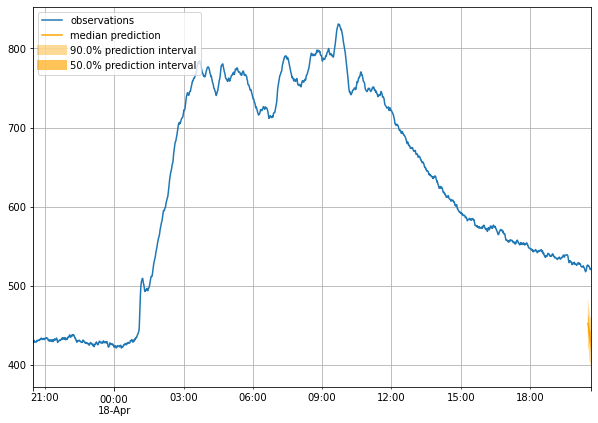

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 20:40:00
Frequency of the time series: 1Min
Mean of the future window:
 [452.71405 446.24    440.4191  438.0381  437.41885 433.96216 431.94223
 425.21732 424.4074  421.6932 ]
0.5-quantile (median) of the future window:
 [452.9623  447.75763 439.7691  440.1185  438.239   433.39465 434.20514
 426.01474 425.2344  419.9321 ]
target_value:
 [[520.5    522.     520.     519.5    520.5    519.6667 519.5    520.5
  519.5    518.6667]]


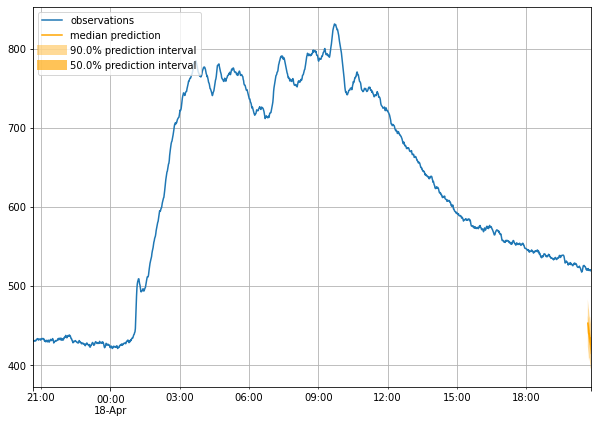

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 20:50:00
Frequency of the time series: 1Min
Mean of the future window:
 [446.23553 447.18164 443.82812 439.35938 438.10626 435.9668  433.05457
 428.079   421.36575 420.68414]
0.5-quantile (median) of the future window:
 [444.68973 446.1659  444.61993 440.507   437.564   437.14645 432.75323
 426.97064 421.68814 420.13086]
target_value:
 [[520.5 520.5 520.5 522.  522.  521.5 521.5 522.5 521.  519. ]]


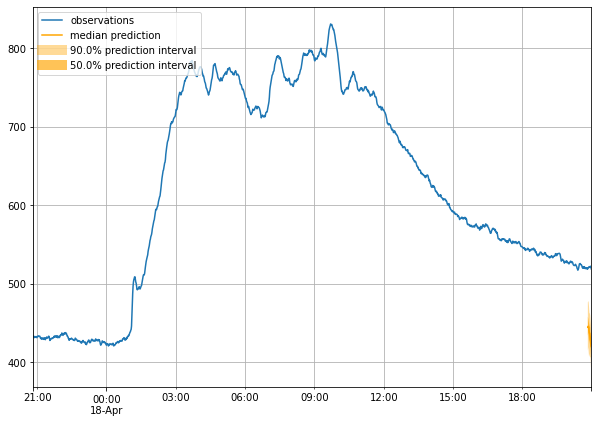

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 21:00:00
Frequency of the time series: 1Min
Mean of the future window:
 [442.8231  428.95782 452.93762 442.22577 437.79385 435.20178 428.0321
 422.8768  419.89658 418.12198]
0.5-quantile (median) of the future window:
 [445.56372 430.81863 452.1989  441.6171  436.33328 431.9743  428.78424
 423.1998  419.98904 418.64172]
target_value:
 [[518.     517.5    517.     514.5    513.3333 512.5    513.     513.
  513.8333 517.5   ]]


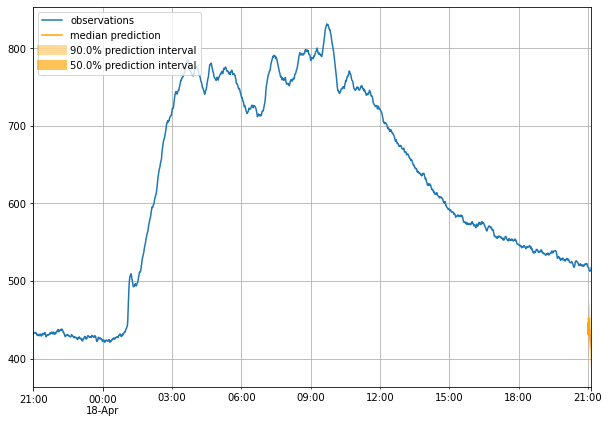

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 21:10:00
Frequency of the time series: 1Min
Mean of the future window:
 [441.3417  445.1952  440.76245 439.23544 436.01065 426.83868 428.4863
 422.36734 417.52493 417.87808]
0.5-quantile (median) of the future window:
 [439.13748 443.36337 439.02182 438.09174 437.62656 425.50497 428.023
 423.87155 418.6956  417.27377]
target_value:
 [[518.6667 520.     520.     520.     518.5    517.5    518.5    516.6667
  517.     516.5   ]]


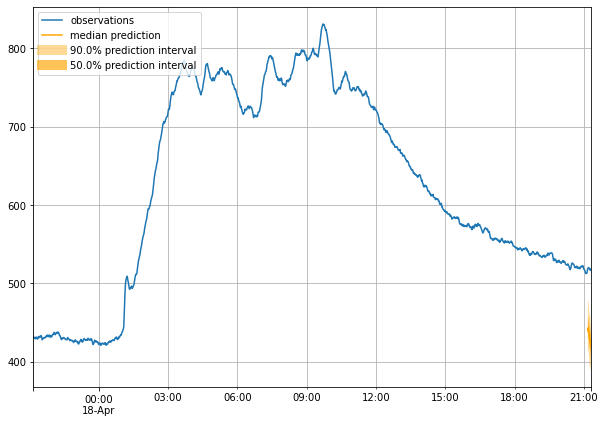

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 21:20:00
Frequency of the time series: 1Min
Mean of the future window:
 [441.91925 444.45145 440.36847 436.95773 432.70746 426.20917 423.09818
 418.29047 418.00897 417.65308]
0.5-quantile (median) of the future window:
 [442.76556 443.02844 439.7897  436.9221  434.52264 427.76416 424.10583
 419.6817  418.26508 417.2187 ]
target_value:
 [[517.5    518.5    517.     517.6667 519.     520.     519.3333 517.
  518.     516.    ]]


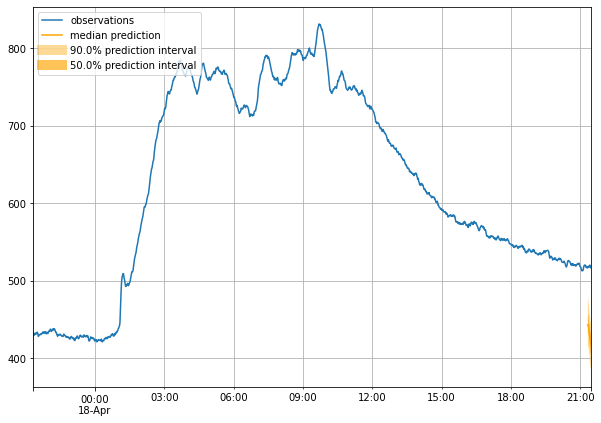

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 21:30:00
Frequency of the time series: 1Min
Mean of the future window:
 [438.26923 444.21317 383.28867 428.18945 514.60333 535.353   426.10175
 423.51886 424.2113  420.18036]
0.5-quantile (median) of the future window:
 [437.53122 445.58755 385.56253 427.5819  515.6507  533.9358  428.53308
 423.77203 422.62708 423.68787]
target_value:
 [[516.     515.3333 515.3333 516.     515.3333 514.     512.6667 514.5
  516.     517.5   ]]


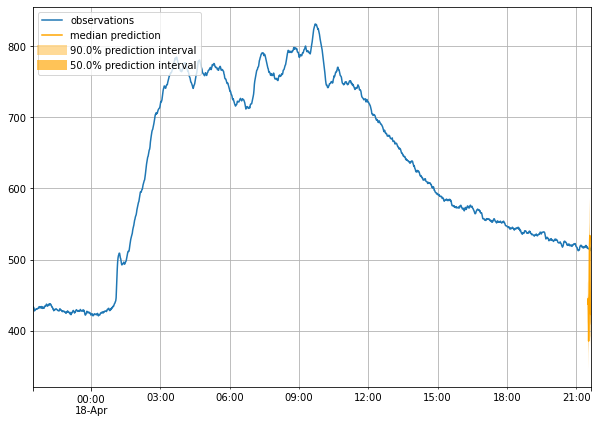

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 21:40:00
Frequency of the time series: 1Min
Mean of the future window:
 [441.41238 441.20673 440.2814  434.7215  430.9118  430.07996 425.17706
 421.9448  414.9753  415.6544 ]
0.5-quantile (median) of the future window:
 [439.901   442.08282 438.93497 435.8528  432.5831  430.02933 424.838
 419.12555 417.59378 413.877  ]
target_value:
 [[517.5 517.  518.5 516.5 516.  514.5 513.  513.5 514.  512.5]]


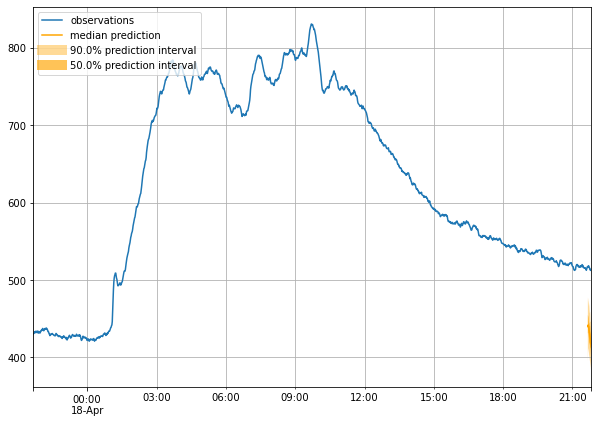

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 21:50:00
Frequency of the time series: 1Min
Mean of the future window:
 [441.73743 441.51642 436.7779  428.68204 425.9499  426.04706 421.35403
 414.15518 409.947   409.4612 ]
0.5-quantile (median) of the future window:
 [440.89734 440.54724 436.80905 431.07776 428.05066 425.483   418.76877
 415.444   411.90988 409.1557 ]
target_value:
 [[513.3333  513.      514.      512.3333  512.      509.66666 508.5
  508.5     507.4     509.     ]]


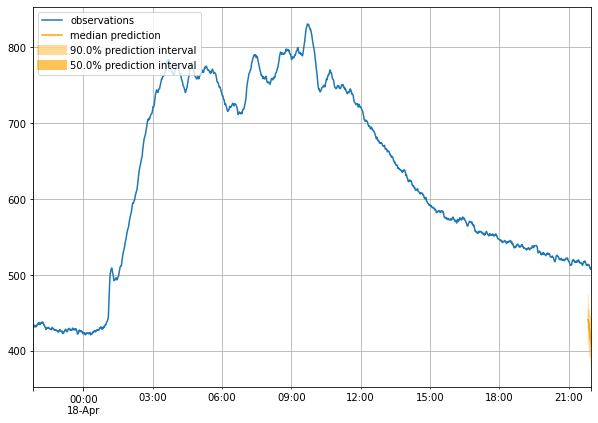

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 22:00:00
Frequency of the time series: 1Min
Mean of the future window:
 [432.68323 433.20065 428.7182  421.6534  422.12503 413.15384 414.1377
 408.09305 405.11777 337.65808]
0.5-quantile (median) of the future window:
 [433.63138 433.89316 429.3389  422.00934 423.04507 415.15848 414.88177
 409.51273 405.2663  340.7056 ]
target_value:
 [[508.5     507.5     508.      506.5     508.5     507.66666 507.
  507.      507.5     508.5    ]]


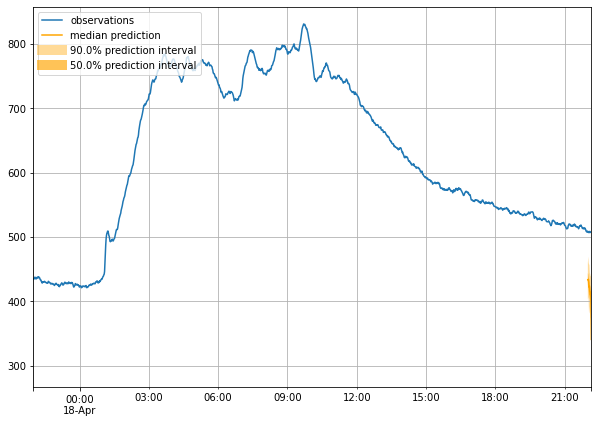

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 22:10:00
Frequency of the time series: 1Min
Mean of the future window:
 [424.4143  515.9525  417.17886 411.572   410.2483  408.93765 406.2324
 401.24347 402.74503 403.1527 ]
0.5-quantile (median) of the future window:
 [428.41397 520.1132  415.80386 411.86523 410.90005 410.44302 405.2949
 404.695   405.71027 402.57443]
target_value:
 [[509.2     507.      507.      505.      505.5     504.      505.5
  503.      501.66666 501.     ]]


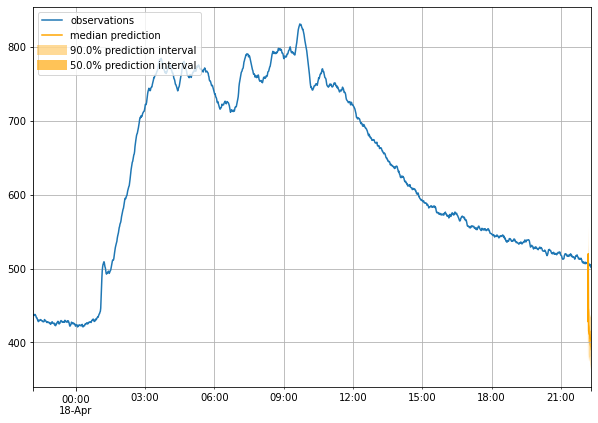

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 22:20:00
Frequency of the time series: 1Min
Mean of the future window:
 [424.36896 425.847   422.8397  416.851   413.87598 408.9905  407.1649
 402.3709  402.45102 399.48773]
0.5-quantile (median) of the future window:
 [423.77686 425.62656 422.2703  417.45685 414.4817  409.777   406.29788
 401.0063  402.44012 401.8357 ]
target_value:
 [[500.33334 500.      497.5     495.5     495.      494.5     492.66666
  493.      492.      493.     ]]


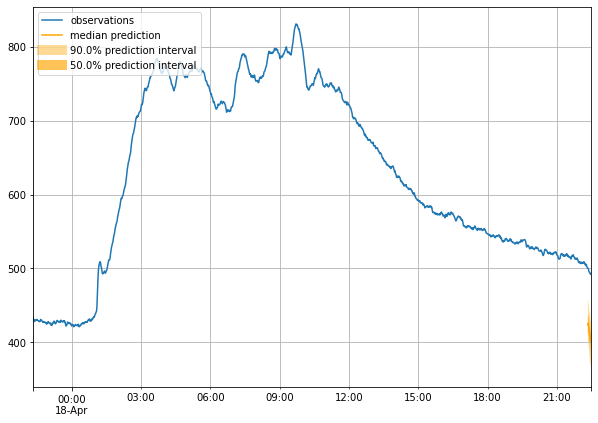

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 22:30:00
Frequency of the time series: 1Min
Mean of the future window:
 [424.6641  421.43396 417.00266 418.4825  407.88077 409.8721  407.08585
 402.49182 393.97708 394.21808]
0.5-quantile (median) of the future window:
 [426.73013 422.0882  417.82355 418.56265 405.9734  409.9089  406.96423
 401.91452 394.884   394.6679 ]
target_value:
 [[490.5     489.5     488.      488.      489.      489.      490.33334
  490.      487.5     485.     ]]


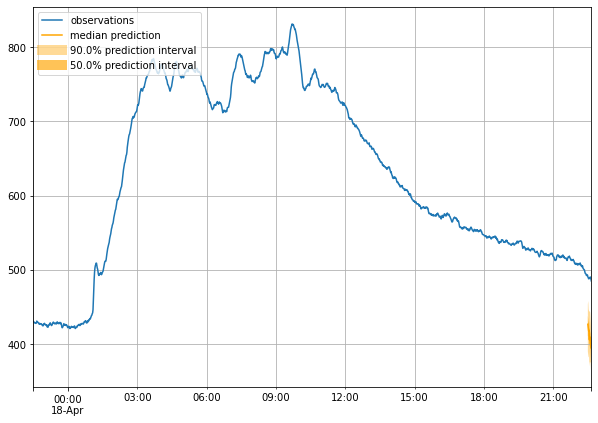

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 22:40:00
Frequency of the time series: 1Min
Mean of the future window:
 [420.2083  417.00867 416.99258 412.73767 409.53046 403.98813 401.7009
 396.31778 397.46988 392.93317]
0.5-quantile (median) of the future window:
 [419.64154 418.03384 417.24734 411.2486  409.68524 402.83575 401.2631
 397.4208  395.2525  394.06143]
target_value:
 [[483.      484.      483.      481.2     479.33334 478.      479.33334
  478.33334 477.      479.     ]]


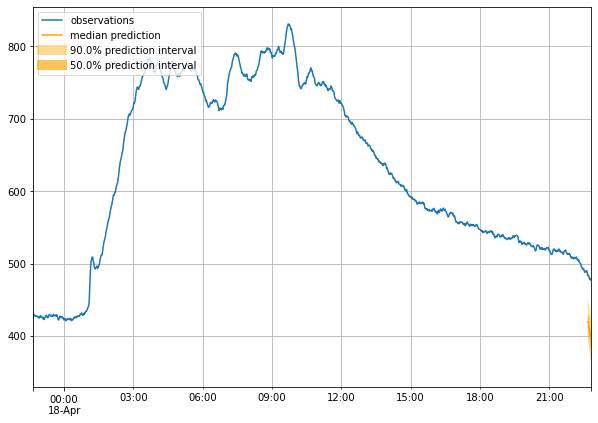

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 22:50:00
Frequency of the time series: 1Min
Mean of the future window:
 [413.60406 417.32727 412.0697  411.3398  405.50363 400.67368 399.44644
 395.44974 390.8898  391.15805]
0.5-quantile (median) of the future window:
 [415.6261  416.062   413.12418 411.08313 406.72397 400.02338 401.2358
 394.8148  391.9767  394.08124]
target_value:
 [[477.5     475.66666 474.66666 475.5     473.66666 473.5     473.5
  473.5     473.      472.     ]]


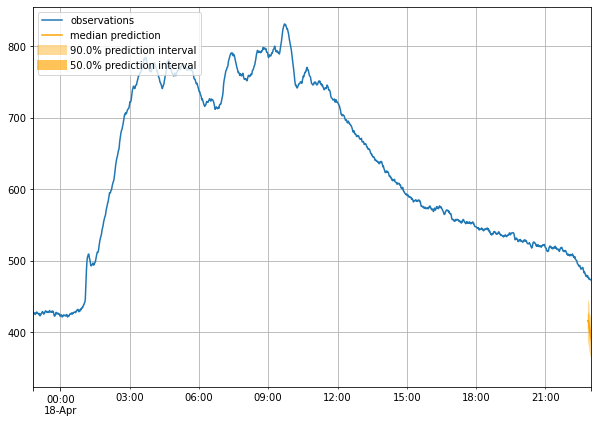

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 23:00:00
Frequency of the time series: 1Min
Mean of the future window:
 [406.4406  406.45532 406.8976  405.91696 396.22604 393.73926 394.24667
 391.13907 386.99774 383.9368 ]
0.5-quantile (median) of the future window:
 [408.4841  407.93353 405.64502 405.3292  397.44955 392.61865 395.74805
 389.47504 387.63446 385.683  ]
target_value:
 [[473.33334 473.5     471.5     470.33334 471.5     472.5     473.
  474.5     474.      472.5    ]]


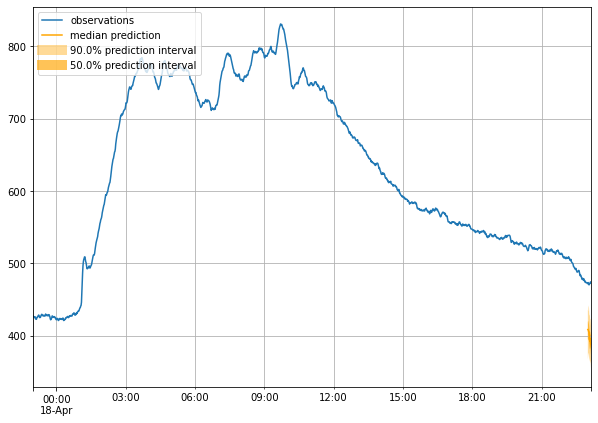

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 23:10:00
Frequency of the time series: 1Min
Mean of the future window:
 [401.85257 403.9568  396.52817 400.88397 396.5979  394.39923 388.27008
 386.0117  384.61395 386.0509 ]
0.5-quantile (median) of the future window:
 [402.71066 404.59085 396.90533 399.50302 397.03833 393.19055 389.11493
 387.8157  384.68054 386.34134]
target_value:
 [[473.5     474.5     472.      472.      471.33334 470.5     471.5
  472.4     471.      471.     ]]


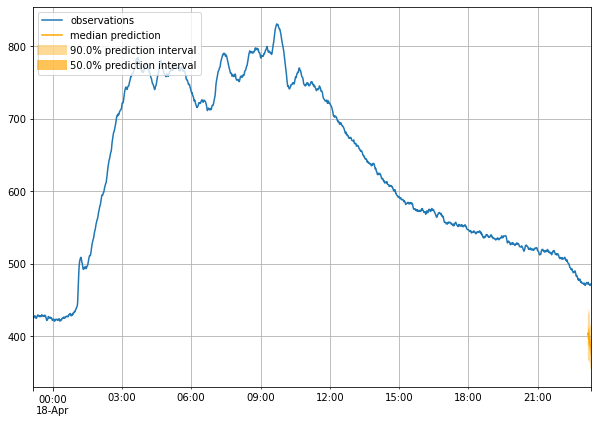

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 23:20:00
Frequency of the time series: 1Min
Mean of the future window:
 [406.8046  407.00125 403.90945 403.12067 394.84317 394.55777 388.68915
 387.7753  385.4732  385.0767 ]
0.5-quantile (median) of the future window:
 [406.00067 405.68646 403.6577  401.78867 394.79678 391.71463 388.95288
 386.95148 384.5563  384.83246]
target_value:
 [[470.      470.33334 470.33334 471.      468.5     468.5     467.5
  464.5     464.5     464.     ]]


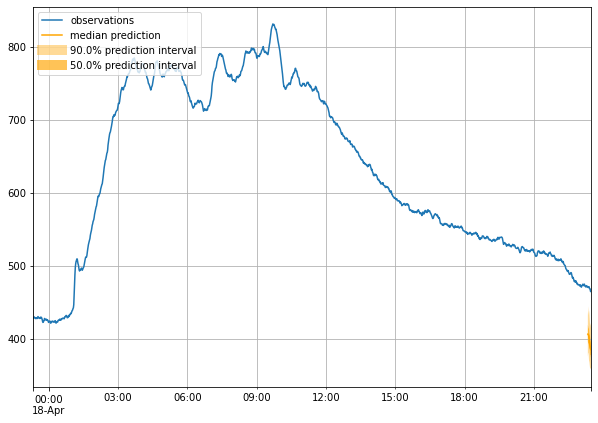

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 23:30:00
Frequency of the time series: 1Min
Mean of the future window:
 [402.9614  398.67163 396.5951  398.88977 394.27725 393.62817 387.70395
 385.92917 384.39243 382.6572 ]
0.5-quantile (median) of the future window:
 [402.42877 399.865   396.99368 397.6995  396.09924 390.25616 385.9709
 386.4787  385.61777 382.78192]
target_value:
 [[463.5     462.      461.5     461.      462.5     461.      459.
  460.33334 460.      459.     ]]


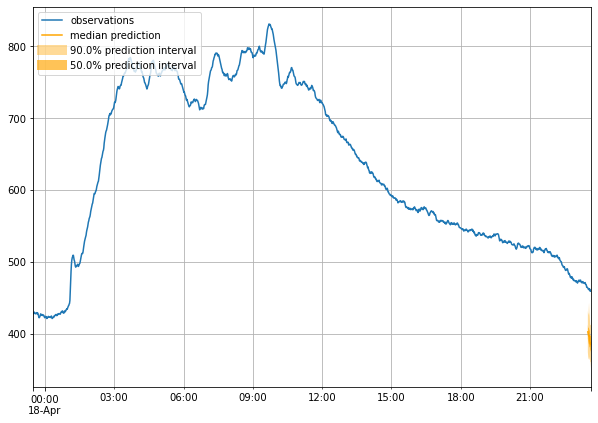

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 23:40:00
Frequency of the time series: 1Min
Mean of the future window:
 [398.55637 400.01395 394.82468 374.69983 511.6179  417.3284  405.82733
 400.52457 398.4326  396.2921 ]
0.5-quantile (median) of the future window:
 [398.6182  401.78772 397.169   376.2327  513.13086 416.72696 405.66437
 400.85748 396.93152 399.33752]
target_value:
 [[459.      461.5     460.5     460.5     460.5     463.      461.33334
  460.33334 458.5     457.     ]]


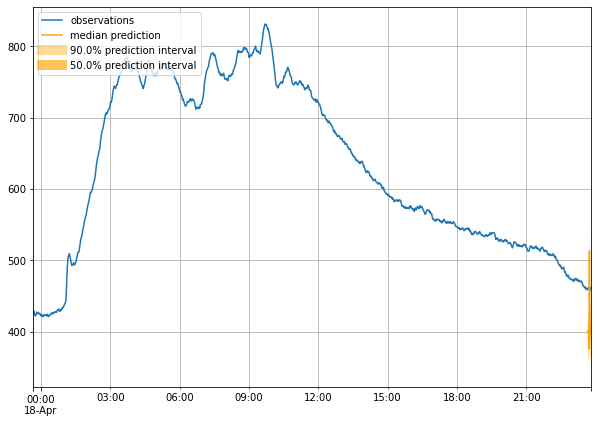

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-18 23:50:00
Frequency of the time series: 1Min
Mean of the future window:
 [405.88892 404.75665 400.69522 403.1909  397.83243 394.46637 388.70734
 385.5508  387.90656 383.1705 ]
0.5-quantile (median) of the future window:
 [407.42505 403.58157 401.36053 402.995   399.9096  396.99765 386.62097
 389.24298 389.6019  384.08096]
target_value:
 [[458.5     458.      457.33334 457.66666 457.33334 455.5     456.5
  456.33334 455.5     454.5    ]]


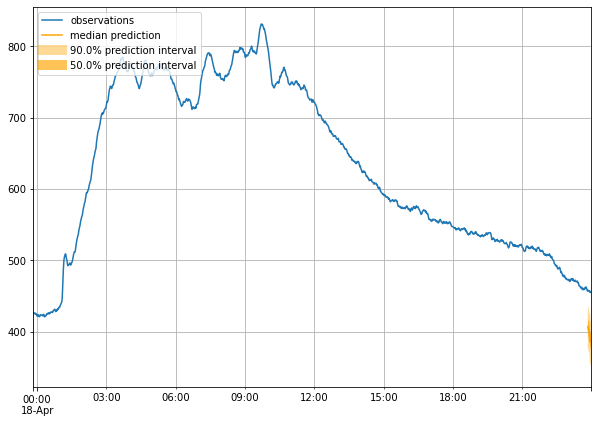

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 00:00:00
Frequency of the time series: 1Min
Mean of the future window:
 [404.20016 398.51038 403.63727 397.87518 399.5151  397.07892 398.37094
 393.905   392.86218 389.70874]
0.5-quantile (median) of the future window:
 [404.82336 400.5862  401.86783 399.22714 399.25473 396.1007  399.2565
 396.59268 396.01193 391.17957]
target_value:
 [[454.2 454.  454.5 454.5 455.5 454.5 454.5 454.  453.5 453. ]]


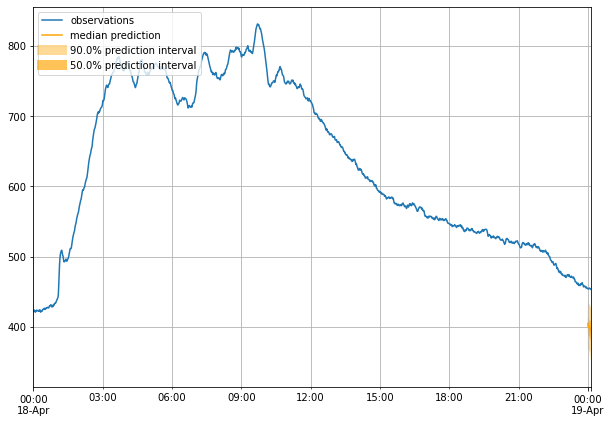

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 00:10:00
Frequency of the time series: 1Min
Mean of the future window:
 [408.74976 404.9254  404.88046 403.39297 402.3825  399.4279  397.95773
 394.4734  395.81015 397.83438]
0.5-quantile (median) of the future window:
 [410.8773  407.03067 404.61157 401.55453 404.6004  401.9682  400.0653
 392.1873  396.43143 397.89062]
target_value:
 [[452.      451.5     451.5     452.66666 452.      453.5     455.
  453.66666 455.33334 454.     ]]


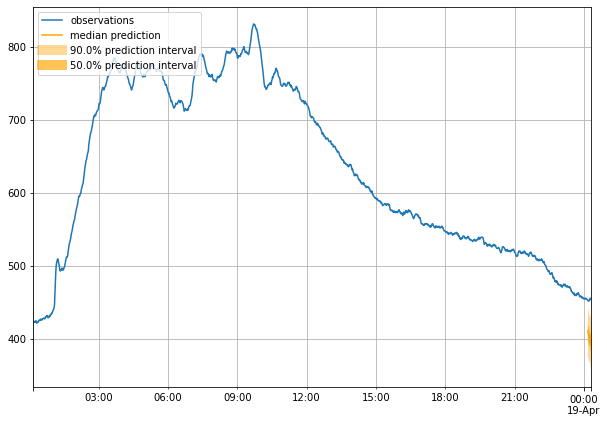

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 00:20:00
Frequency of the time series: 1Min
Mean of the future window:
 [410.7681  409.9231  405.45395 406.94138 402.39044 397.77512 399.85995
 394.83707 394.74905 393.5188 ]
0.5-quantile (median) of the future window:
 [409.73972 406.13962 404.08575 408.44937 401.41135 397.6104  401.46844
 394.19086 394.48502 392.40622]
target_value:
 [[455.  455.  453.  453.  454.5 453.  454.  454.  454.  455. ]]


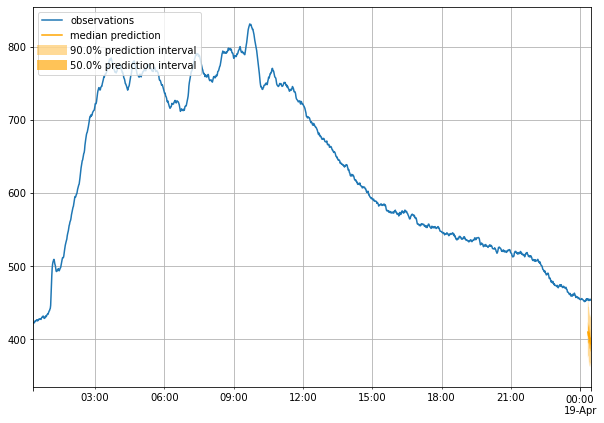

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 00:30:00
Frequency of the time series: 1Min
Mean of the future window:
 [402.76663 408.74774 404.07187 400.3124  397.0887  396.06293 391.82404
 393.7702  389.79236 391.3008 ]
0.5-quantile (median) of the future window:
 [403.8629  410.67026 403.31696 402.32428 397.10828 394.95657 391.559
 392.88943 390.7748  390.86594]
target_value:
 [[455.  455.  454.  455.  454.  453.  452.5 454.5 454.5 456.5]]


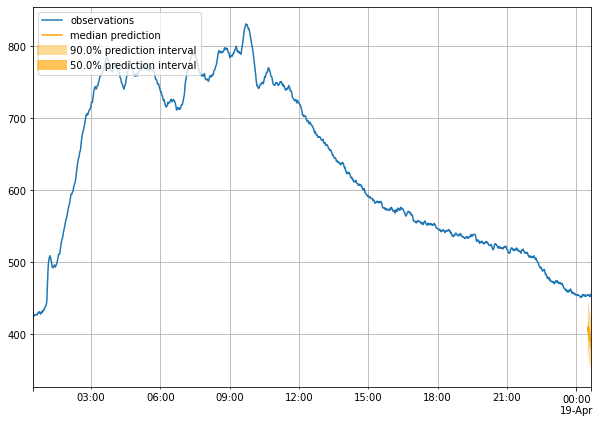

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 00:40:00
Frequency of the time series: 1Min
Mean of the future window:
 [409.07285 407.64258 403.87537 402.9411  526.8385  551.5223  536.7746
 572.0542  588.72626 606.69037]
0.5-quantile (median) of the future window:
 [407.17447 408.703   401.04752 404.85745 532.28644 552.1863  535.30676
 572.63586 589.14087 598.51196]
target_value:
 [[458.      457.5     460.      461.66666 461.66666 460.      460.
  459.      461.      462.     ]]


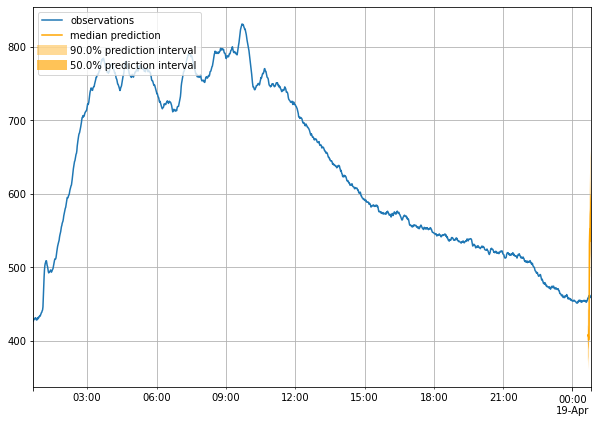

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 00:50:00
Frequency of the time series: 1Min
Mean of the future window:
 [583.0832  606.04553 622.5758  636.3812  620.77    497.74796 492.20868
 479.6023  476.85278 475.46277]
0.5-quantile (median) of the future window:
 [590.4954  605.14124 622.3532  630.05084 628.03253 498.45496 491.70023
 479.68213 474.41574 475.84064]
target_value:
 [[462.5     465.33334 466.5     468.      467.5     467.5     470.
  470.33334 471.      472.     ]]


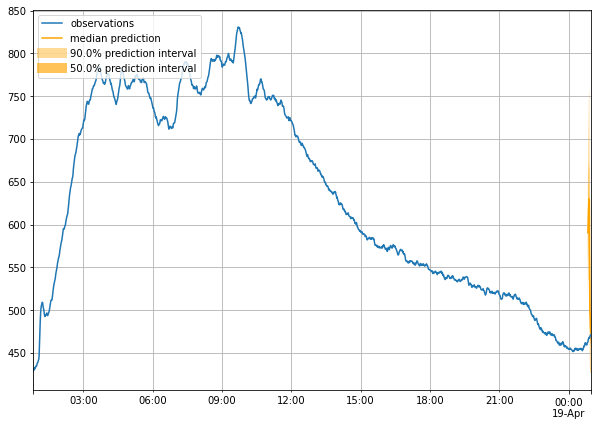

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 01:00:00
Frequency of the time series: 1Min
Mean of the future window:
 [451.31177 560.67596 459.76633 446.51233 436.20267 429.12848 419.84317
 415.6702  474.01572 411.18625]
0.5-quantile (median) of the future window:
 [444.0092  565.9117  458.38504 445.3819  436.7784  429.99893 423.12753
 415.62387 475.37698 409.85986]
target_value:
 [[475.      477.      477.66666 480.      482.5     482.5     483.66666
  485.5     484.66666 483.5    ]]


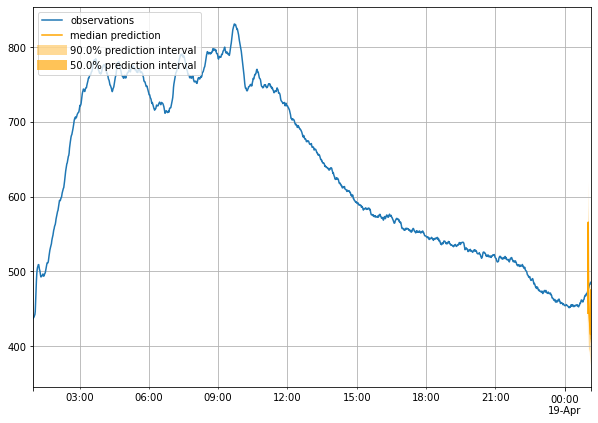

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 01:10:00
Frequency of the time series: 1Min
Mean of the future window:
 [418.12442 413.90204 407.506   404.0128  402.9524  399.9495  393.21698
 386.63364 378.45917 379.1789 ]
0.5-quantile (median) of the future window:
 [418.19168 416.81662 409.74054 404.32687 404.03217 401.22723 395.45703
 390.97516 380.91324 377.83865]
target_value:
 [[483.      485.33334 486.5     488.5     490.      493.5     495.
  496.      496.      496.     ]]


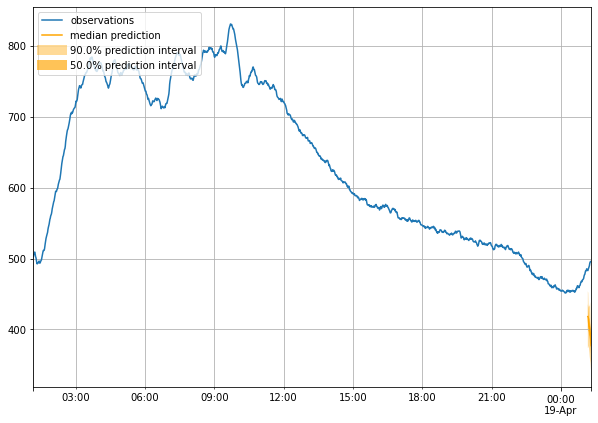

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 01:20:00
Frequency of the time series: 1Min
Mean of the future window:
 [533.9144  562.67224 582.46454 456.29327 440.3656  435.76538 430.62167
 427.95566 417.57465 412.10672]
0.5-quantile (median) of the future window:
 [531.02216 565.4065  584.838   454.18185 439.8186  429.56488 432.25623
 426.94827 418.6728  415.91943]
target_value:
 [[497.4 500.5 503.  505.8 508.5 510.5 512.  514.5 518.  521.5]]


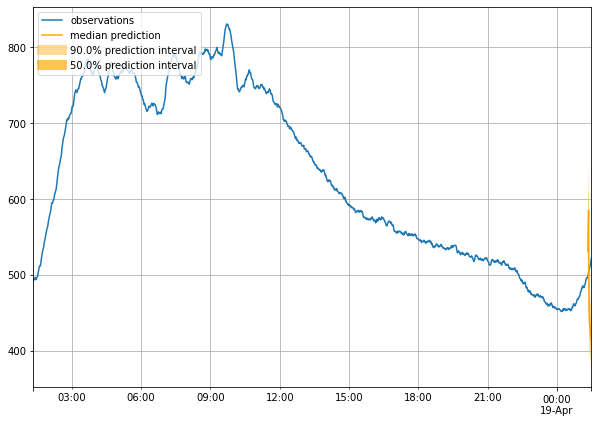

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 01:30:00
Frequency of the time series: 1Min
Mean of the future window:
 [424.94788 424.47    413.6518  412.70593 407.0148  398.10745 397.52765
 391.13284 384.8997  380.9199 ]
0.5-quantile (median) of the future window:
 [427.28006 422.81335 413.14023 414.02457 409.06485 399.86835 394.80334
 391.45035 384.06262 382.08792]
target_value:
 [[526.5    531.5    535.5    538.5    540.5    547.     552.     555.
  557.5    559.8333]]


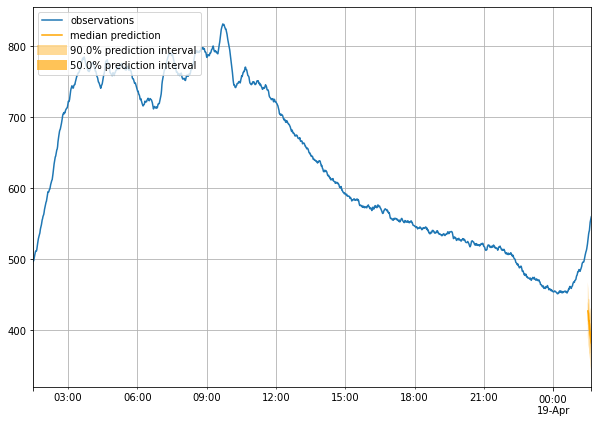

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 01:40:00
Frequency of the time series: 1Min
Mean of the future window:
 [417.25888 417.2389  419.1115  408.9138  403.3931  397.85254 395.54797
 384.99597 383.54434 380.48474]
0.5-quantile (median) of the future window:
 [418.5347  417.57098 418.12317 409.65958 403.07086 396.33344 395.27142
 384.1076  383.26114 380.36285]
target_value:
 [[564.5 567.5 569.5 571.5 573.5 575.5 577.  580.  583.  585. ]]


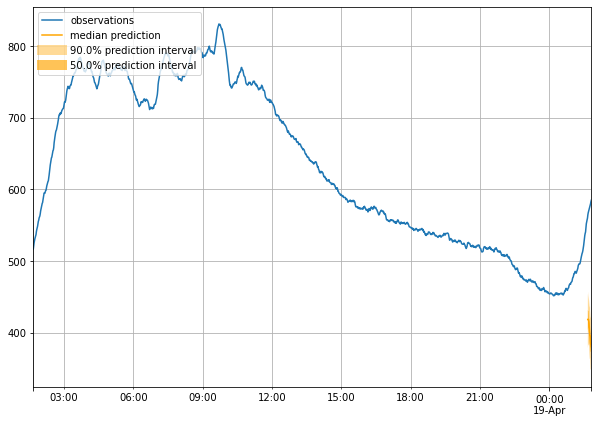

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 01:50:00
Frequency of the time series: 1Min
Mean of the future window:
 [431.66843 428.77396 425.72382 418.17352 410.12595 407.33136 398.98135
 393.1682  380.5082  518.9128 ]
0.5-quantile (median) of the future window:
 [432.5773  430.98825 423.48022 419.05655 410.38733 407.97226 399.2986
 394.88037 381.62698 518.32104]
target_value:
 [[588.3333 591.     594.     597.     599.     600.8    603.5    603.5
  606.5    608.6667]]


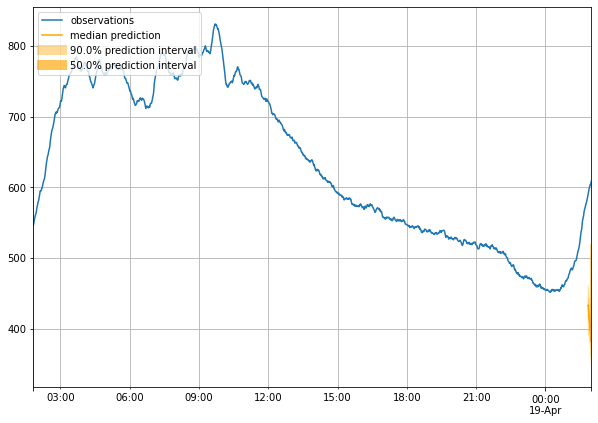

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 02:00:00
Frequency of the time series: 1Min
Mean of the future window:
 [456.46786 449.28534 441.8453  437.32175 431.12927 426.83786 417.05432
 405.36102 404.26065 396.2182 ]
0.5-quantile (median) of the future window:
 [461.57172 449.94083 441.8356  437.88498 431.81436 428.7656  415.50232
 406.1158  403.30142 396.66956]
target_value:
 [[609.5 614.5 618.5 620.5 624.  628.  628.5 630.5 632.5 634.5]]


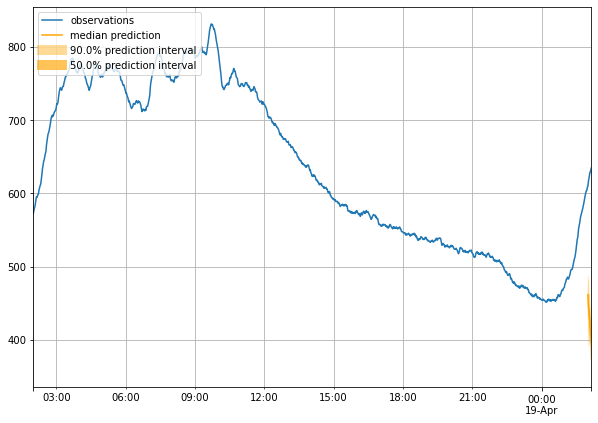

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 02:10:00
Frequency of the time series: 1Min
Mean of the future window:
 [458.30762 461.01816 455.99216 444.59943 435.0885  429.75375 425.0483
 416.93848 409.91965 404.8964 ]
0.5-quantile (median) of the future window:
 [455.6572  462.0685  457.57288 446.61472 436.1058  426.44952 423.94714
 416.27594 409.42963 405.3121 ]
target_value:
 [[636.3333 635.     637.3333 638.3333 640.     642.5    645.     648.5
  652.5    656.    ]]


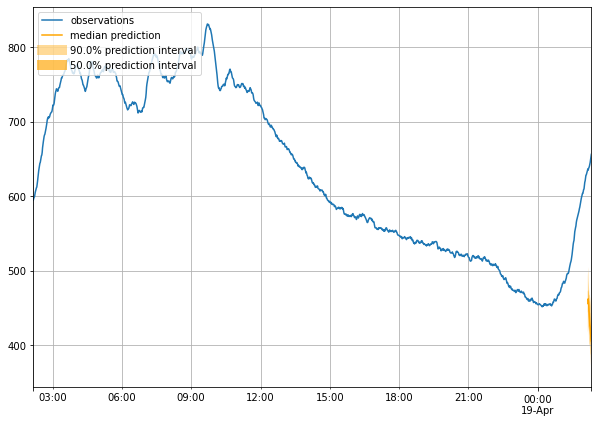

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 02:20:00
Frequency of the time series: 1Min
Mean of the future window:
 [466.5907  467.01065 462.82214 459.86374 441.4835  440.12515 427.7733
 417.24133 411.15628 410.5785 ]
0.5-quantile (median) of the future window:
 [467.66904 466.0845  462.6824  460.13843 439.06516 437.7303  426.7365
 417.3014  414.1005  412.0641 ]
target_value:
 [[659.5 663.5 667.6 669.5 670.  672.5 675.5 675.5 678.  680.5]]


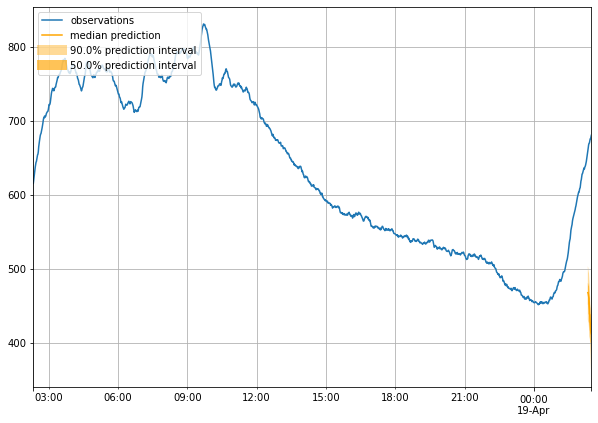

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 02:30:00
Frequency of the time series: 1Min
Mean of the future window:
 [482.06073 483.42242 476.2238  469.6622  457.27625 448.63016 441.82657
 433.57434 425.68665 417.09854]
0.5-quantile (median) of the future window:
 [482.0655  481.99792 474.75287 465.02914 462.9905  450.53116 439.50467
 436.10077 426.8418  414.68607]
target_value:
 [[683.     687.     691.5    693.5    693.6667 693.6667 696.6    698.5
  698.     696.5   ]]


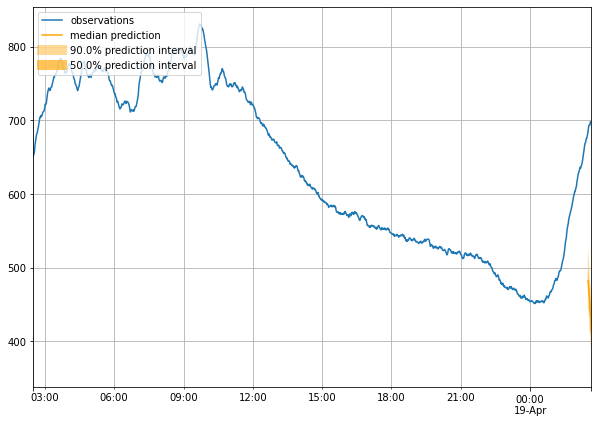

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 02:40:00
Frequency of the time series: 1Min
Mean of the future window:
 [505.95374 506.22168 500.638   490.94016 479.38782 476.86902 466.10327
 450.0684  573.77856 462.30298]
0.5-quantile (median) of the future window:
 [502.4738  507.9892  499.76837 491.47635 482.8346  478.0993  462.85574
 450.48096 573.3599  465.9587 ]
target_value:
 [[697.     696.3333 694.5    693.5    692.     689.5    689.     689.
  687.5    687.5   ]]


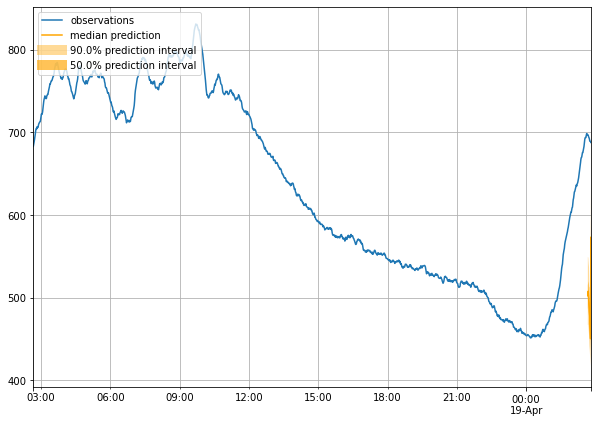

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 02:50:00
Frequency of the time series: 1Min
Mean of the future window:
 [520.6976  521.9487  516.4793  510.1946  498.1472  493.99832 490.52423
 475.25253 467.9583  464.10635]
0.5-quantile (median) of the future window:
 [523.646   523.3368  516.4973  510.53024 500.05118 495.8987  490.5496
 474.68668 466.31308 461.27563]
target_value:
 [[685.5    686.5    686.6667 686.5    685.2    685.2    686.     686.6667
  688.5    689.2   ]]


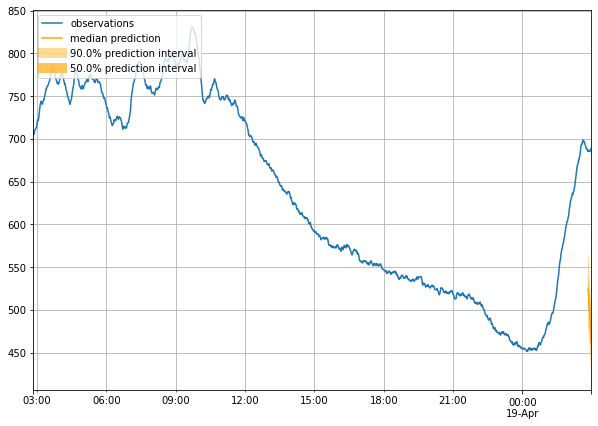

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 03:00:00
Frequency of the time series: 1Min
Mean of the future window:
 [533.07477 529.1775  524.5842  519.864   508.7611  499.5929  492.64227
 484.8867  590.6269  596.1825 ]
0.5-quantile (median) of the future window:
 [533.8026  528.87744 525.02124 522.1399  507.3626  499.42142 493.12384
 485.4212  590.55664 597.9765 ]
target_value:
 [[688.5    689.     688.3333 689.     690.3333 690.6667 691.5    692.
  691.     693.    ]]


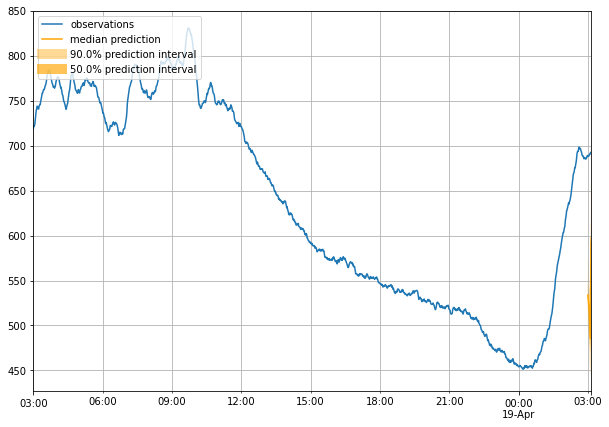

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 03:10:00
Frequency of the time series: 1Min
Mean of the future window:
 [642.1563  537.5022  519.91125 535.32385 525.63165 515.6632  513.5549
 501.84518 497.71884 488.19922]
0.5-quantile (median) of the future window:
 [632.71643 538.101   520.42236 534.86847 524.5413  514.883   514.1027
 503.9847  498.33624 490.44156]
target_value:
 [[695.  695.  694.  694.  695.  694.  697.5 697.6 698.5 699.5]]


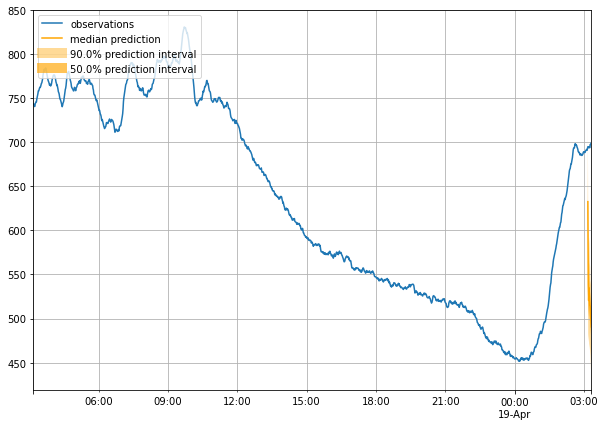

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 03:20:00
Frequency of the time series: 1Min
Mean of the future window:
 [562.85565 559.3633  553.4173  543.099   538.6306  529.0003  523.9116
 511.6345  506.571   502.92798]
0.5-quantile (median) of the future window:
 [562.9084  560.49316 553.51636 546.0989  537.8364  528.80096 522.20166
 510.21234 506.39844 504.74567]
target_value:
 [[699.  701.  700.5 699.5 699.4 698.5 699.6 701.  701.5 704. ]]


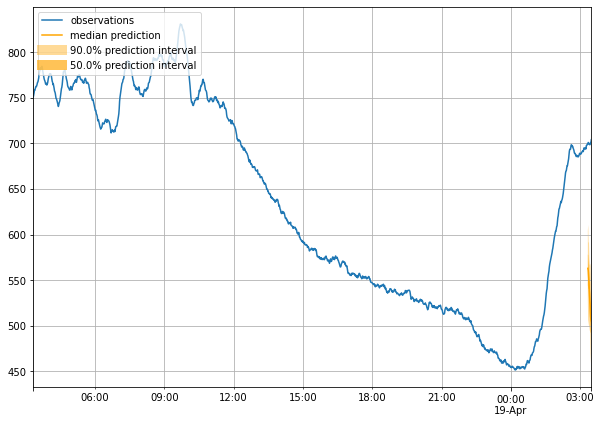

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 03:30:00
Frequency of the time series: 1Min
Mean of the future window:
 [564.4223  568.07526 557.77856 558.319   546.00464 535.76807 529.00116
 519.62555 517.1926  510.48535]
0.5-quantile (median) of the future window:
 [564.7831  569.59875 559.6119  561.3987  543.0414  535.49365 531.59875
 521.5731  517.9787  510.41245]
target_value:
 [[704.6667 706.8    706.     703.5    702.5    700.     698.6    694.5
  691.6667 693.5   ]]


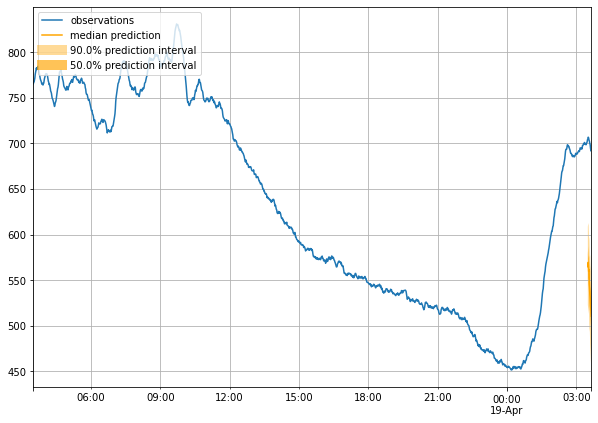

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 03:40:00
Frequency of the time series: 1Min
Mean of the future window:
 [579.41833 576.781   567.63995 561.53894 556.73834 544.6077  543.5171
 528.61365 525.53217 519.1111 ]
0.5-quantile (median) of the future window:
 [576.81757 577.1544  572.4809  561.94226 561.6469  543.74255 542.25183
 525.3362  527.0747  523.60114]
target_value:
 [[694.  694.5 694.8 691.5 688.  685.  682.  679.5 677.5 677.5]]


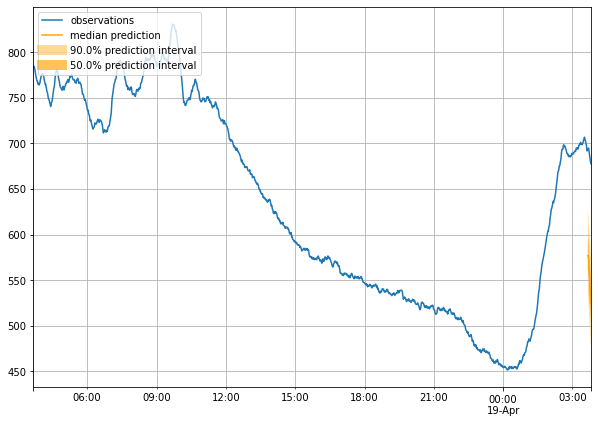

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 03:50:00
Frequency of the time series: 1Min
Mean of the future window:
 [569.18787 572.63306 568.255   560.6765  553.6756  549.8981  536.36725
 535.7856  526.1598  525.2961 ]
0.5-quantile (median) of the future window:
 [571.0483  573.84125 566.6392  558.1963  553.65314 548.5969  534.743
 534.3648  526.8533  529.92084]
target_value:
 [[675.6    673.3333 673.     672.     671.5    670.     668.3333 667.
  666.     663.4   ]]


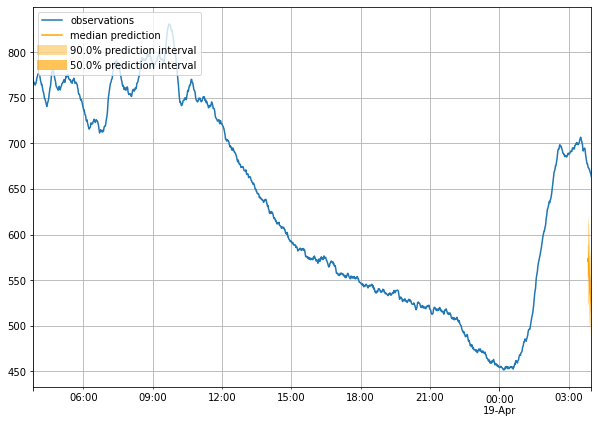

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 04:00:00
Frequency of the time series: 1Min
Mean of the future window:
 [569.2553  564.2614  565.1765  557.785   551.98315 543.6394  537.802
 535.5474  526.18695 522.7446 ]
0.5-quantile (median) of the future window:
 [567.50806 565.26245 563.66223 559.04877 551.44025 545.04333 534.57587
 539.8105  526.8464  526.5479 ]
target_value:
 [[662.  661.  662.  661.5 663.  664.5 665.  667.5 667.  670. ]]


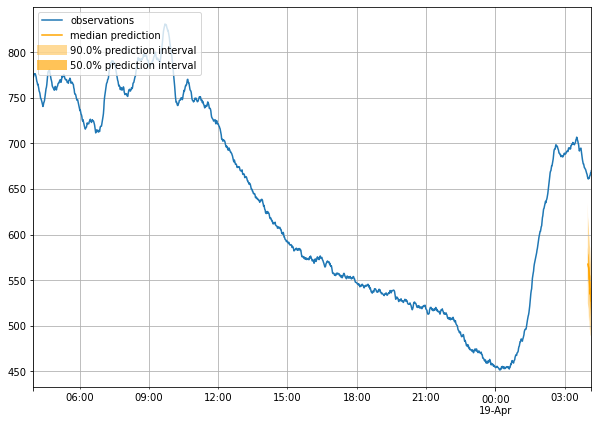

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 04:10:00
Frequency of the time series: 1Min
Mean of the future window:
 [571.1421  570.86053 564.4539  559.11597 561.9958  559.6975  546.0975
 542.8741  532.2951  534.84827]
0.5-quantile (median) of the future window:
 [573.35333 567.6786  564.09155 565.3187  559.64294 558.706   548.1139
 542.6178  536.48236 538.66235]
target_value:
 [[670.5    671.5    673.3333 671.6667 674.2    674.     674.75   673.4
  673.5    675.5   ]]


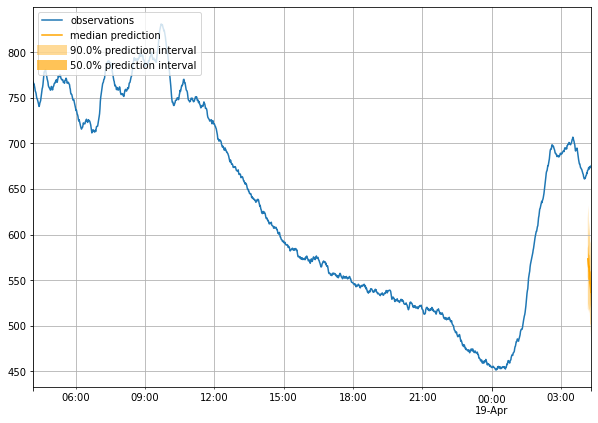

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 04:20:00
Frequency of the time series: 1Min
Mean of the future window:
 [585.27515 584.59106 580.5071  579.9281  564.276   563.3623  562.3691
 556.5334  554.2048  547.81885]
0.5-quantile (median) of the future window:
 [586.2053  587.4365  579.6816  577.67004 563.9489  560.6145  564.74884
 557.6645  552.7832  546.04   ]
target_value:
 [[674.     672.6667 671.6667 673.     674.5    675.5    675.5    675.5
  676.     676.    ]]


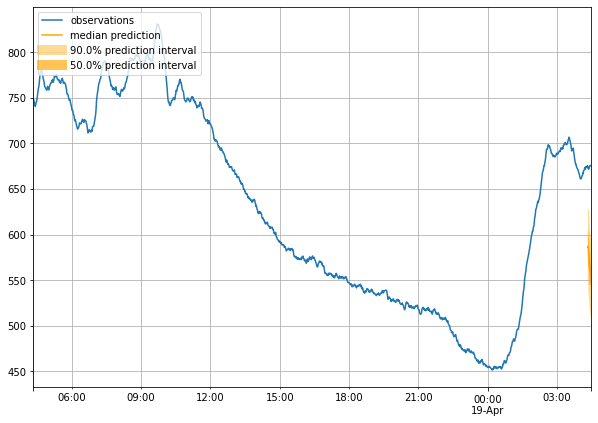

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 04:30:00
Frequency of the time series: 1Min
Mean of the future window:
 [588.604  592.9833 589.2878 580.0341 576.376  575.962  568.2371 558.633
 555.2297 551.322 ]
0.5-quantile (median) of the future window:
 [591.5596  592.30774 590.7093  579.85187 575.19415 575.0815  569.07495
 561.96924 559.3426  554.9849 ]
target_value:
 [[676.     674.3333 677.     679.6667 681.     681.5    681.     685.
  689.     692.5   ]]


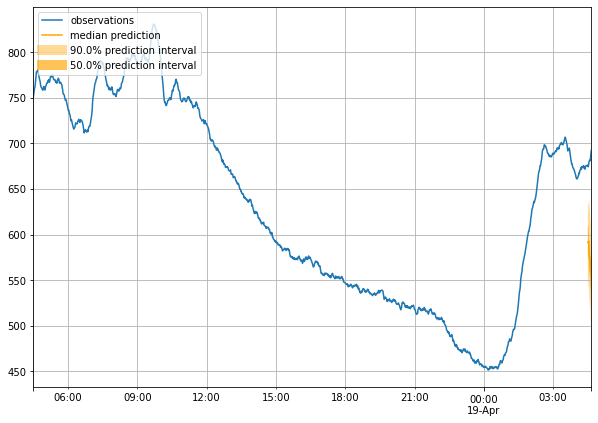

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 04:40:00
Frequency of the time series: 1Min
Mean of the future window:
 [601.1799  596.17377 599.95166 596.8123  591.924   587.9865  596.3579
 580.69226 573.21075 564.6928 ]
0.5-quantile (median) of the future window:
 [596.80457 600.65497 600.0049  597.60474 588.96106 586.8152  595.8301
 578.6114  573.4207  564.82153]
target_value:
 [[696.  699.5 703.5 705.  708.  710.5 713.  715.  717.5 720.5]]


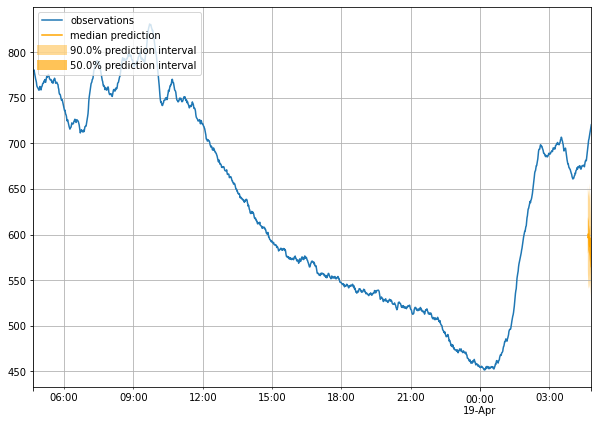

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 04:50:00
Frequency of the time series: 1Min
Mean of the future window:
 [599.58936 603.3684  595.9586  591.30835 583.504   584.7745  583.6192
 570.5718  561.496   560.0506 ]
0.5-quantile (median) of the future window:
 [598.5145  598.15405 596.23395 589.9743  585.28204 584.8577  583.7647
 569.1377  561.41815 560.76355]
target_value:
 [[722.5    725.     725.3333 725.     730.     735.6    736.6667 736.5
  739.     742.    ]]


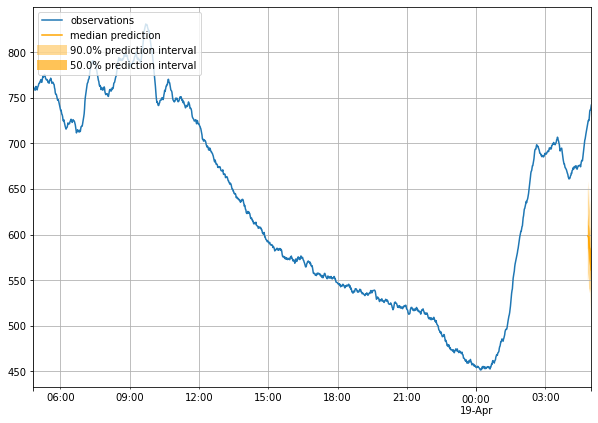

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 05:00:00
Frequency of the time series: 1Min
Mean of the future window:
 [618.0595  612.88745 613.11694 607.3828  599.36334 598.0617  592.1932
 580.77875 579.8018  564.1439 ]
0.5-quantile (median) of the future window:
 [617.40125 615.43164 619.18494 609.58246 603.97144 599.1137  592.0805
 583.37885 580.336   570.0771 ]
target_value:
 [[742.     742.     743.     742.     740.5    739.6667 741.     740.3333
  741.     742.    ]]


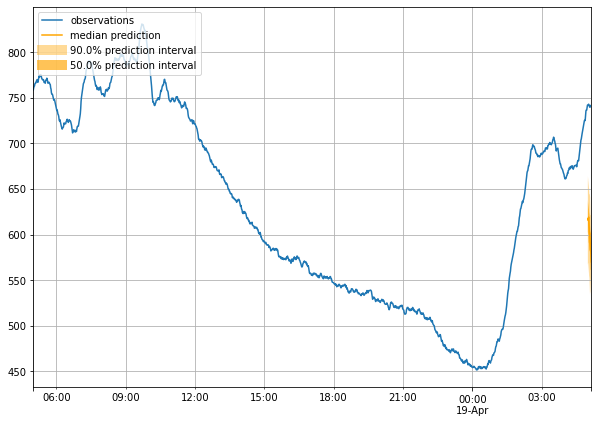

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 05:10:00
Frequency of the time series: 1Min
Mean of the future window:
 [628.2665  634.3684  625.8854  620.45184 615.55585 610.6593  602.13477
 591.9686  590.29065 586.12384]
0.5-quantile (median) of the future window:
 [624.6142  635.93317 624.77136 619.79376 616.8398  611.2435  602.2162
 594.8847  591.56433 589.0061 ]
target_value:
 [[741.     740.5    741.6667 744.     744.     746.     746.     748.3333
  749.8333 752.6   ]]


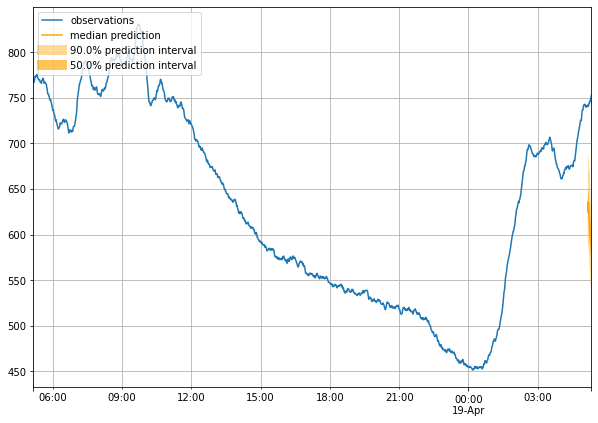

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 05:20:00
Frequency of the time series: 1Min
Mean of the future window:
 [642.35315 644.427   640.40674 627.58563 619.567   623.6534  620.7727
 605.2162  594.53925 595.28735]
0.5-quantile (median) of the future window:
 [640.95325 641.89417 638.50275 625.4466  622.4535  623.6528  618.94495
 601.9177  595.5937  595.9055 ]
target_value:
 [[755.5    759.     763.     766.4    769.3333 769.     771.5    774.5
  774.5    775.5   ]]


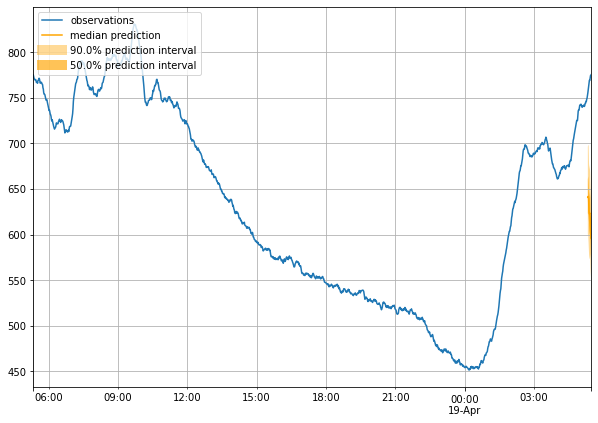

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 05:30:00
Frequency of the time series: 1Min
Mean of the future window:
 [656.51447 650.1495  705.47406 686.3375  675.51776 672.48846 606.5686
 612.11615 616.5775  617.03094]
0.5-quantile (median) of the future window:
 [657.0145  650.6237  703.67236 680.7722  678.953   671.3486  604.47186
 612.6174  616.90125 620.1166 ]
target_value:
 [[777.4    777.4    778.     776.3333 775.5    774.     774.5    773.5
  772.5    772.5   ]]


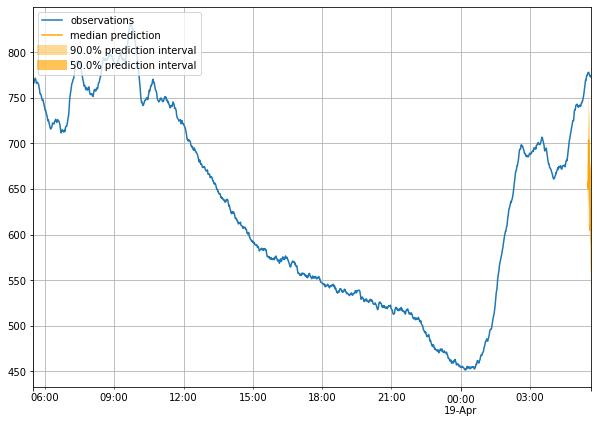

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 05:40:00
Frequency of the time series: 1Min
Mean of the future window:
 [670.4182  674.1043  677.31744 668.36865 666.4986  660.4115  660.5222
 650.449   647.02625 648.509  ]
0.5-quantile (median) of the future window:
 [674.55365 675.6277  678.51886 667.5938  665.33417 663.2115  658.9503
 651.45233 649.1797  647.43384]
target_value:
 [[771.     768.5    766.     763.     760.5    757.5    756.     757.
  755.5    756.6667]]


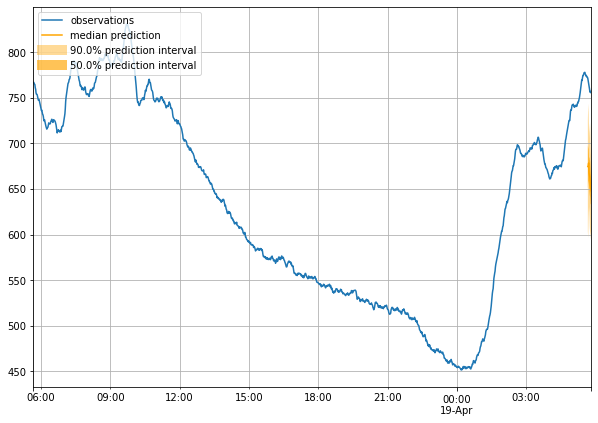

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 05:50:00
Frequency of the time series: 1Min
Mean of the future window:
 [681.32983 679.88776 683.2043  678.80304 670.53455 636.63226 700.04297
 703.7338  607.2717  611.5146 ]
0.5-quantile (median) of the future window:
 [679.4441  677.9064  679.2735  679.0068  669.8865  638.25726 703.08954
 698.7518  612.9402  612.12866]
target_value:
 [[757.  754.5 754.  751.6 750.5 749.  752.  754.5 753.5 751.4]]


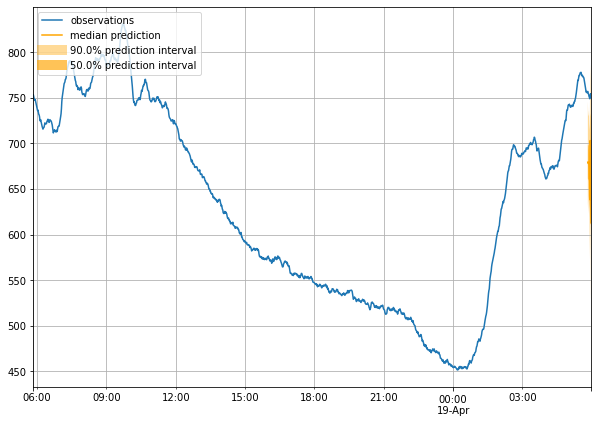

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 06:00:00
Frequency of the time series: 1Min
Mean of the future window:
 [648.3785  650.1226  652.72754 652.3527  650.20557 647.41235 647.6816
 649.09393 644.28595 647.97266]
0.5-quantile (median) of the future window:
 [649.82605 648.64355 653.1237  648.9392  645.91125 650.1487  651.5739
 651.593   643.9927  650.5412 ]
target_value:
 [[751.4    750.3333 748.     745.5    747.5    749.5    750.3333 748.6667
  748.5    749.    ]]


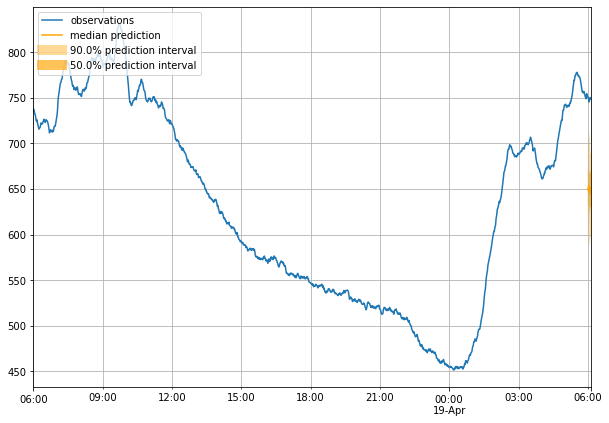

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 06:10:00
Frequency of the time series: 1Min
Mean of the future window:
 [680.5329  681.1168  684.02716 683.50806 678.4841  682.4408  668.854
 670.5464  668.7257  664.26025]
0.5-quantile (median) of the future window:
 [684.9294  681.92053 687.6623  681.99884 680.2813  680.2885  673.1417
 672.91174 667.4457  660.8792 ]
target_value:
 [[750.     751.     754.     756.5    758.5    757.6667 760.5    763.5
  762.5    763.5   ]]


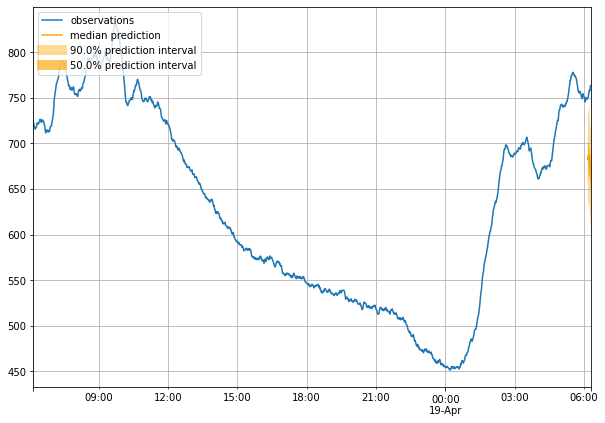

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 06:20:00
Frequency of the time series: 1Min
Mean of the future window:
 [695.579   695.49384 693.8624  689.7823  689.6672  687.6749  685.3343
 684.6053  678.8614  674.014  ]
0.5-quantile (median) of the future window:
 [693.8359  696.0272  698.23785 695.2041  690.56683 689.1171  681.7284
 681.06    678.5493  678.3003 ]
target_value:
 [[765.5 765.  767.2 770.  772.5 774.4 777.  775.  772.5 771. ]]


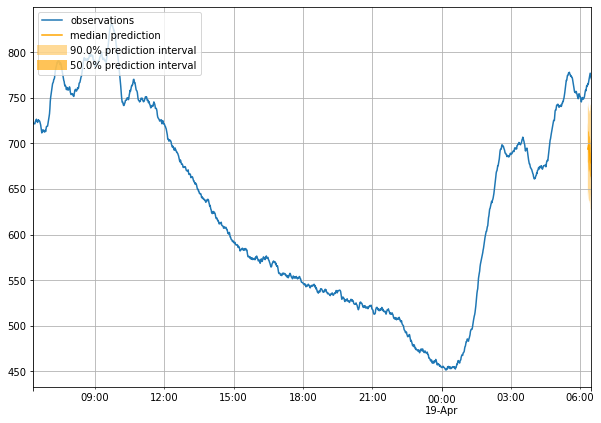

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 06:30:00
Frequency of the time series: 1Min
Mean of the future window:
 [711.1984  709.88776 703.373   704.7894  698.4685  694.2389  695.5784
 694.3201  691.8566  688.6816 ]
0.5-quantile (median) of the future window:
 [709.5223  710.62286 702.48083 709.44415 698.4511  697.4121  693.94635
 694.87866 693.1978  684.2936 ]
target_value:
 [[769.5    769.6667 771.4    768.5    766.3333 767.5    767.     767.
  767.5    767.    ]]


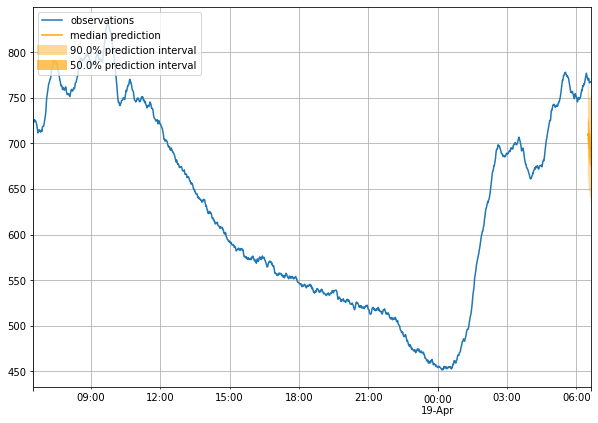

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 06:40:00
Frequency of the time series: 1Min
Mean of the future window:
 [710.4473  711.07654 718.15936 705.37195 701.9724  701.8683  695.46045
 694.9454  684.423   695.4771 ]
0.5-quantile (median) of the future window:
 [711.7995  708.32825 718.3835  705.60236 694.8582  700.3251  692.19635
 694.8303  682.6253  693.71704]
target_value:
 [[770.  773.  775.5 778.  776.  776.  774.  772.  769.5 768.5]]


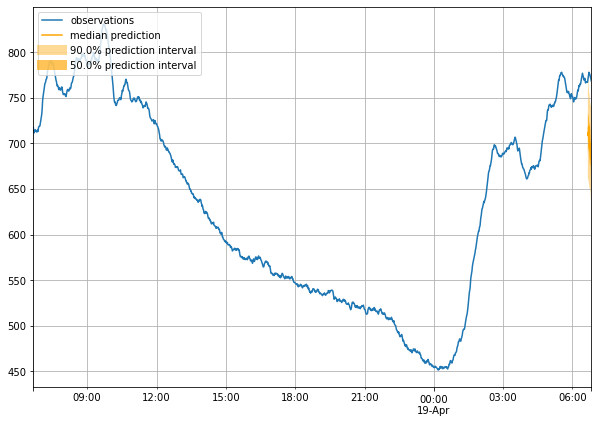

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2022-04-19 06:50:00
Frequency of the time series: 1Min
Mean of the future window:
 [717.23737 715.21405 717.5643  714.9013  712.7389  704.17883 705.9265
 703.122   701.49634 696.9903 ]
0.5-quantile (median) of the future window:
 [718.7783  716.1414  716.64795 712.2504  713.67914 698.7648  707.1298
 702.98157 699.0043  700.1015 ]
target_value:
 [[768.6667 770.     770.     770.     773.     773.6667 775.5    777.
  777.     774.5   ]]


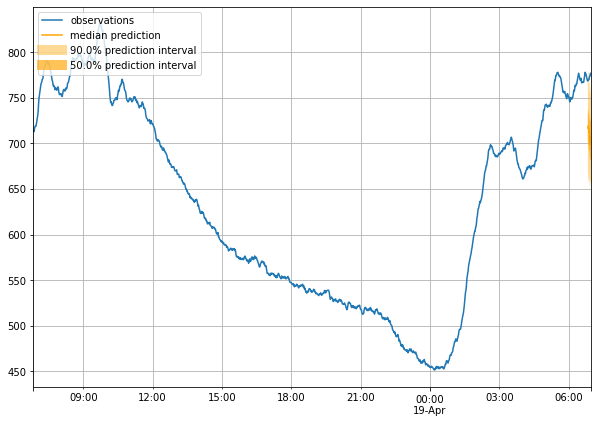

In [77]:
target_quantile=0.5
y_labels = []
y_preds = []

for i in range(len(tss)):
    y_label, y_pred = show_metrics(i, target_quantile=target_quantile, plot_graph=True)
    y_labels.append(y_label)
    y_preds.append(y_pred)

In [78]:
from sklearn import metrics

def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)/100

def eval_metric(a, f):
#     print('a:', a)
#     print('f:', f)
    new_a = []
    new_f = []
    for i in range(len(a)):
        if a[i] != 0:
            new_a.append(a[i])
            new_f.append(f[i])
    new_a = np.array(a)
    new_f = np.array(f)
#     print('new_a:', new_a)
#     print('new_f:', new_f)
    return np.mean((new_f-new_a)/new_a)

def eval_metric2(a, f):
#     print('a:', a)
#     print('f:', f)
    new_a = []
    new_f = []
    for i in range(len(a)):
        if a[i] != 0:
            new_a.append(a[i])
            new_f.append(f[i])
    new_a = np.array(a)
    new_f = np.array(f)
#     print('new_a:', new_a)
#     print('new_f:', new_f)
    return np.mean(np.abs(new_f-new_a)/np.abs(new_a))

print('y_labels:', len(y_labels))
print('y_preds:', len(y_preds))
y_labels = np.array(y_labels)
y_preds = np.array(y_preds)
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_labels, y_preds)))
print("MAE:",metrics.mean_absolute_error(y_labels, y_preds))
print("Target Mean:",y_labels.mean())
smape_score = 0
smapes = []
rmses = []
maes = []
means = []
for i in range(y_labels.shape[0]):
    smapei = smape(y_labels[i], y_preds[i])
    rmsei = np.sqrt(metrics.mean_squared_error(y_labels[i], y_preds[i]))
    maei = metrics.mean_absolute_error(y_labels[i], y_preds[i])
    smape_score += smapei
    smapes.append(smapei)
    rmses.append(rmsei)
    maes.append(maei)
    means.append(y_labels[i].mean())
print("sMAPE:",smape_score/y_labels.shape[0])

y_labels: 186
y_preds: 186
RMSE: 101.927124
MAE: 87.03846
Target Mean: 636.30237
sMAPE: 0.14919358806199928


In [79]:
y_sum_labels = np.sum(y_labels, axis=0)
y_sum_preds = np.sum(y_preds, axis=0)
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_sum_labels, y_sum_preds)))
print("MAE:",metrics.mean_absolute_error(y_sum_labels, y_sum_preds))
print("SMAPE:", smape(y_sum_labels, y_sum_preds))
print("EVAL METRIC:", eval_metric(y_sum_labels, y_sum_preds))
print("EVAL METRIC2:", eval_metric2(y_sum_labels, y_sum_preds))
print("Target Mean:",y_sum_labels.mean())

RMSE: 15859.729
MAE: 15724.164
SMAPE: 0.14248315429687503
EVAL METRIC: -0.13284552
EVAL METRIC2: 0.13284552
Target Mean: 118352.234


In [80]:
y_sum_labels

array([118197.58 , 118235.91 , 118279.01 , 118311.56 , 118342.42 ,
       118352.1  , 118411.82 , 118447.81 , 118454.28 , 118489.914],
      dtype=float32)

In [81]:
y_sum_preds

array([105264.74, 105136.91, 104471.38, 103792.  , 103269.67, 102475.06,
       101590.82, 100447.02, 100165.41,  99667.74], dtype=float32)

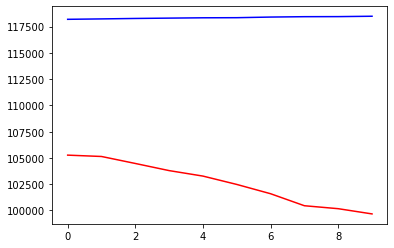

In [82]:
plt.plot(y_sum_labels,"b-",label="label")
plt.plot(y_sum_preds,"r-",label="predict")
plt.show()

In [83]:
y_labels_flat = y_labels.flatten()
y_preds_flat = y_preds.flatten()

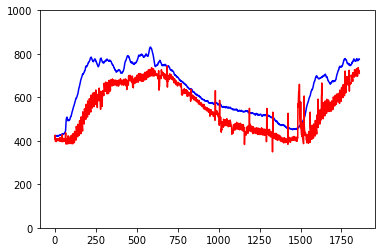

In [84]:
plt.ylim((0, 1000))
plt.plot(y_labels_flat,"b-",label="label")
plt.plot(y_preds_flat,"r-",label="predict")
plt.show()

# Evaluate All Models

In [ ]:
for name, predictor in predictors.items():
    print(name)
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=predict_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    print(len(forecasts), len(tss))
    
    target_quantile = 0.7
    y_labels = []
    y_preds = []

    for i in range(len(tss)):
        y_label, y_pred = show_metrics(i, target_quantile=target_quantile, plot_graph=False)
        y_labels.append(y_label)
        y_preds.append(y_pred)
        
    y_sum_labels = np.sum(y_labels, axis=0)
    y_sum_preds = np.sum(y_preds, axis=0)
    print("RMSE:",np.sqrt(metrics.mean_squared_error(y_sum_labels, y_sum_preds)))
    print("MAE:",metrics.mean_absolute_error(y_sum_labels, y_sum_preds))
    print("SMAPE:", smape(y_sum_labels, y_sum_preds))
    print("EVAL METRIC:", eval_metric(y_sum_labels, y_sum_preds))
    print("EVAL METRIC2:", eval_metric2(y_sum_labels, y_sum_preds))
    print("Target Mean:",y_sum_labels.mean())
    
    plt.plot(y_sum_labels,"b-",label="label")
    plt.plot(y_sum_preds,"r-",label="predict")
    plt.show()
    
    y_labels_flat = np.array(y_labels).flatten()
    y_preds_flat = np.array(y_preds).flatten()
    plt.ylim((0, 1000))
    plt.plot(y_labels_flat,"b-",label="label")
    plt.plot(y_preds_flat,"r-",label="predict")
    plt.show()